**this kernel was forked from here : https://www.kaggle.com/samusram/cloud-classifier-for-post-processing?scriptVersionId=20265194

i got 0.657 using densenet201(in version 3) **

i tried  efficientnetb4 but it failed for large image size,so i will try efficientnetb3 now with bce dice loss
if you find this kernel useful,please upvote,your upvote motivates kagglers like us to share things publicly,thanks

**Version 13**

- updating previously used submission.csv with version 3's generated submission file which achieved 0.657

- threshold = 0.9

- efficientnetb2

- loss='categorical_crossentropy', metrics=['accuracy']

# Intro
In this notebook I'd create a classifier to distinguish types of cloud formations. Using this classifier I'd check if it improves currently the best LB score from the great [public notebook by Jan](https://www.kaggle.com/jpbremer/efficient-net-b4-unet-clouds). 

# Plan
1. [Libraries](#Libraries)
2. [Data Generators](#Data-Generators)
  * [One-hot encoding classes](#One-hot-encoding-classes)
  * [Stratified split into train/val](#Stratified-split-into-train/val)
  * [Generator class](#Generator-class)
3. [PR-AUC-based Callback](#PR-AUC-based-Callback)
4. [Classifier](#Classifier)
  * [Defining a model](#Defining-a-model)
  * [Initial tuning of the added fully-connected layer](#Initial-tuning-of-the-added-fully-connected-layer)
  * [Fine-tuning the whole model](#Fine-tuning-the-whole-model)
  * [Visualizing train and val PR AUC](#Visualizing-train-and-val-PR-AUC)
5. [Selecting postprocessing thresholds](#Selecting-postprocessing-thresholds)
6. [Post-processing segmentation submission](#Post-processing-segmentation-submission)
7. [Future work](#Future-work)

# Libraries

In [1]:
import os, glob
import random
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import pandas as pd
import multiprocessing
from copy import deepcopy
from sklearn.metrics import precision_recall_curve, auc
import keras
import keras.backend as K
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.applications.densenet import DenseNet201
from keras.layers import Dense, Flatten
from keras.models import Model, load_model
from keras.utils import Sequence
from albumentations import Compose, VerticalFlip, HorizontalFlip, Rotate, GridDistortion
import matplotlib.pyplot as plt
from IPython.display import Image
from tqdm import tqdm_notebook as tqdm
from numpy.random import seed
seed(10)
from tensorflow import set_random_seed
set_random_seed(10)
%matplotlib inline

Using TensorFlow backend.


In [ ]:
!pip install keras-rectified-adam

In [2]:
test_imgs_folder = './input/test_images/'
train_imgs_folder = './input/train_images/'
num_cores = multiprocessing.cpu_count()

# Data Generators

## One-hot encoding classes

In [3]:
train_df = pd.read_csv('./input/train.csv')
train_df.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


In [4]:
train_df = train_df[~train_df['EncodedPixels'].isnull()]
train_df['Image'] = train_df['Image_Label'].map(lambda x: x.split('_')[0])
train_df['Class'] = train_df['Image_Label'].map(lambda x: x.split('_')[1])
classes = train_df['Class'].unique()
train_df = train_df.groupby('Image')['Class'].agg(set).reset_index()
for class_name in classes:
    train_df[class_name] = train_df['Class'].map(lambda x: 1 if class_name in x else 0)
train_df.head()

,Image,Class,Fish,Flower,Sugar,Gravel
0,0011165.jpg,"{Flower, Fish}",1,1,0,0
1,002be4f.jpg,"{Flower, Sugar, Fish}",1,1,1,0
2,0031ae9.jpg,"{Flower, Sugar, Fish}",1,1,1,0
3,0035239.jpg,"{Flower, Gravel}",0,1,0,1
4,003994e.jpg,"{Sugar, Gravel, Fish}",1,0,1,1


In [5]:
# dictionary for fast access to ohe vectors
img_2_ohe_vector = {img:vec for img, vec in zip(train_df['Image'], train_df.iloc[:, 2:].values)}

## Stratified split into train/val

In [6]:
train_imgs, val_imgs = train_test_split(train_df['Image'].values, 
                                        test_size=0.2, 
                                        stratify=train_df['Class'].map(lambda x: str(sorted(list(x)))), # sorting present classes in lexicographical order, just to be sure
                                        random_state=17)

## Generator class

In [7]:
class DataGenenerator(Sequence):
    def __init__(self, images_list=None, folder_imgs=train_imgs_folder, 
                 batch_size=16, shuffle=True, augmentation=None,
                 resized_height=350, resized_width=525, num_channels=3):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        if images_list is None:
            self.images_list = os.listdir(folder_imgs)
        else:
            self.images_list = deepcopy(images_list)
        self.folder_imgs = folder_imgs
        self.len = len(self.images_list) // self.batch_size
        self.resized_height = resized_height
        self.resized_width = resized_width
        self.num_channels = num_channels
        self.num_classes = 4
        self.is_test = not 'train' in folder_imgs
        if not shuffle and not self.is_test:
            self.labels = [img_2_ohe_vector[img] for img in self.images_list[:self.len*self.batch_size]]

    def __len__(self):
        return self.len
    
    def on_epoch_start(self):
        if self.shuffle:
            random.shuffle(self.images_list)

    def __getitem__(self, idx):
        current_batch = self.images_list[idx * self.batch_size: (idx + 1) * self.batch_size]
        X = np.empty((self.batch_size, self.resized_height, self.resized_width, self.num_channels))
        y = np.empty((self.batch_size, self.num_classes))

        for i, image_name in enumerate(current_batch):
            path = os.path.join(self.folder_imgs, image_name)
            img = cv2.resize(cv2.imread(path), (self.resized_width, self.resized_height), interpolation=cv2.INTER_AREA).astype(np.float32)
            if not self.augmentation is None:
                augmented = self.augmentation(image=img)
                img = augmented['image']
            X[i, :, :, :] = img/255.0
            if not self.is_test:
                y[i, :] = img_2_ohe_vector[image_name]
        return X, y

    def get_labels(self):
        if self.shuffle:
            images_current = self.images_list[:self.len*self.batch_size]
            labels = [img_2_ohe_vector[img] for img in images_current]
        else:
            labels = self.labels
        return np.array(labels)

In [8]:
albumentations_train = Compose([
    VerticalFlip(), HorizontalFlip(), Rotate(limit=20), GridDistortion()
], p=1)

Generator instances

In [9]:
data_generator_train = DataGenenerator(train_imgs, augmentation=albumentations_train, batch_size=16)
data_generator_train_eval = DataGenenerator(train_imgs, shuffle=False, batch_size=16)
data_generator_val = DataGenenerator(val_imgs, shuffle=False, batch_size=16)

# PR-AUC-based Callback

The callback would be used:
1. to estimate AUC under precision recall curve for each class,
2. to early stop after 5 epochs of no improvement in mean PR AUC,
3. save a model with the best PR AUC in validation,
4. to reduce learning rate on PR AUC plateau.

In [10]:
class PrAucCallback(Callback):
    def __init__(self, data_generator, num_workers=num_cores, 
                 early_stopping_patience=5, 
                 plateau_patience=3, reduction_rate=0.5,
                 stage='train', checkpoints_path='checkpoints/'):
        super(Callback, self).__init__()
        self.data_generator = data_generator
        self.num_workers = num_workers
        self.class_names = ['Fish', 'Flower', 'Sugar', 'Gravel']
        self.history = [[] for _ in range(len(self.class_names) + 1)] # to store per each class and also mean PR AUC
        self.early_stopping_patience = early_stopping_patience
        self.plateau_patience = plateau_patience
        self.reduction_rate = reduction_rate
        self.stage = stage
        self.best_pr_auc = -float('inf')
        if not os.path.exists(checkpoints_path):
            os.makedirs(checkpoints_path)
        self.checkpoints_path = checkpoints_path
        
    def compute_pr_auc(self, y_true, y_pred):
        pr_auc_mean = 0
        print(f"\n{'#'*30}\n")
        for class_i in range(len(self.class_names)):
            precision, recall, _ = precision_recall_curve(y_true[:, class_i], y_pred[:, class_i])
            pr_auc = auc(recall, precision)
            pr_auc_mean += pr_auc/len(self.class_names)
            print(f"PR AUC {self.class_names[class_i]}, {self.stage}: {pr_auc:.3f}\n")
            self.history[class_i].append(pr_auc)        
        print(f"\n{'#'*20}\n PR AUC mean, {self.stage}: {pr_auc_mean:.3f}\n{'#'*20}\n")
        self.history[-1].append(pr_auc_mean)
        return pr_auc_mean
              
    def is_patience_lost(self, patience):
        if len(self.history[-1]) > patience:
            best_performance = max(self.history[-1][-(patience + 1):-1])
            return best_performance == self.history[-1][-(patience + 1)] and best_performance >= self.history[-1][-1]    
              
    def early_stopping_check(self, pr_auc_mean):
        if self.is_patience_lost(self.early_stopping_patience):
            self.model.stop_training = True    
              
    def model_checkpoint(self, pr_auc_mean, epoch):
        if pr_auc_mean > self.best_pr_auc:
            # remove previous checkpoints to save space
            for checkpoint in glob.glob(os.path.join(self.checkpoints_path, 'efficientNetB4_350x525_epoch_*')):
                os.remove(checkpoint)
            self.best_pr_auc = pr_auc_mean
            self.model.save(os.path.join(self.checkpoints_path, f'efficientNetB4_350x525_epoch_{epoch}_val_pr_auc_{pr_auc_mean}.h5'))              
            print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
              
    def reduce_lr_on_plateau(self):
        if self.is_patience_lost(self.plateau_patience):
            new_lr = float(keras.backend.get_value(self.model.optimizer.lr)) * self.reduction_rate
            keras.backend.set_value(self.model.optimizer.lr, new_lr)
            print(f"\n{'#'*20}\nReduced learning rate to {new_lr}.\n{'#'*20}\n")
        
    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict_generator(self.data_generator, workers=self.num_workers)
        y_true = self.data_generator.get_labels()
        # estimate AUC under precision recall curve for each class
        pr_auc_mean = self.compute_pr_auc(y_true, y_pred)
              
        if self.stage == 'val':
            # early stop after early_stopping_patience=4 epochs of no improvement in mean PR AUC
            self.early_stopping_check(pr_auc_mean)

            # save a model with the best PR AUC in validation
            self.model_checkpoint(pr_auc_mean, epoch)

            # reduce learning rate on PR AUC plateau
            self.reduce_lr_on_plateau()            
        
    def get_pr_auc_history(self):
        return self.history

Callback instances

In [11]:
train_metric_callback = PrAucCallback(data_generator_train_eval)
val_callback = PrAucCallback(data_generator_val, stage='val')

# Classifier

## Defining a model

In [12]:
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=0.0001):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 0.0001
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [ ]:
DELETE !pip install -U git+https://github.com/qubvel/efficientnet

In [ ]:
!pip install -U --pre efficientnet

In [14]:
import efficientnet.keras as efn 
def get_model():
    K.clear_session()
    base_model =  efn.EfficientNetB4(weights='imagenet', include_top=False, pooling='avg', input_shape=(350, 525, 3))
    x = base_model.output
    y_pred = Dense(4, activation='sigmoid')(x)
    return Model(inputs=base_model.input, outputs=y_pred)

model = get_model()

71892992/71892840 [==============================] - ETA: 6: - ETA: 4: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 56s - ETA: 43 - ETA: 36 - ETA: 32 - ETA: 41 - ETA: 46 - ETA: 27 - ETA: 25 - ETA: 23 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 1

In [15]:
from keras_radam import RAdam

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 350, 525, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 175, 263, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 175, 263, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 175, 263, 48) 0           stem_bn[0][0]                    
__________________________________________________________________________________________________
block1a_dw

__________________________________________________________________________________________________
block2a_project_bn (BatchNormal (None, 88, 132, 32)  128         block2a_project_conv[0][0]       
__________________________________________________________________________________________________
block2b_expand_conv (Conv2D)    (None, 88, 132, 192) 6144        block2a_project_bn[0][0]         
__________________________________________________________________________________________________
block2b_expand_bn (BatchNormali (None, 88, 132, 192) 768         block2b_expand_conv[0][0]        
__________________________________________________________________________________________________
block2b_expand_activation (Acti (None, 88, 132, 192) 0           block2b_expand_bn[0][0]          
__________________________________________________________________________________________________
block2b_dwconv (DepthwiseConv2D (None, 88, 132, 192) 1728        block2b_expand_activation[0][0]  
__________

__________________________________________________________________________________________________
block2d_se_reduce (Conv2D)      (None, 1, 1, 8)      1544        block2d_se_reshape[0][0]         
__________________________________________________________________________________________________
block2d_se_expand (Conv2D)      (None, 1, 1, 192)    1728        block2d_se_reduce[0][0]          
__________________________________________________________________________________________________
block2d_se_excite (Multiply)    (None, 88, 132, 192) 0           block2d_activation[0][0]         
                                                                 block2d_se_expand[0][0]          
__________________________________________________________________________________________________
block2d_project_conv (Conv2D)   (None, 88, 132, 32)  6144        block2d_se_excite[0][0]          
__________________________________________________________________________________________________
block2d_pr

block3c_dwconv (DepthwiseConv2D (None, 44, 66, 336)  8400        block3c_expand_activation[0][0]  
__________________________________________________________________________________________________
block3c_bn (BatchNormalization) (None, 44, 66, 336)  1344        block3c_dwconv[0][0]             
__________________________________________________________________________________________________
block3c_activation (Activation) (None, 44, 66, 336)  0           block3c_bn[0][0]                 
__________________________________________________________________________________________________
block3c_se_squeeze (GlobalAvera (None, 336)          0           block3c_activation[0][0]         
__________________________________________________________________________________________________
block3c_se_reshape (Reshape)    (None, 1, 1, 336)    0           block3c_se_squeeze[0][0]         
__________________________________________________________________________________________________
block3c_se

__________________________________________________________________________________________________
block4a_project_bn (BatchNormal (None, 22, 33, 112)  448         block4a_project_conv[0][0]       
__________________________________________________________________________________________________
block4b_expand_conv (Conv2D)    (None, 22, 33, 672)  75264       block4a_project_bn[0][0]         
__________________________________________________________________________________________________
block4b_expand_bn (BatchNormali (None, 22, 33, 672)  2688        block4b_expand_conv[0][0]        
__________________________________________________________________________________________________
block4b_expand_activation (Acti (None, 22, 33, 672)  0           block4b_expand_bn[0][0]          
__________________________________________________________________________________________________
block4b_dwconv (DepthwiseConv2D (None, 22, 33, 672)  6048        block4b_expand_activation[0][0]  
__________

__________________________________________________________________________________________________
block4d_se_reduce (Conv2D)      (None, 1, 1, 28)     18844       block4d_se_reshape[0][0]         
__________________________________________________________________________________________________
block4d_se_expand (Conv2D)      (None, 1, 1, 672)    19488       block4d_se_reduce[0][0]          
__________________________________________________________________________________________________
block4d_se_excite (Multiply)    (None, 22, 33, 672)  0           block4d_activation[0][0]         
                                                                 block4d_se_expand[0][0]          
__________________________________________________________________________________________________
block4d_project_conv (Conv2D)   (None, 22, 33, 112)  75264       block4d_se_excite[0][0]          
__________________________________________________________________________________________________
block4d_pr

__________________________________________________________________________________________________
block5a_expand_bn (BatchNormali (None, 22, 33, 672)  2688        block5a_expand_conv[0][0]        
__________________________________________________________________________________________________
block5a_expand_activation (Acti (None, 22, 33, 672)  0           block5a_expand_bn[0][0]          
__________________________________________________________________________________________________
block5a_dwconv (DepthwiseConv2D (None, 22, 33, 672)  16800       block5a_expand_activation[0][0]  
__________________________________________________________________________________________________
block5a_bn (BatchNormalization) (None, 22, 33, 672)  2688        block5a_dwconv[0][0]             
__________________________________________________________________________________________________
block5a_activation (Activation) (None, 22, 33, 672)  0           block5a_bn[0][0]                 
__________

__________________________________________________________________________________________________
block5c_project_bn (BatchNormal (None, 22, 33, 160)  640         block5c_project_conv[0][0]       
__________________________________________________________________________________________________
block5c_drop (FixedDropout)     (None, 22, 33, 160)  0           block5c_project_bn[0][0]         
__________________________________________________________________________________________________
block5c_add (Add)               (None, 22, 33, 160)  0           block5c_drop[0][0]               
                                                                 block5b_add[0][0]                
__________________________________________________________________________________________________
block5d_expand_conv (Conv2D)    (None, 22, 33, 960)  153600      block5c_add[0][0]                
__________________________________________________________________________________________________
block5d_ex

block5f_activation (Activation) (None, 22, 33, 960)  0           block5f_bn[0][0]                 
__________________________________________________________________________________________________
block5f_se_squeeze (GlobalAvera (None, 960)          0           block5f_activation[0][0]         
__________________________________________________________________________________________________
block5f_se_reshape (Reshape)    (None, 1, 1, 960)    0           block5f_se_squeeze[0][0]         
__________________________________________________________________________________________________
block5f_se_reduce (Conv2D)      (None, 1, 1, 40)     38440       block5f_se_reshape[0][0]         
__________________________________________________________________________________________________
block5f_se_expand (Conv2D)      (None, 1, 1, 960)    39360       block5f_se_reduce[0][0]          
__________________________________________________________________________________________________
block5f_se

__________________________________________________________________________________________________
block6c_expand_bn (BatchNormali (None, 11, 17, 1632) 6528        block6c_expand_conv[0][0]        
__________________________________________________________________________________________________
block6c_expand_activation (Acti (None, 11, 17, 1632) 0           block6c_expand_bn[0][0]          
__________________________________________________________________________________________________
block6c_dwconv (DepthwiseConv2D (None, 11, 17, 1632) 40800       block6c_expand_activation[0][0]  
__________________________________________________________________________________________________
block6c_bn (BatchNormalization) (None, 11, 17, 1632) 6528        block6c_dwconv[0][0]             
__________________________________________________________________________________________________
block6c_activation (Activation) (None, 11, 17, 1632) 0           block6c_bn[0][0]                 
__________

__________________________________________________________________________________________________
block6e_se_excite (Multiply)    (None, 11, 17, 1632) 0           block6e_activation[0][0]         
                                                                 block6e_se_expand[0][0]          
__________________________________________________________________________________________________
block6e_project_conv (Conv2D)   (None, 11, 17, 272)  443904      block6e_se_excite[0][0]          
__________________________________________________________________________________________________
block6e_project_bn (BatchNormal (None, 11, 17, 272)  1088        block6e_project_conv[0][0]       
__________________________________________________________________________________________________
block6e_drop (FixedDropout)     (None, 11, 17, 272)  0           block6e_project_bn[0][0]         
__________________________________________________________________________________________________
block6e_ad

__________________________________________________________________________________________________
block6h_dwconv (DepthwiseConv2D (None, 11, 17, 1632) 40800       block6h_expand_activation[0][0]  
__________________________________________________________________________________________________
block6h_bn (BatchNormalization) (None, 11, 17, 1632) 6528        block6h_dwconv[0][0]             
__________________________________________________________________________________________________
block6h_activation (Activation) (None, 11, 17, 1632) 0           block6h_bn[0][0]                 
__________________________________________________________________________________________________
block6h_se_squeeze (GlobalAvera (None, 1632)         0           block6h_activation[0][0]         
__________________________________________________________________________________________________
block6h_se_reshape (Reshape)    (None, 1, 1, 1632)   0           block6h_se_squeeze[0][0]         
__________

__________________________________________________________________________________________________
block7b_add (Add)               (None, 11, 17, 448)  0           block7b_drop[0][0]               
                                                                 block7a_project_bn[0][0]         
__________________________________________________________________________________________________
top_conv (Conv2D)               (None, 11, 17, 1792) 802816      block7b_add[0][0]                
__________________________________________________________________________________________________
top_bn (BatchNormalization)     (None, 11, 17, 1792) 7168        top_conv[0][0]                   
__________________________________________________________________________________________________
top_activation (Activation)     (None, 11, 17, 1792) 0           top_bn[0][0]                     
__________________________________________________________________________________________________
avg_pool (

## Initial tuning of the added fully-connected layer

In [16]:
for base_layer in model.layers[:-3]:
    base_layer.trainable = False
    
model.compile(optimizer=RAdam(warmup_proportion=0.1, min_lr=1e-5),  loss='categorical_crossentropy', metrics=['accuracy'])
history_0 = model.fit_generator(generator=data_generator_train,
                              validation_data=data_generator_val,
                              epochs=10,
                              callbacks=[train_metric_callback, val_callback],
                              workers=num_cores,
                              verbose=1
                             )

Instructions for updating:
Use tf.cast instead.
Epoch 1/10


206/277 [=====================>........] - ETA: 1:04:19 - loss: 3.0747 - acc: 0.18 - ETA: 33:04 - loss: 3.0690 - acc: 0.2500 - ETA: 22:40 - loss: 2.9651 - acc: 0.27 - ETA: 17:28 - loss: 3.0296 - acc: 0.23 - ETA: 14:21 - loss: 3.0698 - acc: 0.22 - ETA: 12:16 - loss: 3.1382 - acc: 0.20 - ETA: 10:47 - loss: 3.1160 - acc: 0.21 - ETA: 9:40 - loss: 3.1190 - acc: 0.2031 - ETA: 8:48 - loss: 3.1136 - acc: 0.201 - ETA: 8:06 - loss: 3.1222 - acc: 0.200 - ETA: 7:31 - loss: 3.0669 - acc: 0.210 - ETA: 7:03 - loss: 3.0425 - acc: 0.208 - ETA: 6:38 - loss: 3.0564 - acc: 0.201 - ETA: 6:17 - loss: 3.0678 - acc: 0.200 - ETA: 5:59 - loss: 3.0674 - acc: 0.204 - ETA: 5:43 - loss: 3.0255 - acc: 0.203 - ETA: 5:29 - loss: 3.0369 - acc: 0.205 - ETA: 5:16 - loss: 3.0358 - acc: 0.201 - ETA: 5:05 - loss: 3.0432 - acc: 0.194 - ETA: 4:54 - loss: 3.0522 - acc: 0.196 - ETA: 4:45 - loss: 3.0315 - acc: 0.199 - ETA: 4:36 - loss: 3.0398 - acc: 0.204 - ETA: 4:28 - loss: 3.0337 - acc: 0.206 - ETA: 4:21 - loss: 3.0301 - acc: 

277/277 [==============================] - ETA: 37s - loss: 2.9280 - acc: 0.23 - ETA: 37s - loss: 2.9260 - acc: 0.23 - ETA: 36s - loss: 2.9240 - acc: 0.23 - ETA: 36s - loss: 2.9237 - acc: 0.23 - ETA: 35s - loss: 2.9243 - acc: 0.23 - ETA: 34s - loss: 2.9227 - acc: 0.23 - ETA: 34s - loss: 2.9219 - acc: 0.23 - ETA: 33s - loss: 2.9206 - acc: 0.23 - ETA: 33s - loss: 2.9212 - acc: 0.23 - ETA: 32s - loss: 2.9198 - acc: 0.23 - ETA: 32s - loss: 2.9201 - acc: 0.23 - ETA: 31s - loss: 2.9182 - acc: 0.23 - ETA: 31s - loss: 2.9182 - acc: 0.23 - ETA: 30s - loss: 2.9165 - acc: 0.23 - ETA: 29s - loss: 2.9177 - acc: 0.23 - ETA: 29s - loss: 2.9186 - acc: 0.23 - ETA: 28s - loss: 2.9186 - acc: 0.23 - ETA: 28s - loss: 2.9177 - acc: 0.23 - ETA: 27s - loss: 2.9175 - acc: 0.23 - ETA: 27s - loss: 2.9155 - acc: 0.23 - ETA: 26s - loss: 2.9138 - acc: 0.23 - ETA: 26s - loss: 2.9122 - acc: 0.23 - ETA: 25s - loss: 2.9127 - acc: 0.23 - ETA: 25s - loss: 2.9118 - acc: 0.23 - ETA: 24s - loss: 2.9120 - acc: 0.23 - ETA: 23

207/277 [=====================>........] - ETA: 2:06 - loss: 2.4245 - acc: 0.312 - ETA: 2:07 - loss: 2.6501 - acc: 0.281 - ETA: 2:07 - loss: 2.7270 - acc: 0.270 - ETA: 2:07 - loss: 2.6704 - acc: 0.234 - ETA: 2:07 - loss: 2.6215 - acc: 0.250 - ETA: 2:06 - loss: 2.7003 - acc: 0.250 - ETA: 2:06 - loss: 2.7605 - acc: 0.250 - ETA: 2:06 - loss: 2.7657 - acc: 0.250 - ETA: 2:05 - loss: 2.7837 - acc: 0.236 - ETA: 2:05 - loss: 2.7396 - acc: 0.237 - ETA: 2:05 - loss: 2.7089 - acc: 0.244 - ETA: 2:05 - loss: 2.7597 - acc: 0.260 - ETA: 2:04 - loss: 2.7899 - acc: 0.254 - ETA: 2:04 - loss: 2.7917 - acc: 0.267 - ETA: 2:03 - loss: 2.8218 - acc: 0.266 - ETA: 2:03 - loss: 2.8314 - acc: 0.269 - ETA: 2:02 - loss: 2.8309 - acc: 0.268 - ETA: 2:02 - loss: 2.8430 - acc: 0.260 - ETA: 2:01 - loss: 2.8673 - acc: 0.250 - ETA: 2:01 - loss: 2.8559 - acc: 0.240 - ETA: 2:00 - loss: 2.8412 - acc: 0.241 - ETA: 2:00 - loss: 2.8164 - acc: 0.247 - ETA: 1:59 - loss: 2.8142 - acc: 0.252 - ETA: 1:59 - loss: 2.8424 - acc: 0.252

277/277 [==============================] - ETA: 32s - loss: 2.8425 - acc: 0.30 - ETA: 32s - loss: 2.8430 - acc: 0.30 - ETA: 31s - loss: 2.8435 - acc: 0.30 - ETA: 31s - loss: 2.8390 - acc: 0.30 - ETA: 31s - loss: 2.8384 - acc: 0.30 - ETA: 30s - loss: 2.8404 - acc: 0.30 - ETA: 30s - loss: 2.8402 - acc: 0.30 - ETA: 29s - loss: 2.8436 - acc: 0.30 - ETA: 29s - loss: 2.8425 - acc: 0.30 - ETA: 28s - loss: 2.8414 - acc: 0.30 - ETA: 28s - loss: 2.8393 - acc: 0.30 - ETA: 27s - loss: 2.8405 - acc: 0.30 - ETA: 27s - loss: 2.8380 - acc: 0.30 - ETA: 26s - loss: 2.8408 - acc: 0.30 - ETA: 26s - loss: 2.8410 - acc: 0.30 - ETA: 25s - loss: 2.8414 - acc: 0.30 - ETA: 25s - loss: 2.8413 - acc: 0.30 - ETA: 24s - loss: 2.8415 - acc: 0.30 - ETA: 24s - loss: 2.8417 - acc: 0.30 - ETA: 23s - loss: 2.8430 - acc: 0.30 - ETA: 23s - loss: 2.8421 - acc: 0.30 - ETA: 22s - loss: 2.8427 - acc: 0.30 - ETA: 22s - loss: 2.8428 - acc: 0.30 - ETA: 21s - loss: 2.8427 - acc: 0.30 - ETA: 21s - loss: 2.8424 - acc: 0.30 - ETA: 20

207/277 [=====================>........] - ETA: 2:11 - loss: 2.7660 - acc: 0.312 - ETA: 2:07 - loss: 2.5077 - acc: 0.406 - ETA: 2:08 - loss: 2.6137 - acc: 0.395 - ETA: 2:09 - loss: 2.6627 - acc: 0.421 - ETA: 2:09 - loss: 2.7212 - acc: 0.387 - ETA: 2:09 - loss: 2.6995 - acc: 0.364 - ETA: 2:08 - loss: 2.7505 - acc: 0.383 - ETA: 2:08 - loss: 2.7734 - acc: 0.343 - ETA: 2:07 - loss: 2.7764 - acc: 0.340 - ETA: 2:07 - loss: 2.7898 - acc: 0.350 - ETA: 2:07 - loss: 2.8034 - acc: 0.369 - ETA: 2:06 - loss: 2.7945 - acc: 0.364 - ETA: 2:06 - loss: 2.7879 - acc: 0.360 - ETA: 2:05 - loss: 2.8031 - acc: 0.357 - ETA: 2:05 - loss: 2.8160 - acc: 0.345 - ETA: 2:04 - loss: 2.8171 - acc: 0.347 - ETA: 2:03 - loss: 2.8115 - acc: 0.349 - ETA: 2:03 - loss: 2.8082 - acc: 0.361 - ETA: 2:02 - loss: 2.8117 - acc: 0.352 - ETA: 2:02 - loss: 2.7862 - acc: 0.356 - ETA: 2:02 - loss: 2.8009 - acc: 0.354 - ETA: 2:01 - loss: 2.7920 - acc: 0.346 - ETA: 2:01 - loss: 2.7984 - acc: 0.342 - ETA: 2:00 - loss: 2.8144 - acc: 0.338

277/277 [==============================] - ETA: 33s - loss: 2.7876 - acc: 0.36 - ETA: 32s - loss: 2.7884 - acc: 0.36 - ETA: 32s - loss: 2.7871 - acc: 0.36 - ETA: 31s - loss: 2.7880 - acc: 0.36 - ETA: 31s - loss: 2.7839 - acc: 0.36 - ETA: 30s - loss: 2.7841 - acc: 0.36 - ETA: 30s - loss: 2.7858 - acc: 0.36 - ETA: 29s - loss: 2.7869 - acc: 0.36 - ETA: 29s - loss: 2.7879 - acc: 0.36 - ETA: 28s - loss: 2.7879 - acc: 0.36 - ETA: 28s - loss: 2.7865 - acc: 0.36 - ETA: 27s - loss: 2.7873 - acc: 0.36 - ETA: 27s - loss: 2.7892 - acc: 0.36 - ETA: 26s - loss: 2.7883 - acc: 0.36 - ETA: 26s - loss: 2.7886 - acc: 0.36 - ETA: 25s - loss: 2.7879 - acc: 0.36 - ETA: 25s - loss: 2.7895 - acc: 0.36 - ETA: 24s - loss: 2.7889 - acc: 0.36 - ETA: 24s - loss: 2.7881 - acc: 0.36 - ETA: 23s - loss: 2.7900 - acc: 0.36 - ETA: 23s - loss: 2.7885 - acc: 0.36 - ETA: 22s - loss: 2.7855 - acc: 0.36 - ETA: 22s - loss: 2.7876 - acc: 0.36 - ETA: 21s - loss: 2.7864 - acc: 0.36 - ETA: 21s - loss: 2.7882 - acc: 0.36 - ETA: 21

207/277 [=====================>........] - ETA: 2:06 - loss: 2.8750 - acc: 0.312 - ETA: 2:07 - loss: 2.6361 - acc: 0.375 - ETA: 2:08 - loss: 2.5932 - acc: 0.395 - ETA: 2:07 - loss: 2.6094 - acc: 0.406 - ETA: 2:08 - loss: 2.5746 - acc: 0.412 - ETA: 2:08 - loss: 2.6387 - acc: 0.375 - ETA: 2:08 - loss: 2.6809 - acc: 0.366 - ETA: 2:08 - loss: 2.6608 - acc: 0.390 - ETA: 2:07 - loss: 2.6501 - acc: 0.395 - ETA: 2:07 - loss: 2.6761 - acc: 0.406 - ETA: 2:06 - loss: 2.6888 - acc: 0.403 - ETA: 2:06 - loss: 2.7117 - acc: 0.395 - ETA: 2:06 - loss: 2.6919 - acc: 0.413 - ETA: 2:05 - loss: 2.7014 - acc: 0.406 - ETA: 2:05 - loss: 2.7183 - acc: 0.400 - ETA: 2:04 - loss: 2.6897 - acc: 0.402 - ETA: 2:04 - loss: 2.6747 - acc: 0.408 - ETA: 2:03 - loss: 2.6831 - acc: 0.427 - ETA: 2:03 - loss: 2.6888 - acc: 0.430 - ETA: 2:03 - loss: 2.6901 - acc: 0.434 - ETA: 2:02 - loss: 2.7024 - acc: 0.428 - ETA: 2:02 - loss: 2.7030 - acc: 0.434 - ETA: 2:01 - loss: 2.7222 - acc: 0.423 - ETA: 2:01 - loss: 2.7123 - acc: 0.421

277/277 [==============================] - ETA: 33s - loss: 2.7929 - acc: 0.37 - ETA: 32s - loss: 2.7888 - acc: 0.37 - ETA: 32s - loss: 2.7872 - acc: 0.37 - ETA: 31s - loss: 2.7879 - acc: 0.37 - ETA: 31s - loss: 2.7902 - acc: 0.37 - ETA: 30s - loss: 2.7916 - acc: 0.37 - ETA: 30s - loss: 2.7923 - acc: 0.37 - ETA: 29s - loss: 2.7934 - acc: 0.37 - ETA: 29s - loss: 2.7926 - acc: 0.37 - ETA: 28s - loss: 2.7922 - acc: 0.37 - ETA: 28s - loss: 2.7913 - acc: 0.37 - ETA: 27s - loss: 2.7922 - acc: 0.37 - ETA: 27s - loss: 2.7925 - acc: 0.37 - ETA: 26s - loss: 2.7925 - acc: 0.37 - ETA: 26s - loss: 2.7928 - acc: 0.37 - ETA: 25s - loss: 2.7933 - acc: 0.37 - ETA: 25s - loss: 2.7945 - acc: 0.37 - ETA: 24s - loss: 2.7923 - acc: 0.37 - ETA: 24s - loss: 2.7900 - acc: 0.37 - ETA: 23s - loss: 2.7885 - acc: 0.37 - ETA: 23s - loss: 2.7880 - acc: 0.37 - ETA: 23s - loss: 2.7880 - acc: 0.37 - ETA: 22s - loss: 2.7869 - acc: 0.37 - ETA: 22s - loss: 2.7867 - acc: 0.37 - ETA: 21s - loss: 2.7858 - acc: 0.37 - ETA: 21

207/277 [=====================>........] - ETA: 2:06 - loss: 2.3271 - acc: 0.437 - ETA: 2:06 - loss: 2.7184 - acc: 0.375 - ETA: 2:08 - loss: 2.7201 - acc: 0.395 - ETA: 2:07 - loss: 2.7200 - acc: 0.375 - ETA: 2:08 - loss: 2.6931 - acc: 0.350 - ETA: 2:08 - loss: 2.6495 - acc: 0.375 - ETA: 2:08 - loss: 2.7032 - acc: 0.330 - ETA: 2:07 - loss: 2.7425 - acc: 0.328 - ETA: 2:07 - loss: 2.7545 - acc: 0.312 - ETA: 2:06 - loss: 2.7178 - acc: 0.331 - ETA: 2:06 - loss: 2.6466 - acc: 0.340 - ETA: 2:05 - loss: 2.6254 - acc: 0.354 - ETA: 2:05 - loss: 2.6477 - acc: 0.346 - ETA: 2:05 - loss: 2.6509 - acc: 0.348 - ETA: 2:04 - loss: 2.6377 - acc: 0.358 - ETA: 2:04 - loss: 2.6533 - acc: 0.351 - ETA: 2:04 - loss: 2.6666 - acc: 0.341 - ETA: 2:03 - loss: 2.6693 - acc: 0.350 - ETA: 2:03 - loss: 2.6520 - acc: 0.352 - ETA: 2:02 - loss: 2.6494 - acc: 0.350 - ETA: 2:02 - loss: 2.6620 - acc: 0.351 - ETA: 2:01 - loss: 2.6588 - acc: 0.358 - ETA: 2:01 - loss: 2.6802 - acc: 0.356 - ETA: 2:00 - loss: 2.6796 - acc: 0.349

277/277 [==============================] - ETA: 32s - loss: 2.7660 - acc: 0.38 - ETA: 32s - loss: 2.7637 - acc: 0.38 - ETA: 32s - loss: 2.7631 - acc: 0.38 - ETA: 31s - loss: 2.7645 - acc: 0.38 - ETA: 31s - loss: 2.7656 - acc: 0.38 - ETA: 30s - loss: 2.7628 - acc: 0.38 - ETA: 30s - loss: 2.7633 - acc: 0.38 - ETA: 29s - loss: 2.7634 - acc: 0.38 - ETA: 29s - loss: 2.7616 - acc: 0.38 - ETA: 28s - loss: 2.7626 - acc: 0.38 - ETA: 28s - loss: 2.7609 - acc: 0.38 - ETA: 27s - loss: 2.7633 - acc: 0.38 - ETA: 27s - loss: 2.7640 - acc: 0.38 - ETA: 26s - loss: 2.7635 - acc: 0.38 - ETA: 26s - loss: 2.7624 - acc: 0.38 - ETA: 25s - loss: 2.7617 - acc: 0.38 - ETA: 25s - loss: 2.7616 - acc: 0.38 - ETA: 24s - loss: 2.7614 - acc: 0.38 - ETA: 24s - loss: 2.7616 - acc: 0.38 - ETA: 23s - loss: 2.7602 - acc: 0.38 - ETA: 23s - loss: 2.7613 - acc: 0.38 - ETA: 22s - loss: 2.7616 - acc: 0.38 - ETA: 22s - loss: 2.7610 - acc: 0.38 - ETA: 21s - loss: 2.7619 - acc: 0.38 - ETA: 21s - loss: 2.7625 - acc: 0.38 - ETA: 21

207/277 [=====================>........] - ETA: 2:05 - loss: 2.2405 - acc: 0.312 - ETA: 2:04 - loss: 2.3852 - acc: 0.406 - ETA: 2:05 - loss: 2.4027 - acc: 0.416 - ETA: 2:06 - loss: 2.4916 - acc: 0.437 - ETA: 2:06 - loss: 2.4430 - acc: 0.450 - ETA: 2:06 - loss: 2.5976 - acc: 0.458 - ETA: 2:06 - loss: 2.6870 - acc: 0.428 - ETA: 2:06 - loss: 2.6707 - acc: 0.437 - ETA: 2:06 - loss: 2.6937 - acc: 0.402 - ETA: 2:05 - loss: 2.6691 - acc: 0.393 - ETA: 2:05 - loss: 2.6978 - acc: 0.369 - ETA: 2:05 - loss: 2.6933 - acc: 0.369 - ETA: 2:04 - loss: 2.6792 - acc: 0.370 - ETA: 2:04 - loss: 2.6831 - acc: 0.383 - ETA: 2:03 - loss: 2.7155 - acc: 0.379 - ETA: 2:03 - loss: 2.7399 - acc: 0.375 - ETA: 2:03 - loss: 2.7517 - acc: 0.375 - ETA: 2:02 - loss: 2.7415 - acc: 0.375 - ETA: 2:02 - loss: 2.7195 - acc: 0.371 - ETA: 2:01 - loss: 2.7321 - acc: 0.368 - ETA: 2:01 - loss: 2.7396 - acc: 0.375 - ETA: 2:00 - loss: 2.7352 - acc: 0.380 - ETA: 2:00 - loss: 2.7355 - acc: 0.377 - ETA: 1:59 - loss: 2.7355 - acc: 0.380

277/277 [==============================] - ETA: 32s - loss: 2.7501 - acc: 0.38 - ETA: 32s - loss: 2.7503 - acc: 0.38 - ETA: 32s - loss: 2.7512 - acc: 0.38 - ETA: 31s - loss: 2.7521 - acc: 0.38 - ETA: 31s - loss: 2.7530 - acc: 0.38 - ETA: 30s - loss: 2.7515 - acc: 0.38 - ETA: 30s - loss: 2.7492 - acc: 0.38 - ETA: 29s - loss: 2.7504 - acc: 0.38 - ETA: 29s - loss: 2.7471 - acc: 0.38 - ETA: 28s - loss: 2.7451 - acc: 0.38 - ETA: 28s - loss: 2.7451 - acc: 0.38 - ETA: 27s - loss: 2.7454 - acc: 0.38 - ETA: 27s - loss: 2.7457 - acc: 0.38 - ETA: 26s - loss: 2.7470 - acc: 0.38 - ETA: 26s - loss: 2.7488 - acc: 0.38 - ETA: 25s - loss: 2.7496 - acc: 0.38 - ETA: 25s - loss: 2.7517 - acc: 0.38 - ETA: 24s - loss: 2.7527 - acc: 0.38 - ETA: 24s - loss: 2.7526 - acc: 0.38 - ETA: 23s - loss: 2.7562 - acc: 0.38 - ETA: 23s - loss: 2.7541 - acc: 0.38 - ETA: 22s - loss: 2.7524 - acc: 0.38 - ETA: 22s - loss: 2.7517 - acc: 0.38 - ETA: 21s - loss: 2.7529 - acc: 0.38 - ETA: 21s - loss: 2.7509 - acc: 0.38 - ETA: 21

207/277 [=====================>........] - ETA: 2:34 - loss: 2.3067 - acc: 0.625 - ETA: 2:37 - loss: 2.2993 - acc: 0.562 - ETA: 2:34 - loss: 2.4708 - acc: 0.520 - ETA: 2:38 - loss: 2.5945 - acc: 0.500 - ETA: 2:35 - loss: 2.6940 - acc: 0.475 - ETA: 2:31 - loss: 2.7073 - acc: 0.447 - ETA: 2:28 - loss: 2.7629 - acc: 0.419 - ETA: 2:26 - loss: 2.7240 - acc: 0.429 - ETA: 2:23 - loss: 2.7902 - acc: 0.402 - ETA: 2:21 - loss: 2.7436 - acc: 0.400 - ETA: 2:20 - loss: 2.6976 - acc: 0.392 - ETA: 2:19 - loss: 2.7332 - acc: 0.380 - ETA: 2:17 - loss: 2.7126 - acc: 0.379 - ETA: 2:16 - loss: 2.6932 - acc: 0.379 - ETA: 2:15 - loss: 2.6907 - acc: 0.366 - ETA: 2:14 - loss: 2.6629 - acc: 0.375 - ETA: 2:13 - loss: 2.6906 - acc: 0.375 - ETA: 2:12 - loss: 2.7035 - acc: 0.375 - ETA: 2:11 - loss: 2.7075 - acc: 0.371 - ETA: 2:10 - loss: 2.7141 - acc: 0.371 - ETA: 2:08 - loss: 2.6963 - acc: 0.381 - ETA: 2:08 - loss: 2.6872 - acc: 0.383 - ETA: 2:07 - loss: 2.6922 - acc: 0.383 - ETA: 2:06 - loss: 2.7109 - acc: 0.388

277/277 [==============================] - ETA: 33s - loss: 2.7593 - acc: 0.38 - ETA: 32s - loss: 2.7572 - acc: 0.38 - ETA: 32s - loss: 2.7583 - acc: 0.38 - ETA: 31s - loss: 2.7585 - acc: 0.38 - ETA: 31s - loss: 2.7583 - acc: 0.38 - ETA: 30s - loss: 2.7564 - acc: 0.38 - ETA: 30s - loss: 2.7569 - acc: 0.38 - ETA: 29s - loss: 2.7559 - acc: 0.38 - ETA: 29s - loss: 2.7547 - acc: 0.38 - ETA: 28s - loss: 2.7564 - acc: 0.38 - ETA: 28s - loss: 2.7536 - acc: 0.38 - ETA: 27s - loss: 2.7524 - acc: 0.38 - ETA: 27s - loss: 2.7526 - acc: 0.38 - ETA: 26s - loss: 2.7525 - acc: 0.38 - ETA: 26s - loss: 2.7546 - acc: 0.38 - ETA: 25s - loss: 2.7553 - acc: 0.38 - ETA: 25s - loss: 2.7517 - acc: 0.38 - ETA: 24s - loss: 2.7528 - acc: 0.38 - ETA: 24s - loss: 2.7512 - acc: 0.38 - ETA: 24s - loss: 2.7531 - acc: 0.38 - ETA: 23s - loss: 2.7509 - acc: 0.38 - ETA: 23s - loss: 2.7513 - acc: 0.38 - ETA: 22s - loss: 2.7525 - acc: 0.38 - ETA: 22s - loss: 2.7507 - acc: 0.38 - ETA: 21s - loss: 2.7540 - acc: 0.38 - ETA: 21

207/277 [=====================>........] - ETA: 2:17 - loss: 2.4151 - acc: 0.375 - ETA: 2:22 - loss: 2.6270 - acc: 0.312 - ETA: 2:28 - loss: 2.6938 - acc: 0.270 - ETA: 2:35 - loss: 2.7567 - acc: 0.265 - ETA: 2:31 - loss: 2.7764 - acc: 0.300 - ETA: 2:29 - loss: 2.6789 - acc: 0.333 - ETA: 2:26 - loss: 2.6908 - acc: 0.357 - ETA: 2:23 - loss: 2.7398 - acc: 0.351 - ETA: 2:21 - loss: 2.7132 - acc: 0.381 - ETA: 2:19 - loss: 2.6935 - acc: 0.400 - ETA: 2:18 - loss: 2.7232 - acc: 0.403 - ETA: 2:17 - loss: 2.7172 - acc: 0.401 - ETA: 2:15 - loss: 2.7458 - acc: 0.399 - ETA: 2:14 - loss: 2.7390 - acc: 0.388 - ETA: 2:13 - loss: 2.7342 - acc: 0.395 - ETA: 2:12 - loss: 2.7120 - acc: 0.398 - ETA: 2:11 - loss: 2.7232 - acc: 0.393 - ETA: 2:10 - loss: 2.7051 - acc: 0.395 - ETA: 2:09 - loss: 2.7047 - acc: 0.401 - ETA: 2:08 - loss: 2.7152 - acc: 0.393 - ETA: 2:07 - loss: 2.7219 - acc: 0.383 - ETA: 2:06 - loss: 2.7254 - acc: 0.380 - ETA: 2:06 - loss: 2.7597 - acc: 0.375 - ETA: 2:05 - loss: 2.7480 - acc: 0.380

277/277 [==============================] - ETA: 33s - loss: 2.7535 - acc: 0.39 - ETA: 32s - loss: 2.7540 - acc: 0.39 - ETA: 32s - loss: 2.7551 - acc: 0.39 - ETA: 31s - loss: 2.7547 - acc: 0.39 - ETA: 31s - loss: 2.7528 - acc: 0.39 - ETA: 30s - loss: 2.7527 - acc: 0.39 - ETA: 30s - loss: 2.7503 - acc: 0.39 - ETA: 29s - loss: 2.7510 - acc: 0.39 - ETA: 29s - loss: 2.7511 - acc: 0.39 - ETA: 28s - loss: 2.7520 - acc: 0.39 - ETA: 28s - loss: 2.7519 - acc: 0.39 - ETA: 27s - loss: 2.7530 - acc: 0.39 - ETA: 27s - loss: 2.7511 - acc: 0.39 - ETA: 26s - loss: 2.7547 - acc: 0.39 - ETA: 26s - loss: 2.7567 - acc: 0.39 - ETA: 25s - loss: 2.7579 - acc: 0.39 - ETA: 25s - loss: 2.7609 - acc: 0.39 - ETA: 24s - loss: 2.7610 - acc: 0.39 - ETA: 24s - loss: 2.7613 - acc: 0.39 - ETA: 23s - loss: 2.7627 - acc: 0.39 - ETA: 23s - loss: 2.7631 - acc: 0.39 - ETA: 22s - loss: 2.7650 - acc: 0.39 - ETA: 22s - loss: 2.7636 - acc: 0.39 - ETA: 22s - loss: 2.7612 - acc: 0.39 - ETA: 21s - loss: 2.7620 - acc: 0.39 - ETA: 21

207/277 [=====================>........] - ETA: 2:17 - loss: 3.0639 - acc: 0.437 - ETA: 2:12 - loss: 2.8313 - acc: 0.437 - ETA: 2:10 - loss: 2.6143 - acc: 0.479 - ETA: 2:09 - loss: 2.5457 - acc: 0.468 - ETA: 2:08 - loss: 2.4640 - acc: 0.450 - ETA: 2:08 - loss: 2.6199 - acc: 0.395 - ETA: 2:07 - loss: 2.6944 - acc: 0.383 - ETA: 2:07 - loss: 2.6646 - acc: 0.421 - ETA: 2:07 - loss: 2.5736 - acc: 0.409 - ETA: 2:06 - loss: 2.5908 - acc: 0.412 - ETA: 2:06 - loss: 2.6277 - acc: 0.397 - ETA: 2:05 - loss: 2.5910 - acc: 0.411 - ETA: 2:05 - loss: 2.5881 - acc: 0.399 - ETA: 2:04 - loss: 2.5938 - acc: 0.410 - ETA: 2:04 - loss: 2.5852 - acc: 0.416 - ETA: 2:04 - loss: 2.6111 - acc: 0.410 - ETA: 2:03 - loss: 2.6213 - acc: 0.400 - ETA: 2:03 - loss: 2.6200 - acc: 0.406 - ETA: 2:02 - loss: 2.6244 - acc: 0.404 - ETA: 2:02 - loss: 2.6291 - acc: 0.403 - ETA: 2:01 - loss: 2.6504 - acc: 0.395 - ETA: 2:01 - loss: 2.6458 - acc: 0.394 - ETA: 2:00 - loss: 2.6614 - acc: 0.402 - ETA: 2:00 - loss: 2.6859 - acc: 0.401

277/277 [==============================] - ETA: 32s - loss: 2.7542 - acc: 0.39 - ETA: 32s - loss: 2.7559 - acc: 0.39 - ETA: 31s - loss: 2.7569 - acc: 0.39 - ETA: 31s - loss: 2.7547 - acc: 0.39 - ETA: 31s - loss: 2.7548 - acc: 0.39 - ETA: 30s - loss: 2.7529 - acc: 0.39 - ETA: 30s - loss: 2.7515 - acc: 0.39 - ETA: 29s - loss: 2.7525 - acc: 0.39 - ETA: 29s - loss: 2.7530 - acc: 0.39 - ETA: 28s - loss: 2.7530 - acc: 0.39 - ETA: 28s - loss: 2.7542 - acc: 0.39 - ETA: 27s - loss: 2.7519 - acc: 0.39 - ETA: 27s - loss: 2.7533 - acc: 0.39 - ETA: 26s - loss: 2.7539 - acc: 0.39 - ETA: 26s - loss: 2.7526 - acc: 0.39 - ETA: 25s - loss: 2.7545 - acc: 0.39 - ETA: 25s - loss: 2.7546 - acc: 0.39 - ETA: 24s - loss: 2.7539 - acc: 0.39 - ETA: 24s - loss: 2.7538 - acc: 0.39 - ETA: 23s - loss: 2.7514 - acc: 0.39 - ETA: 23s - loss: 2.7515 - acc: 0.39 - ETA: 22s - loss: 2.7497 - acc: 0.39 - ETA: 22s - loss: 2.7495 - acc: 0.39 - ETA: 21s - loss: 2.7496 - acc: 0.39 - ETA: 21s - loss: 2.7480 - acc: 0.39 - ETA: 21

207/277 [=====================>........] - ETA: 2:24 - loss: 2.6559 - acc: 0.562 - ETA: 2:31 - loss: 2.6837 - acc: 0.437 - ETA: 2:39 - loss: 2.6952 - acc: 0.479 - ETA: 2:38 - loss: 2.5312 - acc: 0.484 - ETA: 2:35 - loss: 2.6330 - acc: 0.450 - ETA: 2:30 - loss: 2.6215 - acc: 0.458 - ETA: 2:28 - loss: 2.5516 - acc: 0.491 - ETA: 2:25 - loss: 2.5481 - acc: 0.460 - ETA: 2:23 - loss: 2.4845 - acc: 0.479 - ETA: 2:21 - loss: 2.5060 - acc: 0.462 - ETA: 2:20 - loss: 2.5316 - acc: 0.454 - ETA: 2:18 - loss: 2.5672 - acc: 0.437 - ETA: 2:17 - loss: 2.6099 - acc: 0.418 - ETA: 2:15 - loss: 2.6292 - acc: 0.415 - ETA: 2:14 - loss: 2.6251 - acc: 0.408 - ETA: 2:13 - loss: 2.6204 - acc: 0.421 - ETA: 2:12 - loss: 2.6161 - acc: 0.422 - ETA: 2:11 - loss: 2.6542 - acc: 0.420 - ETA: 2:10 - loss: 2.6696 - acc: 0.414 - ETA: 2:09 - loss: 2.6896 - acc: 0.403 - ETA: 2:08 - loss: 2.6797 - acc: 0.395 - ETA: 2:07 - loss: 2.6927 - acc: 0.397 - ETA: 2:06 - loss: 2.6844 - acc: 0.394 - ETA: 2:06 - loss: 2.6952 - acc: 0.395

277/277 [==============================] - ETA: 33s - loss: 2.7079 - acc: 0.41 - ETA: 32s - loss: 2.7076 - acc: 0.41 - ETA: 32s - loss: 2.7107 - acc: 0.41 - ETA: 31s - loss: 2.7098 - acc: 0.41 - ETA: 31s - loss: 2.7112 - acc: 0.41 - ETA: 30s - loss: 2.7127 - acc: 0.41 - ETA: 30s - loss: 2.7127 - acc: 0.41 - ETA: 29s - loss: 2.7119 - acc: 0.41 - ETA: 29s - loss: 2.7116 - acc: 0.41 - ETA: 28s - loss: 2.7123 - acc: 0.41 - ETA: 28s - loss: 2.7133 - acc: 0.41 - ETA: 27s - loss: 2.7171 - acc: 0.41 - ETA: 27s - loss: 2.7189 - acc: 0.41 - ETA: 26s - loss: 2.7193 - acc: 0.41 - ETA: 26s - loss: 2.7206 - acc: 0.41 - ETA: 25s - loss: 2.7213 - acc: 0.41 - ETA: 25s - loss: 2.7240 - acc: 0.41 - ETA: 24s - loss: 2.7258 - acc: 0.41 - ETA: 24s - loss: 2.7261 - acc: 0.41 - ETA: 23s - loss: 2.7265 - acc: 0.41 - ETA: 23s - loss: 2.7252 - acc: 0.41 - ETA: 22s - loss: 2.7265 - acc: 0.41 - ETA: 22s - loss: 2.7261 - acc: 0.41 - ETA: 22s - loss: 2.7259 - acc: 0.41 - ETA: 21s - loss: 2.7274 - acc: 0.41 - ETA: 21

## Fine-tuning the whole model

After unfreezing all the layers(except last 3) I set a less aggressive initial learning rate and train until early stopping (or 100 epochs max).

In [27]:
data_generator_train = DataGenenerator(train_imgs, augmentation=albumentations_train, batch_size=4)
data_generator_train_eval = DataGenenerator(train_imgs, shuffle=False, batch_size=4)
data_generator_val = DataGenenerator(val_imgs, shuffle=False, batch_size=4)

In [28]:
for base_layer in model.layers[:-3]:
    base_layer.trainable = True
    
model.compile(optimizer=RAdam(warmup_proportion=0.1, min_lr=1e-5),  loss='categorical_crossentropy', metrics=['accuracy'])
history_1 = model.fit_generator(generator=data_generator_train,
                              validation_data=data_generator_val,
                              epochs=5,
                              callbacks=[train_metric_callback, val_callback],
                              workers=num_cores,
                              verbose=1,
                              initial_epoch=1
                             )

Epoch 2/5


 202/1109 [====>.........................] - ETA: 23:31:10 - loss: 2.7677 - acc: 0.500 - ETA: 11:51:00 - loss: 2.7577 - acc: 0.375 - ETA: 7:57:36 - loss: 2.8317 - acc: 0.333 - ETA: 6:00:58 - loss: 2.5932 - acc: 0.43 - ETA: 4:50:51 - loss: 2.6923 - acc: 0.40 - ETA: 4:04:09 - loss: 2.6891 - acc: 0.37 - ETA: 3:30:46 - loss: 2.6861 - acc: 0.32 - ETA: 3:05:45 - loss: 2.6502 - acc: 0.31 - ETA: 2:46:17 - loss: 2.6447 - acc: 0.30 - ETA: 2:30:43 - loss: 2.7504 - acc: 0.27 - ETA: 2:17:58 - loss: 2.7459 - acc: 0.34 - ETA: 2:07:21 - loss: 2.7782 - acc: 0.33 - ETA: 1:58:22 - loss: 2.8089 - acc: 0.34 - ETA: 1:50:39 - loss: 2.6876 - acc: 0.33 - ETA: 1:43:59 - loss: 2.7377 - acc: 0.33 - ETA: 1:38:09 - loss: 2.7658 - acc: 0.34 - ETA: 1:32:58 - loss: 2.7596 - acc: 0.33 - ETA: 1:28:24 - loss: 2.7401 - acc: 0.33 - ETA: 1:24:17 - loss: 2.7297 - acc: 0.32 - ETA: 1:20:36 - loss: 2.7761 - acc: 0.32 - ETA: 1:17:15 - loss: 2.7255 - acc: 0.33 - ETA: 1:14:13 - loss: 2.7494 - acc: 0.35 - ETA: 1:11:27 - loss: 2.780

 406/1109 [=========>....................] - ETA: 15:31 - loss: 2.8070 - acc: 0.37 - ETA: 15:28 - loss: 2.8078 - acc: 0.38 - ETA: 15:26 - loss: 2.8139 - acc: 0.37 - ETA: 15:23 - loss: 2.8115 - acc: 0.38 - ETA: 15:20 - loss: 2.8106 - acc: 0.38 - ETA: 15:18 - loss: 2.8132 - acc: 0.38 - ETA: 15:15 - loss: 2.8205 - acc: 0.38 - ETA: 15:13 - loss: 2.8243 - acc: 0.38 - ETA: 15:10 - loss: 2.8236 - acc: 0.38 - ETA: 15:08 - loss: 2.8268 - acc: 0.38 - ETA: 15:05 - loss: 2.8256 - acc: 0.38 - ETA: 15:02 - loss: 2.8229 - acc: 0.38 - ETA: 15:00 - loss: 2.8237 - acc: 0.38 - ETA: 14:58 - loss: 2.8234 - acc: 0.38 - ETA: 14:55 - loss: 2.8296 - acc: 0.38 - ETA: 14:53 - loss: 2.8310 - acc: 0.38 - ETA: 14:50 - loss: 2.8323 - acc: 0.38 - ETA: 14:48 - loss: 2.8343 - acc: 0.38 - ETA: 14:46 - loss: 2.8362 - acc: 0.38 - ETA: 14:43 - loss: 2.8330 - acc: 0.38 - ETA: 14:41 - loss: 2.8325 - acc: 0.38 - ETA: 14:38 - loss: 2.8284 - acc: 0.38 - ETA: 14:36 - loss: 2.8287 - acc: 0.38 - ETA: 14:34 - loss: 2.8232 - acc: 0.

 610/1109 [===============>..............] - ETA: 9:50 - loss: 2.8383 - acc: 0.379 - ETA: 9:49 - loss: 2.8390 - acc: 0.379 - ETA: 9:48 - loss: 2.8385 - acc: 0.379 - ETA: 9:47 - loss: 2.8390 - acc: 0.378 - ETA: 9:45 - loss: 2.8375 - acc: 0.379 - ETA: 9:44 - loss: 2.8394 - acc: 0.379 - ETA: 9:43 - loss: 2.8375 - acc: 0.379 - ETA: 9:42 - loss: 2.8398 - acc: 0.379 - ETA: 9:41 - loss: 2.8410 - acc: 0.380 - ETA: 9:40 - loss: 2.8386 - acc: 0.380 - ETA: 9:39 - loss: 2.8379 - acc: 0.380 - ETA: 9:38 - loss: 2.8368 - acc: 0.381 - ETA: 9:36 - loss: 2.8383 - acc: 0.380 - ETA: 9:35 - loss: 2.8392 - acc: 0.380 - ETA: 9:34 - loss: 2.8370 - acc: 0.379 - ETA: 9:33 - loss: 2.8368 - acc: 0.379 - ETA: 9:32 - loss: 2.8352 - acc: 0.380 - ETA: 9:31 - loss: 2.8353 - acc: 0.379 - ETA: 9:30 - loss: 2.8366 - acc: 0.379 - ETA: 9:28 - loss: 2.8363 - acc: 0.379 - ETA: 9:27 - loss: 2.8359 - acc: 0.378 - ETA: 9:26 - loss: 2.8341 - acc: 0.379 - ETA: 9:25 - loss: 2.8362 - acc: 0.379 - ETA: 9:24 - loss: 2.8388 - acc: 0.3

 814/1109 [=====================>........] - ETA: 6:28 - loss: 2.8056 - acc: 0.392 - ETA: 6:27 - loss: 2.8067 - acc: 0.392 - ETA: 6:26 - loss: 2.8060 - acc: 0.392 - ETA: 6:25 - loss: 2.8058 - acc: 0.392 - ETA: 6:24 - loss: 2.8061 - acc: 0.391 - ETA: 6:23 - loss: 2.8065 - acc: 0.392 - ETA: 6:22 - loss: 2.8069 - acc: 0.392 - ETA: 6:21 - loss: 2.8056 - acc: 0.392 - ETA: 6:21 - loss: 2.8058 - acc: 0.393 - ETA: 6:20 - loss: 2.8047 - acc: 0.393 - ETA: 6:19 - loss: 2.8036 - acc: 0.393 - ETA: 6:18 - loss: 2.8025 - acc: 0.393 - ETA: 6:17 - loss: 2.8027 - acc: 0.393 - ETA: 6:16 - loss: 2.8016 - acc: 0.393 - ETA: 6:15 - loss: 2.8018 - acc: 0.394 - ETA: 6:14 - loss: 2.8014 - acc: 0.394 - ETA: 6:14 - loss: 2.8017 - acc: 0.394 - ETA: 6:13 - loss: 2.8029 - acc: 0.393 - ETA: 6:12 - loss: 2.8024 - acc: 0.393 - ETA: 6:11 - loss: 2.8015 - acc: 0.394 - ETA: 6:10 - loss: 2.8036 - acc: 0.393 - ETA: 6:09 - loss: 2.8044 - acc: 0.393 - ETA: 6:08 - loss: 2.8044 - acc: 0.393 - ETA: 6:07 - loss: 2.8050 - acc: 0.3

1018/1109 [==========================>...] - ETA: 3:39 - loss: 2.8196 - acc: 0.385 - ETA: 3:39 - loss: 2.8191 - acc: 0.384 - ETA: 3:38 - loss: 2.8186 - acc: 0.384 - ETA: 3:37 - loss: 2.8186 - acc: 0.384 - ETA: 3:36 - loss: 2.8194 - acc: 0.384 - ETA: 3:35 - loss: 2.8179 - acc: 0.385 - ETA: 3:35 - loss: 2.8173 - acc: 0.384 - ETA: 3:34 - loss: 2.8170 - acc: 0.385 - ETA: 3:33 - loss: 2.8173 - acc: 0.384 - ETA: 3:32 - loss: 2.8159 - acc: 0.385 - ETA: 3:32 - loss: 2.8154 - acc: 0.385 - ETA: 3:31 - loss: 2.8133 - acc: 0.385 - ETA: 3:30 - loss: 2.8138 - acc: 0.384 - ETA: 3:29 - loss: 2.8135 - acc: 0.385 - ETA: 3:28 - loss: 2.8136 - acc: 0.384 - ETA: 3:28 - loss: 2.8128 - acc: 0.384 - ETA: 3:27 - loss: 2.8148 - acc: 0.384 - ETA: 3:26 - loss: 2.8140 - acc: 0.383 - ETA: 3:25 - loss: 2.8138 - acc: 0.383 - ETA: 3:25 - loss: 2.8132 - acc: 0.383 - ETA: 3:24 - loss: 2.8132 - acc: 0.383 - ETA: 3:23 - loss: 2.8121 - acc: 0.384 - ETA: 3:22 - loss: 2.8111 - acc: 0.384 - ETA: 3:21 - loss: 2.8113 - acc: 0.3

1109/1109 [==============================] - ETA: 1:05 - loss: 2.8038 - acc: 0.382 - ETA: 1:04 - loss: 2.8028 - acc: 0.382 - ETA: 1:04 - loss: 2.8037 - acc: 0.382 - ETA: 1:03 - loss: 2.8030 - acc: 0.382 - ETA: 1:02 - loss: 2.8023 - acc: 0.382 - ETA: 1:01 - loss: 2.8027 - acc: 0.382 - ETA: 1:01 - loss: 2.8027 - acc: 0.382 - ETA: 1:00 - loss: 2.8034 - acc: 0.382 - ETA: 59s - loss: 2.8040 - acc: 0.382 - ETA: 58s - loss: 2.8047 - acc: 0.38 - ETA: 58s - loss: 2.8057 - acc: 0.38 - ETA: 57s - loss: 2.8060 - acc: 0.38 - ETA: 56s - loss: 2.8059 - acc: 0.38 - ETA: 55s - loss: 2.8048 - acc: 0.38 - ETA: 55s - loss: 2.8053 - acc: 0.38 - ETA: 54s - loss: 2.8059 - acc: 0.38 - ETA: 53s - loss: 2.8053 - acc: 0.38 - ETA: 53s - loss: 2.8049 - acc: 0.38 - ETA: 52s - loss: 2.8054 - acc: 0.38 - ETA: 51s - loss: 2.8046 - acc: 0.38 - ETA: 50s - loss: 2.8058 - acc: 0.38 - ETA: 50s - loss: 2.8069 - acc: 0.38 - ETA: 49s - loss: 2.8062 - acc: 0.38 - ETA: 48s - loss: 2.8069 - acc: 0.38 - ETA: 47s - loss: 2.8063 - 

 204/1109 [====>.........................] - ETA: 12:14 - loss: 2.2056 - acc: 0.0000e+ - ETA: 12:24 - loss: 2.5019 - acc: 0.2500   - ETA: 12:16 - loss: 2.8183 - acc: 0.25 - ETA: 12:19 - loss: 2.9089 - acc: 0.18 - ETA: 12:18 - loss: 3.0464 - acc: 0.20 - ETA: 12:20 - loss: 2.8989 - acc: 0.20 - ETA: 12:16 - loss: 2.9620 - acc: 0.17 - ETA: 12:16 - loss: 3.0595 - acc: 0.18 - ETA: 12:12 - loss: 2.9601 - acc: 0.22 - ETA: 12:12 - loss: 2.9791 - acc: 0.25 - ETA: 12:11 - loss: 2.9684 - acc: 0.25 - ETA: 12:09 - loss: 2.8966 - acc: 0.22 - ETA: 12:08 - loss: 2.9212 - acc: 0.26 - ETA: 12:07 - loss: 2.9261 - acc: 0.26 - ETA: 12:07 - loss: 2.8811 - acc: 0.28 - ETA: 12:06 - loss: 2.8811 - acc: 0.26 - ETA: 12:05 - loss: 2.8800 - acc: 0.26 - ETA: 12:04 - loss: 2.8493 - acc: 0.27 - ETA: 12:04 - loss: 2.8678 - acc: 0.26 - ETA: 12:03 - loss: 2.8679 - acc: 0.26 - ETA: 12:02 - loss: 2.8646 - acc: 0.27 - ETA: 12:01 - loss: 2.8039 - acc: 0.27 - ETA: 12:01 - loss: 2.7888 - acc: 0.26 - ETA: 12:00 - loss: 2.8000 -

 408/1109 [==========>...................] - ETA: 9:58 - loss: 2.8755 - acc: 0.365 - ETA: 9:57 - loss: 2.8715 - acc: 0.364 - ETA: 9:57 - loss: 2.8703 - acc: 0.364 - ETA: 9:56 - loss: 2.8694 - acc: 0.365 - ETA: 9:55 - loss: 2.8760 - acc: 0.364 - ETA: 9:55 - loss: 2.8725 - acc: 0.365 - ETA: 9:54 - loss: 2.8659 - acc: 0.366 - ETA: 9:53 - loss: 2.8623 - acc: 0.366 - ETA: 9:53 - loss: 2.8575 - acc: 0.367 - ETA: 9:52 - loss: 2.8537 - acc: 0.368 - ETA: 9:51 - loss: 2.8537 - acc: 0.367 - ETA: 9:51 - loss: 2.8473 - acc: 0.369 - ETA: 9:50 - loss: 2.8487 - acc: 0.368 - ETA: 9:49 - loss: 2.8421 - acc: 0.368 - ETA: 9:49 - loss: 2.8455 - acc: 0.367 - ETA: 9:48 - loss: 2.8461 - acc: 0.367 - ETA: 9:47 - loss: 2.8514 - acc: 0.367 - ETA: 9:47 - loss: 2.8518 - acc: 0.367 - ETA: 9:46 - loss: 2.8507 - acc: 0.367 - ETA: 9:45 - loss: 2.8491 - acc: 0.369 - ETA: 9:45 - loss: 2.8477 - acc: 0.370 - ETA: 9:44 - loss: 2.8498 - acc: 0.370 - ETA: 9:43 - loss: 2.8451 - acc: 0.371 - ETA: 9:43 - loss: 2.8494 - acc: 0.3

 612/1109 [===============>..............] - ETA: 7:42 - loss: 2.8276 - acc: 0.382 - ETA: 7:42 - loss: 2.8262 - acc: 0.381 - ETA: 7:41 - loss: 2.8237 - acc: 0.382 - ETA: 7:40 - loss: 2.8252 - acc: 0.382 - ETA: 7:40 - loss: 2.8268 - acc: 0.382 - ETA: 7:39 - loss: 2.8248 - acc: 0.381 - ETA: 7:38 - loss: 2.8257 - acc: 0.381 - ETA: 7:38 - loss: 2.8248 - acc: 0.381 - ETA: 7:37 - loss: 2.8251 - acc: 0.381 - ETA: 7:37 - loss: 2.8231 - acc: 0.381 - ETA: 7:36 - loss: 2.8237 - acc: 0.382 - ETA: 7:35 - loss: 2.8268 - acc: 0.381 - ETA: 7:35 - loss: 2.8241 - acc: 0.382 - ETA: 7:34 - loss: 2.8242 - acc: 0.383 - ETA: 7:33 - loss: 2.8232 - acc: 0.383 - ETA: 7:33 - loss: 2.8233 - acc: 0.383 - ETA: 7:32 - loss: 2.8222 - acc: 0.382 - ETA: 7:31 - loss: 2.8236 - acc: 0.383 - ETA: 7:31 - loss: 2.8252 - acc: 0.383 - ETA: 7:30 - loss: 2.8270 - acc: 0.382 - ETA: 7:29 - loss: 2.8281 - acc: 0.382 - ETA: 7:29 - loss: 2.8255 - acc: 0.383 - ETA: 7:28 - loss: 2.8231 - acc: 0.383 - ETA: 7:27 - loss: 2.8254 - acc: 0.3

 816/1109 [=====================>........] - ETA: 5:28 - loss: 2.8086 - acc: 0.394 - ETA: 5:27 - loss: 2.8072 - acc: 0.395 - ETA: 5:26 - loss: 2.8093 - acc: 0.394 - ETA: 5:26 - loss: 2.8098 - acc: 0.394 - ETA: 5:25 - loss: 2.8088 - acc: 0.395 - ETA: 5:24 - loss: 2.8080 - acc: 0.395 - ETA: 5:24 - loss: 2.8078 - acc: 0.395 - ETA: 5:23 - loss: 2.8076 - acc: 0.396 - ETA: 5:22 - loss: 2.8080 - acc: 0.396 - ETA: 5:22 - loss: 2.8071 - acc: 0.396 - ETA: 5:21 - loss: 2.8066 - acc: 0.396 - ETA: 5:20 - loss: 2.8053 - acc: 0.396 - ETA: 5:20 - loss: 2.8055 - acc: 0.396 - ETA: 5:19 - loss: 2.8035 - acc: 0.397 - ETA: 5:18 - loss: 2.8017 - acc: 0.397 - ETA: 5:18 - loss: 2.8042 - acc: 0.396 - ETA: 5:17 - loss: 2.8016 - acc: 0.397 - ETA: 5:16 - loss: 2.8012 - acc: 0.396 - ETA: 5:16 - loss: 2.7999 - acc: 0.397 - ETA: 5:15 - loss: 2.7986 - acc: 0.397 - ETA: 5:14 - loss: 2.7986 - acc: 0.396 - ETA: 5:14 - loss: 2.7973 - acc: 0.397 - ETA: 5:13 - loss: 2.7953 - acc: 0.396 - ETA: 5:12 - loss: 2.7955 - acc: 0.3

1020/1109 [==========================>...] - ETA: 3:13 - loss: 2.7994 - acc: 0.395 - ETA: 3:12 - loss: 2.7995 - acc: 0.395 - ETA: 3:11 - loss: 2.7991 - acc: 0.395 - ETA: 3:11 - loss: 2.7973 - acc: 0.396 - ETA: 3:10 - loss: 2.7966 - acc: 0.396 - ETA: 3:09 - loss: 2.7967 - acc: 0.397 - ETA: 3:09 - loss: 2.7967 - acc: 0.397 - ETA: 3:08 - loss: 2.7959 - acc: 0.398 - ETA: 3:07 - loss: 2.7968 - acc: 0.398 - ETA: 3:07 - loss: 2.7971 - acc: 0.398 - ETA: 3:06 - loss: 2.7988 - acc: 0.398 - ETA: 3:05 - loss: 2.7992 - acc: 0.398 - ETA: 3:05 - loss: 2.7985 - acc: 0.398 - ETA: 3:04 - loss: 2.7990 - acc: 0.398 - ETA: 3:03 - loss: 2.7979 - acc: 0.398 - ETA: 3:03 - loss: 2.7974 - acc: 0.398 - ETA: 3:02 - loss: 2.7966 - acc: 0.399 - ETA: 3:01 - loss: 2.7966 - acc: 0.399 - ETA: 3:01 - loss: 2.7963 - acc: 0.399 - ETA: 3:00 - loss: 2.7950 - acc: 0.399 - ETA: 2:59 - loss: 2.7954 - acc: 0.399 - ETA: 2:59 - loss: 2.7957 - acc: 0.399 - ETA: 2:58 - loss: 2.7955 - acc: 0.399 - ETA: 2:57 - loss: 2.7966 - acc: 0.3

1109/1109 [==============================] - ETA: 58s - loss: 2.7830 - acc: 0.40 - ETA: 57s - loss: 2.7831 - acc: 0.40 - ETA: 56s - loss: 2.7827 - acc: 0.40 - ETA: 56s - loss: 2.7818 - acc: 0.40 - ETA: 55s - loss: 2.7813 - acc: 0.40 - ETA: 54s - loss: 2.7803 - acc: 0.40 - ETA: 54s - loss: 2.7809 - acc: 0.40 - ETA: 53s - loss: 2.7806 - acc: 0.40 - ETA: 52s - loss: 2.7802 - acc: 0.40 - ETA: 52s - loss: 2.7808 - acc: 0.40 - ETA: 51s - loss: 2.7812 - acc: 0.40 - ETA: 50s - loss: 2.7808 - acc: 0.40 - ETA: 50s - loss: 2.7812 - acc: 0.40 - ETA: 49s - loss: 2.7820 - acc: 0.40 - ETA: 48s - loss: 2.7817 - acc: 0.40 - ETA: 48s - loss: 2.7828 - acc: 0.40 - ETA: 47s - loss: 2.7819 - acc: 0.40 - ETA: 46s - loss: 2.7812 - acc: 0.40 - ETA: 46s - loss: 2.7815 - acc: 0.40 - ETA: 45s - loss: 2.7818 - acc: 0.40 - ETA: 44s - loss: 2.7815 - acc: 0.40 - ETA: 44s - loss: 2.7813 - acc: 0.40 - ETA: 43s - loss: 2.7805 - acc: 0.40 - ETA: 42s - loss: 2.7805 - acc: 0.40 - ETA: 42s - loss: 2.7810 - acc: 0.40 - ETA: 

 204/1109 [====>.........................] - ETA: 13:25 - loss: 4.4119 - acc: 0.25 - ETA: 13:19 - loss: 3.9169 - acc: 0.37 - ETA: 13:28 - loss: 3.9288 - acc: 0.41 - ETA: 13:37 - loss: 3.6320 - acc: 0.43 - ETA: 13:18 - loss: 3.2373 - acc: 0.45 - ETA: 13:04 - loss: 3.0148 - acc: 0.45 - ETA: 12:56 - loss: 2.9960 - acc: 0.39 - ETA: 12:47 - loss: 2.8428 - acc: 0.37 - ETA: 12:42 - loss: 2.8192 - acc: 0.38 - ETA: 12:39 - loss: 2.8509 - acc: 0.40 - ETA: 12:36 - loss: 2.8357 - acc: 0.43 - ETA: 12:33 - loss: 2.8815 - acc: 0.43 - ETA: 12:29 - loss: 2.8403 - acc: 0.44 - ETA: 12:27 - loss: 2.7866 - acc: 0.41 - ETA: 12:25 - loss: 2.7600 - acc: 0.41 - ETA: 12:23 - loss: 2.7565 - acc: 0.42 - ETA: 12:21 - loss: 2.7272 - acc: 0.41 - ETA: 12:20 - loss: 2.7626 - acc: 0.41 - ETA: 12:18 - loss: 2.7780 - acc: 0.40 - ETA: 12:17 - loss: 2.7684 - acc: 0.38 - ETA: 12:16 - loss: 2.8115 - acc: 0.38 - ETA: 12:14 - loss: 2.8324 - acc: 0.36 - ETA: 12:13 - loss: 2.8469 - acc: 0.36 - ETA: 12:12 - loss: 2.8102 - acc: 0.

 408/1109 [==========>...................] - ETA: 9:59 - loss: 2.8349 - acc: 0.362 - ETA: 9:58 - loss: 2.8407 - acc: 0.360 - ETA: 9:57 - loss: 2.8383 - acc: 0.361 - ETA: 9:57 - loss: 2.8393 - acc: 0.363 - ETA: 9:56 - loss: 2.8418 - acc: 0.362 - ETA: 9:55 - loss: 2.8364 - acc: 0.364 - ETA: 9:54 - loss: 2.8295 - acc: 0.364 - ETA: 9:54 - loss: 2.8271 - acc: 0.365 - ETA: 9:53 - loss: 2.8271 - acc: 0.363 - ETA: 9:52 - loss: 2.8216 - acc: 0.364 - ETA: 9:52 - loss: 2.8281 - acc: 0.364 - ETA: 9:51 - loss: 2.8253 - acc: 0.363 - ETA: 9:51 - loss: 2.8215 - acc: 0.362 - ETA: 9:50 - loss: 2.8178 - acc: 0.362 - ETA: 9:49 - loss: 2.8127 - acc: 0.364 - ETA: 9:49 - loss: 2.8123 - acc: 0.363 - ETA: 9:48 - loss: 2.8128 - acc: 0.364 - ETA: 9:47 - loss: 2.8095 - acc: 0.364 - ETA: 9:47 - loss: 2.8090 - acc: 0.365 - ETA: 9:46 - loss: 2.8053 - acc: 0.366 - ETA: 9:45 - loss: 2.8028 - acc: 0.367 - ETA: 9:45 - loss: 2.8049 - acc: 0.367 - ETA: 9:44 - loss: 2.8048 - acc: 0.366 - ETA: 9:43 - loss: 2.8049 - acc: 0.3

 612/1109 [===============>..............] - ETA: 7:43 - loss: 2.7801 - acc: 0.373 - ETA: 7:42 - loss: 2.7788 - acc: 0.373 - ETA: 7:41 - loss: 2.7797 - acc: 0.374 - ETA: 7:41 - loss: 2.7799 - acc: 0.374 - ETA: 7:40 - loss: 2.7804 - acc: 0.374 - ETA: 7:39 - loss: 2.7791 - acc: 0.375 - ETA: 7:39 - loss: 2.7770 - acc: 0.375 - ETA: 7:38 - loss: 2.7764 - acc: 0.374 - ETA: 7:37 - loss: 2.7757 - acc: 0.374 - ETA: 7:37 - loss: 2.7757 - acc: 0.375 - ETA: 7:36 - loss: 2.7750 - acc: 0.375 - ETA: 7:35 - loss: 2.7732 - acc: 0.376 - ETA: 7:35 - loss: 2.7728 - acc: 0.375 - ETA: 7:34 - loss: 2.7738 - acc: 0.376 - ETA: 7:33 - loss: 2.7723 - acc: 0.376 - ETA: 7:33 - loss: 2.7706 - acc: 0.376 - ETA: 7:32 - loss: 2.7697 - acc: 0.376 - ETA: 7:31 - loss: 2.7707 - acc: 0.376 - ETA: 7:31 - loss: 2.7732 - acc: 0.375 - ETA: 7:30 - loss: 2.7735 - acc: 0.376 - ETA: 7:29 - loss: 2.7733 - acc: 0.377 - ETA: 7:29 - loss: 2.7697 - acc: 0.377 - ETA: 7:28 - loss: 2.7685 - acc: 0.377 - ETA: 7:27 - loss: 2.7691 - acc: 0.3

 816/1109 [=====================>........] - ETA: 5:27 - loss: 2.7481 - acc: 0.373 - ETA: 5:27 - loss: 2.7475 - acc: 0.373 - ETA: 5:26 - loss: 2.7495 - acc: 0.373 - ETA: 5:25 - loss: 2.7495 - acc: 0.373 - ETA: 5:25 - loss: 2.7503 - acc: 0.372 - ETA: 5:24 - loss: 2.7513 - acc: 0.372 - ETA: 5:23 - loss: 2.7494 - acc: 0.372 - ETA: 5:23 - loss: 2.7475 - acc: 0.372 - ETA: 5:22 - loss: 2.7478 - acc: 0.372 - ETA: 5:21 - loss: 2.7498 - acc: 0.372 - ETA: 5:21 - loss: 2.7494 - acc: 0.371 - ETA: 5:20 - loss: 2.7482 - acc: 0.371 - ETA: 5:19 - loss: 2.7465 - acc: 0.371 - ETA: 5:19 - loss: 2.7459 - acc: 0.371 - ETA: 5:18 - loss: 2.7458 - acc: 0.371 - ETA: 5:18 - loss: 2.7460 - acc: 0.371 - ETA: 5:17 - loss: 2.7456 - acc: 0.371 - ETA: 5:16 - loss: 2.7454 - acc: 0.371 - ETA: 5:16 - loss: 2.7447 - acc: 0.371 - ETA: 5:15 - loss: 2.7446 - acc: 0.371 - ETA: 5:14 - loss: 2.7439 - acc: 0.372 - ETA: 5:14 - loss: 2.7444 - acc: 0.371 - ETA: 5:13 - loss: 2.7430 - acc: 0.372 - ETA: 5:12 - loss: 2.7437 - acc: 0.3

1020/1109 [==========================>...] - ETA: 3:13 - loss: 2.7480 - acc: 0.375 - ETA: 3:12 - loss: 2.7486 - acc: 0.375 - ETA: 3:11 - loss: 2.7479 - acc: 0.375 - ETA: 3:11 - loss: 2.7462 - acc: 0.375 - ETA: 3:10 - loss: 2.7477 - acc: 0.375 - ETA: 3:09 - loss: 2.7477 - acc: 0.375 - ETA: 3:09 - loss: 2.7471 - acc: 0.375 - ETA: 3:08 - loss: 2.7471 - acc: 0.375 - ETA: 3:07 - loss: 2.7467 - acc: 0.374 - ETA: 3:07 - loss: 2.7472 - acc: 0.374 - ETA: 3:06 - loss: 2.7479 - acc: 0.374 - ETA: 3:05 - loss: 2.7482 - acc: 0.373 - ETA: 3:05 - loss: 2.7473 - acc: 0.373 - ETA: 3:04 - loss: 2.7481 - acc: 0.373 - ETA: 3:03 - loss: 2.7496 - acc: 0.373 - ETA: 3:03 - loss: 2.7487 - acc: 0.373 - ETA: 3:02 - loss: 2.7492 - acc: 0.373 - ETA: 3:01 - loss: 2.7494 - acc: 0.373 - ETA: 3:01 - loss: 2.7500 - acc: 0.373 - ETA: 3:00 - loss: 2.7497 - acc: 0.373 - ETA: 2:59 - loss: 2.7484 - acc: 0.373 - ETA: 2:59 - loss: 2.7486 - acc: 0.372 - ETA: 2:58 - loss: 2.7495 - acc: 0.373 - ETA: 2:57 - loss: 2.7492 - acc: 0.3

1109/1109 [==============================] - ETA: 58s - loss: 2.7487 - acc: 0.37 - ETA: 57s - loss: 2.7488 - acc: 0.37 - ETA: 56s - loss: 2.7482 - acc: 0.37 - ETA: 56s - loss: 2.7483 - acc: 0.37 - ETA: 55s - loss: 2.7479 - acc: 0.37 - ETA: 54s - loss: 2.7465 - acc: 0.37 - ETA: 54s - loss: 2.7460 - acc: 0.37 - ETA: 53s - loss: 2.7455 - acc: 0.37 - ETA: 52s - loss: 2.7449 - acc: 0.37 - ETA: 52s - loss: 2.7441 - acc: 0.37 - ETA: 51s - loss: 2.7439 - acc: 0.37 - ETA: 50s - loss: 2.7438 - acc: 0.37 - ETA: 50s - loss: 2.7458 - acc: 0.37 - ETA: 49s - loss: 2.7460 - acc: 0.37 - ETA: 48s - loss: 2.7457 - acc: 0.37 - ETA: 48s - loss: 2.7460 - acc: 0.37 - ETA: 47s - loss: 2.7468 - acc: 0.37 - ETA: 46s - loss: 2.7460 - acc: 0.37 - ETA: 46s - loss: 2.7468 - acc: 0.37 - ETA: 45s - loss: 2.7469 - acc: 0.37 - ETA: 44s - loss: 2.7477 - acc: 0.37 - ETA: 44s - loss: 2.7469 - acc: 0.37 - ETA: 43s - loss: 2.7471 - acc: 0.37 - ETA: 42s - loss: 2.7485 - acc: 0.37 - ETA: 42s - loss: 2.7500 - acc: 0.37 - ETA: 

 204/1109 [====>.........................] - ETA: 12:09 - loss: 1.7717 - acc: 0.50 - ETA: 12:23 - loss: 2.3967 - acc: 0.25 - ETA: 12:15 - loss: 2.1474 - acc: 0.25 - ETA: 12:09 - loss: 2.1298 - acc: 0.31 - ETA: 12:15 - loss: 2.2487 - acc: 0.30 - ETA: 12:11 - loss: 2.5885 - acc: 0.29 - ETA: 12:10 - loss: 2.6309 - acc: 0.25 - ETA: 12:11 - loss: 2.7335 - acc: 0.21 - ETA: 12:09 - loss: 2.8411 - acc: 0.22 - ETA: 12:07 - loss: 2.9762 - acc: 0.20 - ETA: 12:06 - loss: 2.9847 - acc: 0.20 - ETA: 12:07 - loss: 2.9931 - acc: 0.20 - ETA: 12:05 - loss: 3.0445 - acc: 0.23 - ETA: 12:06 - loss: 2.9444 - acc: 0.26 - ETA: 12:05 - loss: 2.9312 - acc: 0.26 - ETA: 12:03 - loss: 2.9056 - acc: 0.29 - ETA: 12:02 - loss: 2.8951 - acc: 0.29 - ETA: 12:01 - loss: 2.8451 - acc: 0.29 - ETA: 12:00 - loss: 2.8141 - acc: 0.31 - ETA: 12:00 - loss: 2.8455 - acc: 0.31 - ETA: 11:59 - loss: 2.8377 - acc: 0.30 - ETA: 11:59 - loss: 2.8393 - acc: 0.31 - ETA: 11:57 - loss: 2.8056 - acc: 0.31 - ETA: 11:56 - loss: 2.8266 - acc: 0.

 408/1109 [==========>...................] - ETA: 9:56 - loss: 2.7148 - acc: 0.397 - ETA: 9:56 - loss: 2.7152 - acc: 0.398 - ETA: 9:55 - loss: 2.7104 - acc: 0.399 - ETA: 9:54 - loss: 2.7084 - acc: 0.397 - ETA: 9:54 - loss: 2.7159 - acc: 0.395 - ETA: 9:53 - loss: 2.7145 - acc: 0.395 - ETA: 9:52 - loss: 2.7149 - acc: 0.394 - ETA: 9:52 - loss: 2.7119 - acc: 0.395 - ETA: 9:51 - loss: 2.7080 - acc: 0.396 - ETA: 9:50 - loss: 2.7046 - acc: 0.398 - ETA: 9:50 - loss: 2.7050 - acc: 0.398 - ETA: 9:49 - loss: 2.7067 - acc: 0.397 - ETA: 9:48 - loss: 2.7094 - acc: 0.396 - ETA: 9:48 - loss: 2.7130 - acc: 0.396 - ETA: 9:47 - loss: 2.7126 - acc: 0.397 - ETA: 9:46 - loss: 2.7111 - acc: 0.396 - ETA: 9:46 - loss: 2.7122 - acc: 0.397 - ETA: 9:45 - loss: 2.7120 - acc: 0.395 - ETA: 9:44 - loss: 2.7150 - acc: 0.396 - ETA: 9:44 - loss: 2.7182 - acc: 0.396 - ETA: 9:43 - loss: 2.7189 - acc: 0.396 - ETA: 9:42 - loss: 2.7244 - acc: 0.396 - ETA: 9:42 - loss: 2.7266 - acc: 0.396 - ETA: 9:41 - loss: 2.7272 - acc: 0.3

 612/1109 [===============>..............] - ETA: 7:42 - loss: 2.6847 - acc: 0.391 - ETA: 7:41 - loss: 2.6843 - acc: 0.392 - ETA: 7:41 - loss: 2.6816 - acc: 0.393 - ETA: 7:40 - loss: 2.6805 - acc: 0.393 - ETA: 7:39 - loss: 2.6808 - acc: 0.392 - ETA: 7:39 - loss: 2.6829 - acc: 0.392 - ETA: 7:38 - loss: 2.6853 - acc: 0.392 - ETA: 7:37 - loss: 2.6843 - acc: 0.391 - ETA: 7:37 - loss: 2.6841 - acc: 0.390 - ETA: 7:36 - loss: 2.6822 - acc: 0.391 - ETA: 7:35 - loss: 2.6846 - acc: 0.392 - ETA: 7:35 - loss: 2.6842 - acc: 0.391 - ETA: 7:34 - loss: 2.6865 - acc: 0.391 - ETA: 7:33 - loss: 2.6860 - acc: 0.392 - ETA: 7:33 - loss: 2.6879 - acc: 0.391 - ETA: 7:32 - loss: 2.6864 - acc: 0.391 - ETA: 7:31 - loss: 2.6890 - acc: 0.392 - ETA: 7:31 - loss: 2.6872 - acc: 0.392 - ETA: 7:30 - loss: 2.6885 - acc: 0.392 - ETA: 7:29 - loss: 2.6920 - acc: 0.392 - ETA: 7:29 - loss: 2.6918 - acc: 0.392 - ETA: 7:28 - loss: 2.6911 - acc: 0.393 - ETA: 7:27 - loss: 2.6936 - acc: 0.392 - ETA: 7:27 - loss: 2.6955 - acc: 0.3

 816/1109 [=====================>........] - ETA: 5:27 - loss: 2.7290 - acc: 0.386 - ETA: 5:26 - loss: 2.7314 - acc: 0.386 - ETA: 5:26 - loss: 2.7304 - acc: 0.385 - ETA: 5:25 - loss: 2.7304 - acc: 0.386 - ETA: 5:24 - loss: 2.7300 - acc: 0.386 - ETA: 5:24 - loss: 2.7305 - acc: 0.385 - ETA: 5:23 - loss: 2.7308 - acc: 0.385 - ETA: 5:22 - loss: 2.7322 - acc: 0.384 - ETA: 5:22 - loss: 2.7323 - acc: 0.384 - ETA: 5:21 - loss: 2.7313 - acc: 0.383 - ETA: 5:20 - loss: 2.7314 - acc: 0.384 - ETA: 5:20 - loss: 2.7302 - acc: 0.383 - ETA: 5:19 - loss: 2.7305 - acc: 0.383 - ETA: 5:18 - loss: 2.7299 - acc: 0.383 - ETA: 5:18 - loss: 2.7311 - acc: 0.383 - ETA: 5:17 - loss: 2.7322 - acc: 0.383 - ETA: 5:17 - loss: 2.7305 - acc: 0.383 - ETA: 5:16 - loss: 2.7313 - acc: 0.382 - ETA: 5:15 - loss: 2.7311 - acc: 0.382 - ETA: 5:15 - loss: 2.7303 - acc: 0.382 - ETA: 5:14 - loss: 2.7288 - acc: 0.383 - ETA: 5:13 - loss: 2.7288 - acc: 0.382 - ETA: 5:13 - loss: 2.7278 - acc: 0.382 - ETA: 5:12 - loss: 2.7285 - acc: 0.3

1020/1109 [==========================>...] - ETA: 3:12 - loss: 2.7322 - acc: 0.389 - ETA: 3:12 - loss: 2.7335 - acc: 0.389 - ETA: 3:11 - loss: 2.7335 - acc: 0.389 - ETA: 3:10 - loss: 2.7339 - acc: 0.390 - ETA: 3:10 - loss: 2.7329 - acc: 0.390 - ETA: 3:09 - loss: 2.7327 - acc: 0.390 - ETA: 3:08 - loss: 2.7318 - acc: 0.390 - ETA: 3:08 - loss: 2.7315 - acc: 0.389 - ETA: 3:07 - loss: 2.7315 - acc: 0.390 - ETA: 3:06 - loss: 2.7306 - acc: 0.390 - ETA: 3:06 - loss: 2.7306 - acc: 0.390 - ETA: 3:05 - loss: 2.7300 - acc: 0.390 - ETA: 3:04 - loss: 2.7302 - acc: 0.390 - ETA: 3:04 - loss: 2.7304 - acc: 0.390 - ETA: 3:03 - loss: 2.7301 - acc: 0.390 - ETA: 3:02 - loss: 2.7293 - acc: 0.390 - ETA: 3:02 - loss: 2.7281 - acc: 0.390 - ETA: 3:01 - loss: 2.7289 - acc: 0.390 - ETA: 3:00 - loss: 2.7285 - acc: 0.389 - ETA: 3:00 - loss: 2.7283 - acc: 0.389 - ETA: 2:59 - loss: 2.7297 - acc: 0.389 - ETA: 2:58 - loss: 2.7298 - acc: 0.389 - ETA: 2:58 - loss: 2.7309 - acc: 0.389 - ETA: 2:57 - loss: 2.7316 - acc: 0.3

1109/1109 [==============================] - ETA: 58s - loss: 2.7346 - acc: 0.38 - ETA: 57s - loss: 2.7351 - acc: 0.38 - ETA: 56s - loss: 2.7370 - acc: 0.38 - ETA: 56s - loss: 2.7367 - acc: 0.38 - ETA: 55s - loss: 2.7368 - acc: 0.38 - ETA: 54s - loss: 2.7360 - acc: 0.38 - ETA: 54s - loss: 2.7366 - acc: 0.38 - ETA: 53s - loss: 2.7370 - acc: 0.38 - ETA: 52s - loss: 2.7376 - acc: 0.38 - ETA: 52s - loss: 2.7372 - acc: 0.38 - ETA: 51s - loss: 2.7376 - acc: 0.38 - ETA: 50s - loss: 2.7362 - acc: 0.38 - ETA: 50s - loss: 2.7360 - acc: 0.38 - ETA: 49s - loss: 2.7361 - acc: 0.38 - ETA: 48s - loss: 2.7369 - acc: 0.38 - ETA: 48s - loss: 2.7366 - acc: 0.38 - ETA: 47s - loss: 2.7353 - acc: 0.38 - ETA: 46s - loss: 2.7349 - acc: 0.38 - ETA: 46s - loss: 2.7346 - acc: 0.38 - ETA: 45s - loss: 2.7344 - acc: 0.38 - ETA: 44s - loss: 2.7341 - acc: 0.38 - ETA: 44s - loss: 2.7340 - acc: 0.38 - ETA: 43s - loss: 2.7336 - acc: 0.38 - ETA: 42s - loss: 2.7328 - acc: 0.38 - ETA: 42s - loss: 2.7342 - acc: 0.38 - ETA: 

In [29]:
# EXTRA EPOCHS
history_1_1 = model.fit_generator(generator=data_generator_train,
                              validation_data=data_generator_val,
                              epochs=5,
                              callbacks=[train_metric_callback, val_callback],
                              workers=num_cores,
                              verbose=1
                             )

Epoch 1/5


 204/1109 [====>.........................] - ETA: 35:48 - loss: 2.9587 - acc: 0.50 - ETA: 24:01 - loss: 2.6935 - acc: 0.50 - ETA: 20:01 - loss: 2.7718 - acc: 0.50 - ETA: 18:05 - loss: 2.5651 - acc: 0.56 - ETA: 16:56 - loss: 3.0158 - acc: 0.45 - ETA: 16:07 - loss: 2.7202 - acc: 0.45 - ETA: 15:32 - loss: 2.7780 - acc: 0.42 - ETA: 15:06 - loss: 2.7433 - acc: 0.37 - ETA: 14:45 - loss: 2.8214 - acc: 0.38 - ETA: 14:29 - loss: 2.8720 - acc: 0.37 - ETA: 14:15 - loss: 2.8128 - acc: 0.38 - ETA: 14:03 - loss: 2.7695 - acc: 0.41 - ETA: 13:54 - loss: 2.7673 - acc: 0.40 - ETA: 13:45 - loss: 2.8398 - acc: 0.42 - ETA: 13:38 - loss: 2.8640 - acc: 0.41 - ETA: 13:31 - loss: 2.8696 - acc: 0.40 - ETA: 13:25 - loss: 2.8114 - acc: 0.39 - ETA: 13:20 - loss: 2.8557 - acc: 0.38 - ETA: 13:15 - loss: 2.8676 - acc: 0.38 - ETA: 13:10 - loss: 2.8220 - acc: 0.38 - ETA: 13:06 - loss: 2.8119 - acc: 0.40 - ETA: 13:01 - loss: 2.8106 - acc: 0.42 - ETA: 12:58 - loss: 2.8539 - acc: 0.43 - ETA: 12:55 - loss: 2.8664 - acc: 0.

 408/1109 [==========>...................] - ETA: 10:04 - loss: 2.7120 - acc: 0.39 - ETA: 10:04 - loss: 2.7154 - acc: 0.39 - ETA: 10:03 - loss: 2.7123 - acc: 0.39 - ETA: 10:02 - loss: 2.7121 - acc: 0.39 - ETA: 10:02 - loss: 2.7126 - acc: 0.39 - ETA: 10:01 - loss: 2.7122 - acc: 0.39 - ETA: 10:00 - loss: 2.7146 - acc: 0.39 - ETA: 10:00 - loss: 2.7179 - acc: 0.39 - ETA: 9:59 - loss: 2.7230 - acc: 0.3944 - ETA: 9:58 - loss: 2.7192 - acc: 0.393 - ETA: 9:58 - loss: 2.7137 - acc: 0.396 - ETA: 9:57 - loss: 2.7106 - acc: 0.395 - ETA: 9:56 - loss: 2.7071 - acc: 0.395 - ETA: 9:55 - loss: 2.7064 - acc: 0.395 - ETA: 9:55 - loss: 2.7071 - acc: 0.396 - ETA: 9:54 - loss: 2.7013 - acc: 0.396 - ETA: 9:53 - loss: 2.6987 - acc: 0.399 - ETA: 9:53 - loss: 2.6982 - acc: 0.399 - ETA: 9:52 - loss: 2.6969 - acc: 0.399 - ETA: 9:51 - loss: 2.6944 - acc: 0.398 - ETA: 9:51 - loss: 2.6962 - acc: 0.397 - ETA: 9:50 - loss: 2.6943 - acc: 0.399 - ETA: 9:49 - loss: 2.6906 - acc: 0.397 - ETA: 9:48 - loss: 2.6894 - acc: 0.

 612/1109 [===============>..............] - ETA: 7:46 - loss: 2.7119 - acc: 0.397 - ETA: 7:45 - loss: 2.7113 - acc: 0.397 - ETA: 7:45 - loss: 2.7137 - acc: 0.396 - ETA: 7:44 - loss: 2.7180 - acc: 0.396 - ETA: 7:43 - loss: 2.7196 - acc: 0.395 - ETA: 7:43 - loss: 2.7219 - acc: 0.394 - ETA: 7:42 - loss: 2.7199 - acc: 0.396 - ETA: 7:41 - loss: 2.7241 - acc: 0.396 - ETA: 7:41 - loss: 2.7269 - acc: 0.395 - ETA: 7:40 - loss: 2.7275 - acc: 0.394 - ETA: 7:39 - loss: 2.7256 - acc: 0.393 - ETA: 7:39 - loss: 2.7279 - acc: 0.392 - ETA: 7:38 - loss: 2.7249 - acc: 0.393 - ETA: 7:37 - loss: 2.7222 - acc: 0.394 - ETA: 7:37 - loss: 2.7237 - acc: 0.393 - ETA: 7:36 - loss: 2.7228 - acc: 0.394 - ETA: 7:35 - loss: 2.7219 - acc: 0.394 - ETA: 7:34 - loss: 2.7208 - acc: 0.395 - ETA: 7:34 - loss: 2.7233 - acc: 0.394 - ETA: 7:33 - loss: 2.7210 - acc: 0.394 - ETA: 7:32 - loss: 2.7220 - acc: 0.394 - ETA: 7:32 - loss: 2.7213 - acc: 0.395 - ETA: 7:31 - loss: 2.7258 - acc: 0.395 - ETA: 7:30 - loss: 2.7249 - acc: 0.3

 816/1109 [=====================>........] - ETA: 5:29 - loss: 2.7285 - acc: 0.392 - ETA: 5:29 - loss: 2.7274 - acc: 0.393 - ETA: 5:28 - loss: 2.7287 - acc: 0.393 - ETA: 5:28 - loss: 2.7307 - acc: 0.393 - ETA: 5:27 - loss: 2.7310 - acc: 0.393 - ETA: 5:26 - loss: 2.7326 - acc: 0.393 - ETA: 5:25 - loss: 2.7321 - acc: 0.393 - ETA: 5:25 - loss: 2.7327 - acc: 0.392 - ETA: 5:24 - loss: 2.7344 - acc: 0.392 - ETA: 5:23 - loss: 2.7338 - acc: 0.392 - ETA: 5:23 - loss: 2.7332 - acc: 0.392 - ETA: 5:22 - loss: 2.7341 - acc: 0.391 - ETA: 5:21 - loss: 2.7350 - acc: 0.392 - ETA: 5:21 - loss: 2.7349 - acc: 0.392 - ETA: 5:20 - loss: 2.7347 - acc: 0.392 - ETA: 5:19 - loss: 2.7334 - acc: 0.393 - ETA: 5:19 - loss: 2.7342 - acc: 0.393 - ETA: 5:18 - loss: 2.7356 - acc: 0.394 - ETA: 5:17 - loss: 2.7349 - acc: 0.393 - ETA: 5:17 - loss: 2.7326 - acc: 0.394 - ETA: 5:16 - loss: 2.7332 - acc: 0.394 - ETA: 5:15 - loss: 2.7317 - acc: 0.394 - ETA: 5:15 - loss: 2.7318 - acc: 0.394 - ETA: 5:14 - loss: 2.7324 - acc: 0.3

1020/1109 [==========================>...] - ETA: 3:13 - loss: 2.7403 - acc: 0.388 - ETA: 3:13 - loss: 2.7412 - acc: 0.388 - ETA: 3:12 - loss: 2.7410 - acc: 0.387 - ETA: 3:11 - loss: 2.7416 - acc: 0.387 - ETA: 3:11 - loss: 2.7414 - acc: 0.387 - ETA: 3:10 - loss: 2.7421 - acc: 0.387 - ETA: 3:09 - loss: 2.7422 - acc: 0.387 - ETA: 3:09 - loss: 2.7420 - acc: 0.387 - ETA: 3:08 - loss: 2.7424 - acc: 0.387 - ETA: 3:07 - loss: 2.7431 - acc: 0.387 - ETA: 3:07 - loss: 2.7425 - acc: 0.387 - ETA: 3:06 - loss: 2.7422 - acc: 0.387 - ETA: 3:05 - loss: 2.7415 - acc: 0.387 - ETA: 3:05 - loss: 2.7402 - acc: 0.387 - ETA: 3:04 - loss: 2.7385 - acc: 0.388 - ETA: 3:03 - loss: 2.7375 - acc: 0.388 - ETA: 3:03 - loss: 2.7374 - acc: 0.388 - ETA: 3:02 - loss: 2.7365 - acc: 0.388 - ETA: 3:01 - loss: 2.7374 - acc: 0.388 - ETA: 3:01 - loss: 2.7373 - acc: 0.388 - ETA: 3:00 - loss: 2.7369 - acc: 0.388 - ETA: 2:59 - loss: 2.7361 - acc: 0.389 - ETA: 2:59 - loss: 2.7358 - acc: 0.389 - ETA: 2:58 - loss: 2.7347 - acc: 0.3

1109/1109 [==============================] - ETA: 58s - loss: 2.7282 - acc: 0.39 - ETA: 57s - loss: 2.7286 - acc: 0.39 - ETA: 57s - loss: 2.7286 - acc: 0.39 - ETA: 56s - loss: 2.7281 - acc: 0.39 - ETA: 55s - loss: 2.7273 - acc: 0.39 - ETA: 55s - loss: 2.7274 - acc: 0.39 - ETA: 54s - loss: 2.7265 - acc: 0.39 - ETA: 53s - loss: 2.7265 - acc: 0.39 - ETA: 53s - loss: 2.7269 - acc: 0.39 - ETA: 52s - loss: 2.7265 - acc: 0.39 - ETA: 51s - loss: 2.7262 - acc: 0.39 - ETA: 51s - loss: 2.7255 - acc: 0.39 - ETA: 50s - loss: 2.7258 - acc: 0.39 - ETA: 49s - loss: 2.7249 - acc: 0.39 - ETA: 49s - loss: 2.7246 - acc: 0.39 - ETA: 48s - loss: 2.7248 - acc: 0.39 - ETA: 47s - loss: 2.7258 - acc: 0.39 - ETA: 47s - loss: 2.7269 - acc: 0.39 - ETA: 46s - loss: 2.7265 - acc: 0.39 - ETA: 45s - loss: 2.7274 - acc: 0.39 - ETA: 45s - loss: 2.7267 - acc: 0.39 - ETA: 44s - loss: 2.7265 - acc: 0.39 - ETA: 43s - loss: 2.7258 - acc: 0.39 - ETA: 43s - loss: 2.7262 - acc: 0.39 - ETA: 42s - loss: 2.7262 - acc: 0.39 - ETA: 

 204/1109 [====>.........................] - ETA: 13:45 - loss: 3.5937 - acc: 0.25 - ETA: 13:55 - loss: 3.4589 - acc: 0.12 - ETA: 13:51 - loss: 3.2548 - acc: 0.25 - ETA: 13:40 - loss: 2.7769 - acc: 0.18 - ETA: 13:20 - loss: 2.4869 - acc: 0.25 - ETA: 13:08 - loss: 2.2833 - acc: 0.29 - ETA: 12:58 - loss: 2.4388 - acc: 0.28 - ETA: 12:53 - loss: 2.4225 - acc: 0.28 - ETA: 12:48 - loss: 2.4637 - acc: 0.25 - ETA: 12:43 - loss: 2.3720 - acc: 0.22 - ETA: 12:39 - loss: 2.3873 - acc: 0.22 - ETA: 12:36 - loss: 2.3916 - acc: 0.25 - ETA: 12:33 - loss: 2.4496 - acc: 0.23 - ETA: 12:30 - loss: 2.4070 - acc: 0.23 - ETA: 12:28 - loss: 2.3866 - acc: 0.23 - ETA: 12:25 - loss: 2.3454 - acc: 0.26 - ETA: 12:23 - loss: 2.3536 - acc: 0.26 - ETA: 12:21 - loss: 2.4526 - acc: 0.25 - ETA: 12:19 - loss: 2.4977 - acc: 0.25 - ETA: 12:18 - loss: 2.5176 - acc: 0.23 - ETA: 12:16 - loss: 2.5445 - acc: 0.25 - ETA: 12:15 - loss: 2.5821 - acc: 0.25 - ETA: 12:14 - loss: 2.5980 - acc: 0.26 - ETA: 12:12 - loss: 2.5943 - acc: 0.

 408/1109 [==========>...................] - ETA: 10:00 - loss: 2.6884 - acc: 0.36 - ETA: 9:59 - loss: 2.6846 - acc: 0.3629 - ETA: 9:58 - loss: 2.6847 - acc: 0.363 - ETA: 9:58 - loss: 2.6880 - acc: 0.364 - ETA: 9:57 - loss: 2.6934 - acc: 0.363 - ETA: 9:56 - loss: 2.6951 - acc: 0.364 - ETA: 9:56 - loss: 2.6942 - acc: 0.366 - ETA: 9:55 - loss: 2.6959 - acc: 0.365 - ETA: 9:54 - loss: 2.6931 - acc: 0.365 - ETA: 9:54 - loss: 2.6956 - acc: 0.364 - ETA: 9:53 - loss: 2.7004 - acc: 0.362 - ETA: 9:52 - loss: 2.7019 - acc: 0.363 - ETA: 9:51 - loss: 2.7063 - acc: 0.361 - ETA: 9:51 - loss: 2.7065 - acc: 0.362 - ETA: 9:50 - loss: 2.7066 - acc: 0.363 - ETA: 9:49 - loss: 2.7047 - acc: 0.364 - ETA: 9:49 - loss: 2.7049 - acc: 0.364 - ETA: 9:48 - loss: 2.7098 - acc: 0.363 - ETA: 9:47 - loss: 2.7073 - acc: 0.363 - ETA: 9:47 - loss: 2.7019 - acc: 0.363 - ETA: 9:46 - loss: 2.7072 - acc: 0.363 - ETA: 9:45 - loss: 2.7075 - acc: 0.362 - ETA: 9:45 - loss: 2.7048 - acc: 0.363 - ETA: 9:44 - loss: 2.7032 - acc: 0.

 612/1109 [===============>..............] - ETA: 7:44 - loss: 2.7200 - acc: 0.381 - ETA: 7:43 - loss: 2.7188 - acc: 0.381 - ETA: 7:42 - loss: 2.7197 - acc: 0.381 - ETA: 7:42 - loss: 2.7196 - acc: 0.381 - ETA: 7:41 - loss: 2.7177 - acc: 0.382 - ETA: 7:40 - loss: 2.7168 - acc: 0.382 - ETA: 7:40 - loss: 2.7153 - acc: 0.382 - ETA: 7:39 - loss: 2.7164 - acc: 0.381 - ETA: 7:38 - loss: 2.7154 - acc: 0.381 - ETA: 7:38 - loss: 2.7140 - acc: 0.381 - ETA: 7:37 - loss: 2.7143 - acc: 0.380 - ETA: 7:36 - loss: 2.7152 - acc: 0.380 - ETA: 7:36 - loss: 2.7127 - acc: 0.380 - ETA: 7:35 - loss: 2.7140 - acc: 0.380 - ETA: 7:34 - loss: 2.7128 - acc: 0.380 - ETA: 7:34 - loss: 2.7132 - acc: 0.379 - ETA: 7:33 - loss: 2.7170 - acc: 0.380 - ETA: 7:32 - loss: 2.7153 - acc: 0.380 - ETA: 7:32 - loss: 2.7155 - acc: 0.380 - ETA: 7:31 - loss: 2.7157 - acc: 0.379 - ETA: 7:30 - loss: 2.7139 - acc: 0.379 - ETA: 7:30 - loss: 2.7171 - acc: 0.379 - ETA: 7:29 - loss: 2.7147 - acc: 0.378 - ETA: 7:28 - loss: 2.7146 - acc: 0.3

 816/1109 [=====================>........] - ETA: 5:28 - loss: 2.7124 - acc: 0.377 - ETA: 5:27 - loss: 2.7110 - acc: 0.377 - ETA: 5:27 - loss: 2.7101 - acc: 0.377 - ETA: 5:26 - loss: 2.7104 - acc: 0.377 - ETA: 5:25 - loss: 2.7116 - acc: 0.377 - ETA: 5:25 - loss: 2.7143 - acc: 0.377 - ETA: 5:24 - loss: 2.7143 - acc: 0.377 - ETA: 5:23 - loss: 2.7153 - acc: 0.377 - ETA: 5:23 - loss: 2.7152 - acc: 0.376 - ETA: 5:22 - loss: 2.7161 - acc: 0.376 - ETA: 5:21 - loss: 2.7162 - acc: 0.375 - ETA: 5:21 - loss: 2.7163 - acc: 0.375 - ETA: 5:20 - loss: 2.7173 - acc: 0.376 - ETA: 5:19 - loss: 2.7158 - acc: 0.376 - ETA: 5:19 - loss: 2.7154 - acc: 0.376 - ETA: 5:18 - loss: 2.7160 - acc: 0.376 - ETA: 5:17 - loss: 2.7159 - acc: 0.376 - ETA: 5:17 - loss: 2.7155 - acc: 0.377 - ETA: 5:16 - loss: 2.7160 - acc: 0.377 - ETA: 5:15 - loss: 2.7157 - acc: 0.377 - ETA: 5:15 - loss: 2.7160 - acc: 0.377 - ETA: 5:14 - loss: 2.7162 - acc: 0.378 - ETA: 5:13 - loss: 2.7161 - acc: 0.379 - ETA: 5:13 - loss: 2.7172 - acc: 0.3

1020/1109 [==========================>...] - ETA: 3:13 - loss: 2.7095 - acc: 0.390 - ETA: 3:12 - loss: 2.7095 - acc: 0.390 - ETA: 3:11 - loss: 2.7107 - acc: 0.390 - ETA: 3:11 - loss: 2.7099 - acc: 0.390 - ETA: 3:10 - loss: 2.7106 - acc: 0.390 - ETA: 3:09 - loss: 2.7115 - acc: 0.390 - ETA: 3:09 - loss: 2.7124 - acc: 0.390 - ETA: 3:08 - loss: 2.7121 - acc: 0.390 - ETA: 3:07 - loss: 2.7136 - acc: 0.390 - ETA: 3:07 - loss: 2.7150 - acc: 0.390 - ETA: 3:06 - loss: 2.7172 - acc: 0.390 - ETA: 3:05 - loss: 2.7165 - acc: 0.390 - ETA: 3:05 - loss: 2.7175 - acc: 0.389 - ETA: 3:04 - loss: 2.7175 - acc: 0.390 - ETA: 3:03 - loss: 2.7180 - acc: 0.390 - ETA: 3:03 - loss: 2.7175 - acc: 0.390 - ETA: 3:02 - loss: 2.7174 - acc: 0.389 - ETA: 3:01 - loss: 2.7184 - acc: 0.389 - ETA: 3:01 - loss: 2.7175 - acc: 0.389 - ETA: 3:00 - loss: 2.7168 - acc: 0.390 - ETA: 2:59 - loss: 2.7178 - acc: 0.389 - ETA: 2:59 - loss: 2.7184 - acc: 0.389 - ETA: 2:58 - loss: 2.7178 - acc: 0.389 - ETA: 2:57 - loss: 2.7173 - acc: 0.3

1109/1109 [==============================] - ETA: 58s - loss: 2.7089 - acc: 0.38 - ETA: 57s - loss: 2.7088 - acc: 0.38 - ETA: 56s - loss: 2.7084 - acc: 0.38 - ETA: 56s - loss: 2.7094 - acc: 0.38 - ETA: 55s - loss: 2.7094 - acc: 0.38 - ETA: 54s - loss: 2.7094 - acc: 0.38 - ETA: 54s - loss: 2.7089 - acc: 0.38 - ETA: 53s - loss: 2.7083 - acc: 0.38 - ETA: 52s - loss: 2.7076 - acc: 0.38 - ETA: 52s - loss: 2.7075 - acc: 0.38 - ETA: 51s - loss: 2.7069 - acc: 0.38 - ETA: 50s - loss: 2.7069 - acc: 0.38 - ETA: 50s - loss: 2.7064 - acc: 0.38 - ETA: 49s - loss: 2.7076 - acc: 0.38 - ETA: 48s - loss: 2.7078 - acc: 0.38 - ETA: 48s - loss: 2.7085 - acc: 0.38 - ETA: 47s - loss: 2.7085 - acc: 0.38 - ETA: 46s - loss: 2.7082 - acc: 0.38 - ETA: 46s - loss: 2.7088 - acc: 0.38 - ETA: 45s - loss: 2.7079 - acc: 0.38 - ETA: 44s - loss: 2.7075 - acc: 0.38 - ETA: 44s - loss: 2.7070 - acc: 0.38 - ETA: 43s - loss: 2.7078 - acc: 0.38 - ETA: 42s - loss: 2.7073 - acc: 0.38 - ETA: 42s - loss: 2.7066 - acc: 0.38 - ETA: 

 204/1109 [====>.........................] - ETA: 13:04 - loss: 1.9196 - acc: 0.50 - ETA: 12:35 - loss: 1.6960 - acc: 0.50 - ETA: 12:25 - loss: 1.9122 - acc: 0.58 - ETA: 12:21 - loss: 2.1780 - acc: 0.50 - ETA: 12:17 - loss: 2.2832 - acc: 0.40 - ETA: 12:14 - loss: 2.5186 - acc: 0.33 - ETA: 12:13 - loss: 2.5587 - acc: 0.35 - ETA: 12:11 - loss: 2.5286 - acc: 0.40 - ETA: 12:10 - loss: 2.5373 - acc: 0.38 - ETA: 12:09 - loss: 2.4320 - acc: 0.37 - ETA: 12:07 - loss: 2.4073 - acc: 0.36 - ETA: 12:06 - loss: 2.4349 - acc: 0.35 - ETA: 12:06 - loss: 2.5059 - acc: 0.32 - ETA: 12:04 - loss: 2.5243 - acc: 0.32 - ETA: 12:03 - loss: 2.4343 - acc: 0.33 - ETA: 12:02 - loss: 2.4117 - acc: 0.34 - ETA: 12:01 - loss: 2.4196 - acc: 0.35 - ETA: 12:00 - loss: 2.4794 - acc: 0.33 - ETA: 12:00 - loss: 2.4993 - acc: 0.32 - ETA: 11:59 - loss: 2.4711 - acc: 0.31 - ETA: 11:59 - loss: 2.5188 - acc: 0.30 - ETA: 11:58 - loss: 2.5108 - acc: 0.31 - ETA: 11:58 - loss: 2.4978 - acc: 0.32 - ETA: 11:56 - loss: 2.5114 - acc: 0.

 408/1109 [==========>...................] - ETA: 9:56 - loss: 2.6316 - acc: 0.396 - ETA: 9:55 - loss: 2.6335 - acc: 0.395 - ETA: 9:55 - loss: 2.6337 - acc: 0.394 - ETA: 9:54 - loss: 2.6294 - acc: 0.396 - ETA: 9:53 - loss: 2.6276 - acc: 0.398 - ETA: 9:53 - loss: 2.6242 - acc: 0.400 - ETA: 9:52 - loss: 2.6255 - acc: 0.400 - ETA: 9:51 - loss: 2.6293 - acc: 0.398 - ETA: 9:51 - loss: 2.6294 - acc: 0.397 - ETA: 9:50 - loss: 2.6354 - acc: 0.398 - ETA: 9:49 - loss: 2.6312 - acc: 0.400 - ETA: 9:49 - loss: 2.6261 - acc: 0.399 - ETA: 9:48 - loss: 2.6273 - acc: 0.398 - ETA: 9:47 - loss: 2.6245 - acc: 0.397 - ETA: 9:47 - loss: 2.6254 - acc: 0.397 - ETA: 9:46 - loss: 2.6284 - acc: 0.396 - ETA: 9:45 - loss: 2.6358 - acc: 0.394 - ETA: 9:45 - loss: 2.6364 - acc: 0.395 - ETA: 9:44 - loss: 2.6377 - acc: 0.395 - ETA: 9:43 - loss: 2.6348 - acc: 0.396 - ETA: 9:43 - loss: 2.6341 - acc: 0.395 - ETA: 9:42 - loss: 2.6325 - acc: 0.394 - ETA: 9:41 - loss: 2.6258 - acc: 0.395 - ETA: 9:41 - loss: 2.6281 - acc: 0.3

 612/1109 [===============>..............] - ETA: 7:41 - loss: 2.6800 - acc: 0.391 - ETA: 7:40 - loss: 2.6813 - acc: 0.391 - ETA: 7:40 - loss: 2.6846 - acc: 0.391 - ETA: 7:39 - loss: 2.6830 - acc: 0.392 - ETA: 7:38 - loss: 2.6810 - acc: 0.392 - ETA: 7:38 - loss: 2.6813 - acc: 0.392 - ETA: 7:37 - loss: 2.6819 - acc: 0.391 - ETA: 7:36 - loss: 2.6814 - acc: 0.391 - ETA: 7:36 - loss: 2.6802 - acc: 0.392 - ETA: 7:35 - loss: 2.6794 - acc: 0.391 - ETA: 7:34 - loss: 2.6791 - acc: 0.390 - ETA: 7:34 - loss: 2.6766 - acc: 0.392 - ETA: 7:33 - loss: 2.6764 - acc: 0.393 - ETA: 7:32 - loss: 2.6759 - acc: 0.394 - ETA: 7:32 - loss: 2.6720 - acc: 0.394 - ETA: 7:31 - loss: 2.6727 - acc: 0.394 - ETA: 7:30 - loss: 2.6730 - acc: 0.394 - ETA: 7:30 - loss: 2.6705 - acc: 0.395 - ETA: 7:29 - loss: 2.6690 - acc: 0.394 - ETA: 7:28 - loss: 2.6679 - acc: 0.394 - ETA: 7:28 - loss: 2.6715 - acc: 0.394 - ETA: 7:27 - loss: 2.6745 - acc: 0.393 - ETA: 7:26 - loss: 2.6765 - acc: 0.393 - ETA: 7:26 - loss: 2.6753 - acc: 0.3

 816/1109 [=====================>........] - ETA: 5:26 - loss: 2.6919 - acc: 0.399 - ETA: 5:26 - loss: 2.6935 - acc: 0.399 - ETA: 5:25 - loss: 2.6938 - acc: 0.399 - ETA: 5:24 - loss: 2.6924 - acc: 0.399 - ETA: 5:24 - loss: 2.6919 - acc: 0.399 - ETA: 5:23 - loss: 2.6922 - acc: 0.399 - ETA: 5:22 - loss: 2.6913 - acc: 0.399 - ETA: 5:22 - loss: 2.6914 - acc: 0.399 - ETA: 5:21 - loss: 2.6911 - acc: 0.400 - ETA: 5:20 - loss: 2.6888 - acc: 0.400 - ETA: 5:20 - loss: 2.6886 - acc: 0.400 - ETA: 5:19 - loss: 2.6881 - acc: 0.400 - ETA: 5:19 - loss: 2.6871 - acc: 0.400 - ETA: 5:18 - loss: 2.6898 - acc: 0.400 - ETA: 5:17 - loss: 2.6901 - acc: 0.401 - ETA: 5:17 - loss: 2.6909 - acc: 0.401 - ETA: 5:16 - loss: 2.6921 - acc: 0.401 - ETA: 5:15 - loss: 2.6905 - acc: 0.401 - ETA: 5:15 - loss: 2.6912 - acc: 0.400 - ETA: 5:14 - loss: 2.6932 - acc: 0.400 - ETA: 5:13 - loss: 2.6910 - acc: 0.401 - ETA: 5:13 - loss: 2.6917 - acc: 0.401 - ETA: 5:12 - loss: 2.6919 - acc: 0.400 - ETA: 5:11 - loss: 2.6912 - acc: 0.4

1020/1109 [==========================>...] - ETA: 3:12 - loss: 2.7063 - acc: 0.398 - ETA: 3:11 - loss: 2.7052 - acc: 0.398 - ETA: 3:11 - loss: 2.7063 - acc: 0.398 - ETA: 3:10 - loss: 2.7076 - acc: 0.398 - ETA: 3:09 - loss: 2.7067 - acc: 0.398 - ETA: 3:09 - loss: 2.7079 - acc: 0.398 - ETA: 3:08 - loss: 2.7070 - acc: 0.398 - ETA: 3:07 - loss: 2.7061 - acc: 0.398 - ETA: 3:07 - loss: 2.7055 - acc: 0.398 - ETA: 3:06 - loss: 2.7048 - acc: 0.398 - ETA: 3:05 - loss: 2.7039 - acc: 0.398 - ETA: 3:05 - loss: 2.7036 - acc: 0.398 - ETA: 3:04 - loss: 2.7032 - acc: 0.398 - ETA: 3:03 - loss: 2.7039 - acc: 0.399 - ETA: 3:03 - loss: 2.7036 - acc: 0.398 - ETA: 3:02 - loss: 2.7027 - acc: 0.398 - ETA: 3:01 - loss: 2.7049 - acc: 0.398 - ETA: 3:01 - loss: 2.7041 - acc: 0.398 - ETA: 3:00 - loss: 2.7046 - acc: 0.397 - ETA: 2:59 - loss: 2.7037 - acc: 0.398 - ETA: 2:59 - loss: 2.7036 - acc: 0.398 - ETA: 2:58 - loss: 2.7044 - acc: 0.398 - ETA: 2:57 - loss: 2.7064 - acc: 0.398 - ETA: 2:57 - loss: 2.7055 - acc: 0.3

1109/1109 [==============================] - ETA: 57s - loss: 2.6988 - acc: 0.39 - ETA: 57s - loss: 2.6989 - acc: 0.39 - ETA: 56s - loss: 2.6978 - acc: 0.39 - ETA: 56s - loss: 2.6969 - acc: 0.39 - ETA: 55s - loss: 2.6964 - acc: 0.39 - ETA: 54s - loss: 2.6962 - acc: 0.39 - ETA: 54s - loss: 2.6966 - acc: 0.39 - ETA: 53s - loss: 2.6975 - acc: 0.39 - ETA: 52s - loss: 2.6971 - acc: 0.39 - ETA: 52s - loss: 2.6970 - acc: 0.39 - ETA: 51s - loss: 2.6954 - acc: 0.39 - ETA: 50s - loss: 2.6955 - acc: 0.39 - ETA: 50s - loss: 2.6950 - acc: 0.39 - ETA: 49s - loss: 2.6960 - acc: 0.39 - ETA: 48s - loss: 2.6960 - acc: 0.39 - ETA: 48s - loss: 2.6960 - acc: 0.39 - ETA: 47s - loss: 2.6963 - acc: 0.39 - ETA: 46s - loss: 2.6969 - acc: 0.39 - ETA: 46s - loss: 2.6971 - acc: 0.39 - ETA: 45s - loss: 2.6964 - acc: 0.39 - ETA: 44s - loss: 2.6962 - acc: 0.39 - ETA: 44s - loss: 2.6952 - acc: 0.39 - ETA: 43s - loss: 2.6963 - acc: 0.39 - ETA: 42s - loss: 2.6954 - acc: 0.39 - ETA: 42s - loss: 2.6958 - acc: 0.39 - ETA: 

 204/1109 [====>.........................] - ETA: 12:24 - loss: 1.9709 - acc: 0.50 - ETA: 12:17 - loss: 2.3029 - acc: 0.50 - ETA: 12:18 - loss: 2.4326 - acc: 0.41 - ETA: 12:15 - loss: 2.7541 - acc: 0.37 - ETA: 12:14 - loss: 2.4130 - acc: 0.40 - ETA: 12:13 - loss: 2.4204 - acc: 0.37 - ETA: 12:12 - loss: 2.2500 - acc: 0.39 - ETA: 12:10 - loss: 2.1281 - acc: 0.40 - ETA: 12:10 - loss: 2.2220 - acc: 0.38 - ETA: 12:08 - loss: 2.2479 - acc: 0.37 - ETA: 12:08 - loss: 2.2387 - acc: 0.36 - ETA: 12:07 - loss: 2.3310 - acc: 0.33 - ETA: 12:06 - loss: 2.3352 - acc: 0.30 - ETA: 12:05 - loss: 2.3585 - acc: 0.32 - ETA: 12:04 - loss: 2.3276 - acc: 0.35 - ETA: 12:03 - loss: 2.3528 - acc: 0.35 - ETA: 12:02 - loss: 2.3946 - acc: 0.38 - ETA: 12:01 - loss: 2.4066 - acc: 0.37 - ETA: 12:00 - loss: 2.4286 - acc: 0.36 - ETA: 11:59 - loss: 2.4573 - acc: 0.35 - ETA: 11:59 - loss: 2.4999 - acc: 0.34 - ETA: 11:58 - loss: 2.5064 - acc: 0.34 - ETA: 11:57 - loss: 2.5185 - acc: 0.35 - ETA: 11:56 - loss: 2.5225 - acc: 0.

 408/1109 [==========>...................] - ETA: 9:56 - loss: 2.6376 - acc: 0.391 - ETA: 9:55 - loss: 2.6477 - acc: 0.390 - ETA: 9:54 - loss: 2.6451 - acc: 0.392 - ETA: 9:54 - loss: 2.6475 - acc: 0.391 - ETA: 9:53 - loss: 2.6426 - acc: 0.393 - ETA: 9:52 - loss: 2.6450 - acc: 0.392 - ETA: 9:52 - loss: 2.6428 - acc: 0.392 - ETA: 9:51 - loss: 2.6419 - acc: 0.390 - ETA: 9:50 - loss: 2.6397 - acc: 0.390 - ETA: 9:50 - loss: 2.6433 - acc: 0.391 - ETA: 9:49 - loss: 2.6410 - acc: 0.391 - ETA: 9:48 - loss: 2.6430 - acc: 0.391 - ETA: 9:48 - loss: 2.6404 - acc: 0.390 - ETA: 9:47 - loss: 2.6359 - acc: 0.392 - ETA: 9:46 - loss: 2.6438 - acc: 0.390 - ETA: 9:46 - loss: 2.6412 - acc: 0.390 - ETA: 9:45 - loss: 2.6440 - acc: 0.392 - ETA: 9:44 - loss: 2.6495 - acc: 0.391 - ETA: 9:44 - loss: 2.6463 - acc: 0.393 - ETA: 9:43 - loss: 2.6478 - acc: 0.394 - ETA: 9:42 - loss: 2.6464 - acc: 0.393 - ETA: 9:42 - loss: 2.6532 - acc: 0.394 - ETA: 9:41 - loss: 2.6516 - acc: 0.396 - ETA: 9:40 - loss: 2.6547 - acc: 0.3

 612/1109 [===============>..............] - ETA: 7:41 - loss: 2.6487 - acc: 0.401 - ETA: 7:40 - loss: 2.6478 - acc: 0.401 - ETA: 7:40 - loss: 2.6477 - acc: 0.400 - ETA: 7:39 - loss: 2.6511 - acc: 0.399 - ETA: 7:38 - loss: 2.6515 - acc: 0.399 - ETA: 7:38 - loss: 2.6516 - acc: 0.400 - ETA: 7:37 - loss: 2.6508 - acc: 0.400 - ETA: 7:36 - loss: 2.6503 - acc: 0.399 - ETA: 7:36 - loss: 2.6510 - acc: 0.399 - ETA: 7:35 - loss: 2.6512 - acc: 0.399 - ETA: 7:34 - loss: 2.6524 - acc: 0.399 - ETA: 7:34 - loss: 2.6531 - acc: 0.400 - ETA: 7:33 - loss: 2.6501 - acc: 0.400 - ETA: 7:32 - loss: 2.6538 - acc: 0.400 - ETA: 7:32 - loss: 2.6552 - acc: 0.400 - ETA: 7:31 - loss: 2.6556 - acc: 0.400 - ETA: 7:30 - loss: 2.6592 - acc: 0.401 - ETA: 7:30 - loss: 2.6581 - acc: 0.402 - ETA: 7:29 - loss: 2.6556 - acc: 0.402 - ETA: 7:28 - loss: 2.6550 - acc: 0.403 - ETA: 7:28 - loss: 2.6560 - acc: 0.402 - ETA: 7:27 - loss: 2.6556 - acc: 0.402 - ETA: 7:26 - loss: 2.6536 - acc: 0.403 - ETA: 7:26 - loss: 2.6534 - acc: 0.4

 816/1109 [=====================>........] - ETA: 5:26 - loss: 2.6770 - acc: 0.407 - ETA: 5:26 - loss: 2.6766 - acc: 0.407 - ETA: 5:25 - loss: 2.6776 - acc: 0.407 - ETA: 5:24 - loss: 2.6774 - acc: 0.407 - ETA: 5:24 - loss: 2.6759 - acc: 0.408 - ETA: 5:23 - loss: 2.6747 - acc: 0.408 - ETA: 5:22 - loss: 2.6768 - acc: 0.407 - ETA: 5:22 - loss: 2.6762 - acc: 0.407 - ETA: 5:21 - loss: 2.6765 - acc: 0.407 - ETA: 5:20 - loss: 2.6775 - acc: 0.407 - ETA: 5:20 - loss: 2.6792 - acc: 0.406 - ETA: 5:19 - loss: 2.6783 - acc: 0.407 - ETA: 5:18 - loss: 2.6770 - acc: 0.408 - ETA: 5:18 - loss: 2.6753 - acc: 0.407 - ETA: 5:17 - loss: 2.6761 - acc: 0.407 - ETA: 5:16 - loss: 2.6763 - acc: 0.407 - ETA: 5:16 - loss: 2.6788 - acc: 0.407 - ETA: 5:15 - loss: 2.6802 - acc: 0.407 - ETA: 5:15 - loss: 2.6784 - acc: 0.407 - ETA: 5:14 - loss: 2.6783 - acc: 0.407 - ETA: 5:13 - loss: 2.6801 - acc: 0.406 - ETA: 5:13 - loss: 2.6807 - acc: 0.406 - ETA: 5:12 - loss: 2.6812 - acc: 0.406 - ETA: 5:11 - loss: 2.6820 - acc: 0.4

1020/1109 [==========================>...] - ETA: 3:12 - loss: 2.6947 - acc: 0.401 - ETA: 3:11 - loss: 2.6953 - acc: 0.401 - ETA: 3:11 - loss: 2.6968 - acc: 0.400 - ETA: 3:10 - loss: 2.6956 - acc: 0.401 - ETA: 3:09 - loss: 2.6951 - acc: 0.401 - ETA: 3:09 - loss: 2.6958 - acc: 0.401 - ETA: 3:08 - loss: 2.6960 - acc: 0.401 - ETA: 3:07 - loss: 2.6957 - acc: 0.401 - ETA: 3:07 - loss: 2.6967 - acc: 0.401 - ETA: 3:06 - loss: 2.6972 - acc: 0.401 - ETA: 3:05 - loss: 2.6972 - acc: 0.401 - ETA: 3:05 - loss: 2.6975 - acc: 0.401 - ETA: 3:04 - loss: 2.6962 - acc: 0.401 - ETA: 3:03 - loss: 2.6971 - acc: 0.400 - ETA: 3:03 - loss: 2.6964 - acc: 0.400 - ETA: 3:02 - loss: 2.6967 - acc: 0.400 - ETA: 3:01 - loss: 2.6959 - acc: 0.400 - ETA: 3:01 - loss: 2.6955 - acc: 0.400 - ETA: 3:00 - loss: 2.6963 - acc: 0.400 - ETA: 2:59 - loss: 2.6967 - acc: 0.400 - ETA: 2:59 - loss: 2.6959 - acc: 0.400 - ETA: 2:58 - loss: 2.6949 - acc: 0.401 - ETA: 2:57 - loss: 2.6944 - acc: 0.401 - ETA: 2:57 - loss: 2.6945 - acc: 0.4

1109/1109 [==============================] - ETA: 57s - loss: 2.6922 - acc: 0.40 - ETA: 57s - loss: 2.6926 - acc: 0.40 - ETA: 56s - loss: 2.6929 - acc: 0.40 - ETA: 55s - loss: 2.6930 - acc: 0.40 - ETA: 55s - loss: 2.6934 - acc: 0.40 - ETA: 54s - loss: 2.6946 - acc: 0.40 - ETA: 53s - loss: 2.6951 - acc: 0.40 - ETA: 53s - loss: 2.6953 - acc: 0.40 - ETA: 52s - loss: 2.6954 - acc: 0.40 - ETA: 52s - loss: 2.6949 - acc: 0.40 - ETA: 51s - loss: 2.6941 - acc: 0.40 - ETA: 50s - loss: 2.6936 - acc: 0.40 - ETA: 50s - loss: 2.6940 - acc: 0.40 - ETA: 49s - loss: 2.6944 - acc: 0.40 - ETA: 48s - loss: 2.6942 - acc: 0.40 - ETA: 48s - loss: 2.6934 - acc: 0.40 - ETA: 47s - loss: 2.6935 - acc: 0.40 - ETA: 46s - loss: 2.6937 - acc: 0.40 - ETA: 46s - loss: 2.6932 - acc: 0.40 - ETA: 45s - loss: 2.6929 - acc: 0.40 - ETA: 44s - loss: 2.6939 - acc: 0.40 - ETA: 44s - loss: 2.6941 - acc: 0.40 - ETA: 43s - loss: 2.6930 - acc: 0.40 - ETA: 42s - loss: 2.6937 - acc: 0.40 - ETA: 42s - loss: 2.6939 - acc: 0.40 - ETA: 

 204/1109 [====>.........................] - ETA: 12:21 - loss: 2.5582 - acc: 0.25 - ETA: 12:15 - loss: 2.7085 - acc: 0.37 - ETA: 12:12 - loss: 2.9942 - acc: 0.50 - ETA: 12:11 - loss: 2.9281 - acc: 0.50 - ETA: 12:10 - loss: 2.7387 - acc: 0.50 - ETA: 12:09 - loss: 2.9348 - acc: 0.45 - ETA: 12:08 - loss: 2.7701 - acc: 0.50 - ETA: 12:08 - loss: 2.6896 - acc: 0.50 - ETA: 12:08 - loss: 2.7007 - acc: 0.44 - ETA: 12:07 - loss: 2.7322 - acc: 0.45 - ETA: 12:06 - loss: 2.7669 - acc: 0.43 - ETA: 12:05 - loss: 2.7069 - acc: 0.45 - ETA: 12:04 - loss: 2.6464 - acc: 0.44 - ETA: 12:03 - loss: 2.6337 - acc: 0.46 - ETA: 12:05 - loss: 2.6224 - acc: 0.45 - ETA: 12:04 - loss: 2.5640 - acc: 0.48 - ETA: 12:03 - loss: 2.5359 - acc: 0.50 - ETA: 12:02 - loss: 2.5431 - acc: 0.50 - ETA: 12:01 - loss: 2.6203 - acc: 0.50 - ETA: 12:00 - loss: 2.6552 - acc: 0.48 - ETA: 11:59 - loss: 2.6693 - acc: 0.48 - ETA: 11:59 - loss: 2.6769 - acc: 0.48 - ETA: 11:58 - loss: 2.6781 - acc: 0.50 - ETA: 11:57 - loss: 2.7085 - acc: 0.

 408/1109 [==========>...................] - ETA: 9:55 - loss: 2.7163 - acc: 0.392 - ETA: 9:55 - loss: 2.7163 - acc: 0.394 - ETA: 9:54 - loss: 2.7148 - acc: 0.394 - ETA: 9:53 - loss: 2.7144 - acc: 0.394 - ETA: 9:53 - loss: 2.7116 - acc: 0.394 - ETA: 9:52 - loss: 2.7121 - acc: 0.394 - ETA: 9:51 - loss: 2.7121 - acc: 0.394 - ETA: 9:51 - loss: 2.7134 - acc: 0.393 - ETA: 9:50 - loss: 2.7156 - acc: 0.393 - ETA: 9:49 - loss: 2.7186 - acc: 0.393 - ETA: 9:49 - loss: 2.7246 - acc: 0.393 - ETA: 9:48 - loss: 2.7239 - acc: 0.392 - ETA: 9:47 - loss: 2.7240 - acc: 0.391 - ETA: 9:47 - loss: 2.7237 - acc: 0.389 - ETA: 9:46 - loss: 2.7233 - acc: 0.390 - ETA: 9:45 - loss: 2.7172 - acc: 0.390 - ETA: 9:45 - loss: 2.7182 - acc: 0.390 - ETA: 9:44 - loss: 2.7155 - acc: 0.391 - ETA: 9:43 - loss: 2.7175 - acc: 0.391 - ETA: 9:43 - loss: 2.7157 - acc: 0.391 - ETA: 9:42 - loss: 2.7149 - acc: 0.392 - ETA: 9:41 - loss: 2.7171 - acc: 0.391 - ETA: 9:41 - loss: 2.7144 - acc: 0.389 - ETA: 9:40 - loss: 2.7164 - acc: 0.3

 612/1109 [===============>..............] - ETA: 7:41 - loss: 2.7035 - acc: 0.404 - ETA: 7:40 - loss: 2.7042 - acc: 0.403 - ETA: 7:39 - loss: 2.7016 - acc: 0.404 - ETA: 7:39 - loss: 2.7033 - acc: 0.404 - ETA: 7:38 - loss: 2.7040 - acc: 0.404 - ETA: 7:37 - loss: 2.7061 - acc: 0.404 - ETA: 7:37 - loss: 2.7069 - acc: 0.403 - ETA: 7:36 - loss: 2.7043 - acc: 0.403 - ETA: 7:35 - loss: 2.7055 - acc: 0.403 - ETA: 7:35 - loss: 2.7085 - acc: 0.404 - ETA: 7:34 - loss: 2.7078 - acc: 0.404 - ETA: 7:33 - loss: 2.7084 - acc: 0.404 - ETA: 7:33 - loss: 2.7106 - acc: 0.403 - ETA: 7:32 - loss: 2.7135 - acc: 0.402 - ETA: 7:31 - loss: 2.7108 - acc: 0.403 - ETA: 7:31 - loss: 2.7130 - acc: 0.402 - ETA: 7:30 - loss: 2.7130 - acc: 0.401 - ETA: 7:30 - loss: 2.7123 - acc: 0.402 - ETA: 7:29 - loss: 2.7127 - acc: 0.401 - ETA: 7:28 - loss: 2.7113 - acc: 0.401 - ETA: 7:28 - loss: 2.7110 - acc: 0.401 - ETA: 7:27 - loss: 2.7120 - acc: 0.401 - ETA: 7:26 - loss: 2.7103 - acc: 0.402 - ETA: 7:26 - loss: 2.7097 - acc: 0.4

 816/1109 [=====================>........] - ETA: 5:26 - loss: 2.6788 - acc: 0.408 - ETA: 5:26 - loss: 2.6796 - acc: 0.408 - ETA: 5:25 - loss: 2.6794 - acc: 0.408 - ETA: 5:24 - loss: 2.6782 - acc: 0.408 - ETA: 5:24 - loss: 2.6790 - acc: 0.408 - ETA: 5:23 - loss: 2.6785 - acc: 0.407 - ETA: 5:22 - loss: 2.6793 - acc: 0.407 - ETA: 5:22 - loss: 2.6787 - acc: 0.408 - ETA: 5:21 - loss: 2.6790 - acc: 0.407 - ETA: 5:20 - loss: 2.6775 - acc: 0.408 - ETA: 5:20 - loss: 2.6783 - acc: 0.407 - ETA: 5:19 - loss: 2.6774 - acc: 0.407 - ETA: 5:18 - loss: 2.6760 - acc: 0.407 - ETA: 5:18 - loss: 2.6753 - acc: 0.406 - ETA: 5:17 - loss: 2.6748 - acc: 0.406 - ETA: 5:16 - loss: 2.6739 - acc: 0.407 - ETA: 5:16 - loss: 2.6746 - acc: 0.407 - ETA: 5:15 - loss: 2.6757 - acc: 0.407 - ETA: 5:15 - loss: 2.6758 - acc: 0.407 - ETA: 5:14 - loss: 2.6756 - acc: 0.407 - ETA: 5:13 - loss: 2.6755 - acc: 0.407 - ETA: 5:13 - loss: 2.6771 - acc: 0.406 - ETA: 5:12 - loss: 2.6792 - acc: 0.406 - ETA: 5:11 - loss: 2.6793 - acc: 0.4

1020/1109 [==========================>...] - ETA: 3:12 - loss: 2.6943 - acc: 0.407 - ETA: 3:11 - loss: 2.6943 - acc: 0.406 - ETA: 3:11 - loss: 2.6938 - acc: 0.406 - ETA: 3:10 - loss: 2.6932 - acc: 0.406 - ETA: 3:09 - loss: 2.6928 - acc: 0.406 - ETA: 3:09 - loss: 2.6923 - acc: 0.406 - ETA: 3:08 - loss: 2.6934 - acc: 0.406 - ETA: 3:07 - loss: 2.6933 - acc: 0.406 - ETA: 3:07 - loss: 2.6923 - acc: 0.406 - ETA: 3:06 - loss: 2.6926 - acc: 0.406 - ETA: 3:05 - loss: 2.6920 - acc: 0.406 - ETA: 3:05 - loss: 2.6918 - acc: 0.406 - ETA: 3:04 - loss: 2.6917 - acc: 0.406 - ETA: 3:03 - loss: 2.6902 - acc: 0.406 - ETA: 3:03 - loss: 2.6882 - acc: 0.406 - ETA: 3:02 - loss: 2.6882 - acc: 0.406 - ETA: 3:01 - loss: 2.6888 - acc: 0.407 - ETA: 3:01 - loss: 2.6899 - acc: 0.407 - ETA: 3:00 - loss: 2.6891 - acc: 0.407 - ETA: 2:59 - loss: 2.6882 - acc: 0.408 - ETA: 2:59 - loss: 2.6893 - acc: 0.408 - ETA: 2:58 - loss: 2.6903 - acc: 0.407 - ETA: 2:57 - loss: 2.6899 - acc: 0.407 - ETA: 2:57 - loss: 2.6897 - acc: 0.4

1109/1109 [==============================] - ETA: 57s - loss: 2.6898 - acc: 0.40 - ETA: 57s - loss: 2.6899 - acc: 0.40 - ETA: 56s - loss: 2.6897 - acc: 0.40 - ETA: 56s - loss: 2.6911 - acc: 0.40 - ETA: 55s - loss: 2.6914 - acc: 0.40 - ETA: 54s - loss: 2.6907 - acc: 0.40 - ETA: 54s - loss: 2.6896 - acc: 0.40 - ETA: 53s - loss: 2.6906 - acc: 0.40 - ETA: 52s - loss: 2.6896 - acc: 0.40 - ETA: 52s - loss: 2.6897 - acc: 0.40 - ETA: 51s - loss: 2.6901 - acc: 0.40 - ETA: 50s - loss: 2.6906 - acc: 0.40 - ETA: 50s - loss: 2.6912 - acc: 0.40 - ETA: 49s - loss: 2.6910 - acc: 0.40 - ETA: 48s - loss: 2.6908 - acc: 0.40 - ETA: 48s - loss: 2.6904 - acc: 0.40 - ETA: 47s - loss: 2.6912 - acc: 0.40 - ETA: 46s - loss: 2.6908 - acc: 0.40 - ETA: 46s - loss: 2.6908 - acc: 0.40 - ETA: 45s - loss: 2.6901 - acc: 0.40 - ETA: 44s - loss: 2.6907 - acc: 0.40 - ETA: 44s - loss: 2.6908 - acc: 0.40 - ETA: 43s - loss: 2.6911 - acc: 0.40 - ETA: 42s - loss: 2.6911 - acc: 0.40 - ETA: 42s - loss: 2.6903 - acc: 0.40 - ETA: 

In [30]:
# EXTRA EPOCHS
history_1_2 = model.fit_generator(generator=data_generator_train,
                              validation_data=data_generator_val,
                              epochs=5,
                              callbacks=[train_metric_callback, val_callback],
                              workers=num_cores,
                              verbose=1
                             )

Epoch 1/5


 204/1109 [====>.........................] - ETA: 35:20 - loss: 1.7450 - acc: 0.75 - ETA: 23:50 - loss: 2.4959 - acc: 0.62 - ETA: 19:53 - loss: 2.5490 - acc: 0.50 - ETA: 17:55 - loss: 2.3391 - acc: 0.43 - ETA: 16:44 - loss: 2.3667 - acc: 0.45 - ETA: 15:55 - loss: 2.4669 - acc: 0.41 - ETA: 15:22 - loss: 2.4649 - acc: 0.46 - ETA: 14:57 - loss: 2.3678 - acc: 0.43 - ETA: 14:37 - loss: 2.3365 - acc: 0.41 - ETA: 14:21 - loss: 2.3808 - acc: 0.40 - ETA: 14:08 - loss: 2.4262 - acc: 0.38 - ETA: 13:56 - loss: 2.3239 - acc: 0.39 - ETA: 13:47 - loss: 2.3078 - acc: 0.42 - ETA: 13:38 - loss: 2.2892 - acc: 0.41 - ETA: 13:31 - loss: 2.3932 - acc: 0.40 - ETA: 13:25 - loss: 2.4231 - acc: 0.39 - ETA: 13:19 - loss: 2.3933 - acc: 0.39 - ETA: 13:13 - loss: 2.4125 - acc: 0.41 - ETA: 13:08 - loss: 2.5065 - acc: 0.40 - ETA: 13:04 - loss: 2.4924 - acc: 0.40 - ETA: 13:00 - loss: 2.4988 - acc: 0.41 - ETA: 12:56 - loss: 2.5196 - acc: 0.39 - ETA: 12:53 - loss: 2.5369 - acc: 0.40 - ETA: 12:49 - loss: 2.5427 - acc: 0.

 408/1109 [==========>...................] - ETA: 10:01 - loss: 2.6606 - acc: 0.38 - ETA: 10:00 - loss: 2.6602 - acc: 0.38 - ETA: 10:00 - loss: 2.6587 - acc: 0.38 - ETA: 9:59 - loss: 2.6584 - acc: 0.3846 - ETA: 9:58 - loss: 2.6586 - acc: 0.385 - ETA: 9:57 - loss: 2.6568 - acc: 0.386 - ETA: 9:57 - loss: 2.6605 - acc: 0.388 - ETA: 9:56 - loss: 2.6570 - acc: 0.389 - ETA: 9:55 - loss: 2.6520 - acc: 0.389 - ETA: 9:55 - loss: 2.6506 - acc: 0.390 - ETA: 9:54 - loss: 2.6510 - acc: 0.391 - ETA: 9:53 - loss: 2.6483 - acc: 0.392 - ETA: 9:53 - loss: 2.6474 - acc: 0.392 - ETA: 9:52 - loss: 2.6457 - acc: 0.392 - ETA: 9:51 - loss: 2.6456 - acc: 0.391 - ETA: 9:51 - loss: 2.6396 - acc: 0.393 - ETA: 9:50 - loss: 2.6387 - acc: 0.394 - ETA: 9:49 - loss: 2.6424 - acc: 0.394 - ETA: 9:49 - loss: 2.6457 - acc: 0.393 - ETA: 9:48 - loss: 2.6433 - acc: 0.392 - ETA: 9:47 - loss: 2.6425 - acc: 0.392 - ETA: 9:46 - loss: 2.6389 - acc: 0.392 - ETA: 9:46 - loss: 2.6428 - acc: 0.393 - ETA: 9:45 - loss: 2.6401 - acc: 0.

 612/1109 [===============>..............] - ETA: 7:43 - loss: 2.6306 - acc: 0.416 - ETA: 7:43 - loss: 2.6287 - acc: 0.417 - ETA: 7:42 - loss: 2.6279 - acc: 0.416 - ETA: 7:41 - loss: 2.6268 - acc: 0.417 - ETA: 7:41 - loss: 2.6284 - acc: 0.417 - ETA: 7:40 - loss: 2.6292 - acc: 0.417 - ETA: 7:39 - loss: 2.6267 - acc: 0.418 - ETA: 7:39 - loss: 2.6258 - acc: 0.419 - ETA: 7:38 - loss: 2.6260 - acc: 0.419 - ETA: 7:37 - loss: 2.6258 - acc: 0.419 - ETA: 7:37 - loss: 2.6279 - acc: 0.418 - ETA: 7:36 - loss: 2.6268 - acc: 0.419 - ETA: 7:35 - loss: 2.6255 - acc: 0.419 - ETA: 7:35 - loss: 2.6279 - acc: 0.418 - ETA: 7:34 - loss: 2.6264 - acc: 0.418 - ETA: 7:33 - loss: 2.6241 - acc: 0.418 - ETA: 7:33 - loss: 2.6231 - acc: 0.417 - ETA: 7:32 - loss: 2.6247 - acc: 0.417 - ETA: 7:31 - loss: 2.6257 - acc: 0.418 - ETA: 7:31 - loss: 2.6244 - acc: 0.418 - ETA: 7:30 - loss: 2.6245 - acc: 0.418 - ETA: 7:29 - loss: 2.6259 - acc: 0.418 - ETA: 7:29 - loss: 2.6250 - acc: 0.418 - ETA: 7:28 - loss: 2.6237 - acc: 0.4

 816/1109 [=====================>........] - ETA: 5:28 - loss: 2.6449 - acc: 0.422 - ETA: 5:27 - loss: 2.6446 - acc: 0.422 - ETA: 5:26 - loss: 2.6447 - acc: 0.422 - ETA: 5:26 - loss: 2.6463 - acc: 0.421 - ETA: 5:25 - loss: 2.6463 - acc: 0.421 - ETA: 5:24 - loss: 2.6466 - acc: 0.421 - ETA: 5:24 - loss: 2.6473 - acc: 0.421 - ETA: 5:23 - loss: 2.6487 - acc: 0.421 - ETA: 5:22 - loss: 2.6480 - acc: 0.421 - ETA: 5:22 - loss: 2.6494 - acc: 0.421 - ETA: 5:21 - loss: 2.6477 - acc: 0.422 - ETA: 5:20 - loss: 2.6480 - acc: 0.421 - ETA: 5:20 - loss: 2.6487 - acc: 0.422 - ETA: 5:19 - loss: 2.6479 - acc: 0.421 - ETA: 5:18 - loss: 2.6480 - acc: 0.421 - ETA: 5:18 - loss: 2.6491 - acc: 0.421 - ETA: 5:17 - loss: 2.6497 - acc: 0.420 - ETA: 5:16 - loss: 2.6500 - acc: 0.420 - ETA: 5:16 - loss: 2.6498 - acc: 0.420 - ETA: 5:15 - loss: 2.6507 - acc: 0.420 - ETA: 5:14 - loss: 2.6515 - acc: 0.420 - ETA: 5:14 - loss: 2.6521 - acc: 0.420 - ETA: 5:13 - loss: 2.6528 - acc: 0.420 - ETA: 5:12 - loss: 2.6528 - acc: 0.4

1020/1109 [==========================>...] - ETA: 3:13 - loss: 2.6827 - acc: 0.413 - ETA: 3:12 - loss: 2.6826 - acc: 0.413 - ETA: 3:11 - loss: 2.6829 - acc: 0.413 - ETA: 3:11 - loss: 2.6832 - acc: 0.413 - ETA: 3:10 - loss: 2.6844 - acc: 0.413 - ETA: 3:09 - loss: 2.6852 - acc: 0.413 - ETA: 3:09 - loss: 2.6858 - acc: 0.412 - ETA: 3:08 - loss: 2.6862 - acc: 0.412 - ETA: 3:07 - loss: 2.6848 - acc: 0.413 - ETA: 3:07 - loss: 2.6844 - acc: 0.413 - ETA: 3:06 - loss: 2.6836 - acc: 0.413 - ETA: 3:05 - loss: 2.6846 - acc: 0.413 - ETA: 3:05 - loss: 2.6839 - acc: 0.413 - ETA: 3:04 - loss: 2.6845 - acc: 0.412 - ETA: 3:03 - loss: 2.6860 - acc: 0.412 - ETA: 3:03 - loss: 2.6882 - acc: 0.411 - ETA: 3:02 - loss: 2.6891 - acc: 0.412 - ETA: 3:01 - loss: 2.6896 - acc: 0.411 - ETA: 3:01 - loss: 2.6897 - acc: 0.412 - ETA: 3:00 - loss: 2.6896 - acc: 0.412 - ETA: 2:59 - loss: 2.6896 - acc: 0.412 - ETA: 2:59 - loss: 2.6892 - acc: 0.412 - ETA: 2:58 - loss: 2.6895 - acc: 0.413 - ETA: 2:57 - loss: 2.6885 - acc: 0.4

1109/1109 [==============================] - ETA: 58s - loss: 2.6812 - acc: 0.41 - ETA: 57s - loss: 2.6810 - acc: 0.41 - ETA: 56s - loss: 2.6803 - acc: 0.41 - ETA: 56s - loss: 2.6805 - acc: 0.41 - ETA: 55s - loss: 2.6807 - acc: 0.41 - ETA: 54s - loss: 2.6795 - acc: 0.41 - ETA: 54s - loss: 2.6793 - acc: 0.41 - ETA: 53s - loss: 2.6800 - acc: 0.41 - ETA: 52s - loss: 2.6797 - acc: 0.41 - ETA: 52s - loss: 2.6790 - acc: 0.41 - ETA: 51s - loss: 2.6793 - acc: 0.41 - ETA: 50s - loss: 2.6790 - acc: 0.41 - ETA: 50s - loss: 2.6788 - acc: 0.41 - ETA: 49s - loss: 2.6786 - acc: 0.41 - ETA: 48s - loss: 2.6790 - acc: 0.41 - ETA: 48s - loss: 2.6787 - acc: 0.41 - ETA: 47s - loss: 2.6780 - acc: 0.41 - ETA: 46s - loss: 2.6766 - acc: 0.41 - ETA: 46s - loss: 2.6770 - acc: 0.41 - ETA: 45s - loss: 2.6761 - acc: 0.41 - ETA: 44s - loss: 2.6764 - acc: 0.41 - ETA: 44s - loss: 2.6761 - acc: 0.41 - ETA: 43s - loss: 2.6752 - acc: 0.41 - ETA: 42s - loss: 2.6755 - acc: 0.41 - ETA: 42s - loss: 2.6756 - acc: 0.41 - ETA: 

 204/1109 [====>.........................] - ETA: 13:49 - loss: 3.2338 - acc: 0.25 - ETA: 13:42 - loss: 2.5202 - acc: 0.50 - ETA: 13:48 - loss: 2.3916 - acc: 0.58 - ETA: 13:33 - loss: 2.3498 - acc: 0.56 - ETA: 13:15 - loss: 2.3304 - acc: 0.65 - ETA: 13:04 - loss: 2.3983 - acc: 0.62 - ETA: 12:54 - loss: 2.5475 - acc: 0.60 - ETA: 12:47 - loss: 2.5443 - acc: 0.59 - ETA: 12:41 - loss: 2.5255 - acc: 0.58 - ETA: 12:37 - loss: 2.4607 - acc: 0.57 - ETA: 12:33 - loss: 2.5552 - acc: 0.54 - ETA: 12:30 - loss: 2.5908 - acc: 0.52 - ETA: 12:28 - loss: 2.7292 - acc: 0.48 - ETA: 12:26 - loss: 2.7035 - acc: 0.50 - ETA: 12:24 - loss: 2.7796 - acc: 0.48 - ETA: 12:22 - loss: 2.7353 - acc: 0.50 - ETA: 12:20 - loss: 2.6825 - acc: 0.50 - ETA: 12:18 - loss: 2.7192 - acc: 0.48 - ETA: 12:16 - loss: 2.7551 - acc: 0.47 - ETA: 12:15 - loss: 2.7743 - acc: 0.45 - ETA: 12:13 - loss: 2.7436 - acc: 0.46 - ETA: 12:12 - loss: 2.7418 - acc: 0.48 - ETA: 12:11 - loss: 2.7691 - acc: 0.47 - ETA: 12:10 - loss: 2.7321 - acc: 0.

 408/1109 [==========>...................] - ETA: 9:57 - loss: 2.6485 - acc: 0.431 - ETA: 9:56 - loss: 2.6508 - acc: 0.430 - ETA: 9:56 - loss: 2.6517 - acc: 0.430 - ETA: 9:55 - loss: 2.6509 - acc: 0.430 - ETA: 9:54 - loss: 2.6542 - acc: 0.430 - ETA: 9:54 - loss: 2.6538 - acc: 0.432 - ETA: 9:53 - loss: 2.6523 - acc: 0.431 - ETA: 9:52 - loss: 2.6566 - acc: 0.430 - ETA: 9:52 - loss: 2.6610 - acc: 0.429 - ETA: 9:51 - loss: 2.6627 - acc: 0.428 - ETA: 9:50 - loss: 2.6640 - acc: 0.430 - ETA: 9:50 - loss: 2.6603 - acc: 0.431 - ETA: 9:49 - loss: 2.6567 - acc: 0.432 - ETA: 9:48 - loss: 2.6604 - acc: 0.432 - ETA: 9:48 - loss: 2.6635 - acc: 0.431 - ETA: 9:47 - loss: 2.6644 - acc: 0.433 - ETA: 9:46 - loss: 2.6625 - acc: 0.433 - ETA: 9:46 - loss: 2.6590 - acc: 0.433 - ETA: 9:45 - loss: 2.6582 - acc: 0.432 - ETA: 9:44 - loss: 2.6595 - acc: 0.433 - ETA: 9:44 - loss: 2.6614 - acc: 0.432 - ETA: 9:43 - loss: 2.6619 - acc: 0.431 - ETA: 9:42 - loss: 2.6634 - acc: 0.430 - ETA: 9:42 - loss: 2.6590 - acc: 0.4

 612/1109 [===============>..............] - ETA: 7:41 - loss: 2.6394 - acc: 0.431 - ETA: 7:40 - loss: 2.6410 - acc: 0.430 - ETA: 7:40 - loss: 2.6402 - acc: 0.430 - ETA: 7:39 - loss: 2.6421 - acc: 0.430 - ETA: 7:38 - loss: 2.6426 - acc: 0.431 - ETA: 7:38 - loss: 2.6411 - acc: 0.431 - ETA: 7:37 - loss: 2.6397 - acc: 0.432 - ETA: 7:36 - loss: 2.6378 - acc: 0.432 - ETA: 7:36 - loss: 2.6361 - acc: 0.432 - ETA: 7:35 - loss: 2.6369 - acc: 0.433 - ETA: 7:34 - loss: 2.6347 - acc: 0.433 - ETA: 7:34 - loss: 2.6352 - acc: 0.433 - ETA: 7:33 - loss: 2.6379 - acc: 0.433 - ETA: 7:32 - loss: 2.6411 - acc: 0.433 - ETA: 7:32 - loss: 2.6426 - acc: 0.432 - ETA: 7:31 - loss: 2.6422 - acc: 0.432 - ETA: 7:30 - loss: 2.6408 - acc: 0.434 - ETA: 7:30 - loss: 2.6386 - acc: 0.434 - ETA: 7:29 - loss: 2.6374 - acc: 0.435 - ETA: 7:28 - loss: 2.6360 - acc: 0.435 - ETA: 7:28 - loss: 2.6345 - acc: 0.434 - ETA: 7:27 - loss: 2.6319 - acc: 0.434 - ETA: 7:27 - loss: 2.6330 - acc: 0.434 - ETA: 7:26 - loss: 2.6374 - acc: 0.4

 816/1109 [=====================>........] - ETA: 5:26 - loss: 2.6573 - acc: 0.422 - ETA: 5:26 - loss: 2.6574 - acc: 0.422 - ETA: 5:25 - loss: 2.6567 - acc: 0.422 - ETA: 5:24 - loss: 2.6568 - acc: 0.422 - ETA: 5:24 - loss: 2.6568 - acc: 0.423 - ETA: 5:23 - loss: 2.6553 - acc: 0.422 - ETA: 5:22 - loss: 2.6539 - acc: 0.422 - ETA: 5:22 - loss: 2.6521 - acc: 0.423 - ETA: 5:21 - loss: 2.6523 - acc: 0.423 - ETA: 5:20 - loss: 2.6534 - acc: 0.423 - ETA: 5:20 - loss: 2.6514 - acc: 0.423 - ETA: 5:19 - loss: 2.6517 - acc: 0.424 - ETA: 5:18 - loss: 2.6545 - acc: 0.424 - ETA: 5:18 - loss: 2.6555 - acc: 0.424 - ETA: 5:17 - loss: 2.6538 - acc: 0.424 - ETA: 5:16 - loss: 2.6538 - acc: 0.424 - ETA: 5:16 - loss: 2.6526 - acc: 0.424 - ETA: 5:15 - loss: 2.6531 - acc: 0.424 - ETA: 5:14 - loss: 2.6521 - acc: 0.424 - ETA: 5:14 - loss: 2.6534 - acc: 0.424 - ETA: 5:13 - loss: 2.6528 - acc: 0.423 - ETA: 5:12 - loss: 2.6527 - acc: 0.423 - ETA: 5:12 - loss: 2.6514 - acc: 0.423 - ETA: 5:11 - loss: 2.6510 - acc: 0.4

1020/1109 [==========================>...] - ETA: 3:12 - loss: 2.6433 - acc: 0.419 - ETA: 3:11 - loss: 2.6430 - acc: 0.419 - ETA: 3:10 - loss: 2.6434 - acc: 0.419 - ETA: 3:10 - loss: 2.6433 - acc: 0.420 - ETA: 3:09 - loss: 2.6430 - acc: 0.419 - ETA: 3:08 - loss: 2.6441 - acc: 0.419 - ETA: 3:08 - loss: 2.6444 - acc: 0.419 - ETA: 3:07 - loss: 2.6440 - acc: 0.419 - ETA: 3:07 - loss: 2.6445 - acc: 0.418 - ETA: 3:06 - loss: 2.6437 - acc: 0.418 - ETA: 3:05 - loss: 2.6440 - acc: 0.418 - ETA: 3:05 - loss: 2.6452 - acc: 0.418 - ETA: 3:04 - loss: 2.6451 - acc: 0.418 - ETA: 3:03 - loss: 2.6441 - acc: 0.418 - ETA: 3:03 - loss: 2.6437 - acc: 0.418 - ETA: 3:02 - loss: 2.6446 - acc: 0.418 - ETA: 3:01 - loss: 2.6438 - acc: 0.418 - ETA: 3:01 - loss: 2.6445 - acc: 0.418 - ETA: 3:00 - loss: 2.6445 - acc: 0.418 - ETA: 2:59 - loss: 2.6433 - acc: 0.418 - ETA: 2:59 - loss: 2.6423 - acc: 0.418 - ETA: 2:58 - loss: 2.6418 - acc: 0.418 - ETA: 2:57 - loss: 2.6419 - acc: 0.418 - ETA: 2:57 - loss: 2.6422 - acc: 0.4

1109/1109 [==============================] - ETA: 57s - loss: 2.6518 - acc: 0.41 - ETA: 57s - loss: 2.6517 - acc: 0.41 - ETA: 56s - loss: 2.6530 - acc: 0.41 - ETA: 55s - loss: 2.6541 - acc: 0.41 - ETA: 55s - loss: 2.6529 - acc: 0.41 - ETA: 54s - loss: 2.6527 - acc: 0.41 - ETA: 53s - loss: 2.6528 - acc: 0.41 - ETA: 53s - loss: 2.6518 - acc: 0.41 - ETA: 52s - loss: 2.6518 - acc: 0.41 - ETA: 51s - loss: 2.6522 - acc: 0.41 - ETA: 51s - loss: 2.6534 - acc: 0.41 - ETA: 50s - loss: 2.6542 - acc: 0.41 - ETA: 50s - loss: 2.6544 - acc: 0.41 - ETA: 49s - loss: 2.6529 - acc: 0.41 - ETA: 48s - loss: 2.6539 - acc: 0.41 - ETA: 48s - loss: 2.6536 - acc: 0.41 - ETA: 47s - loss: 2.6543 - acc: 0.41 - ETA: 46s - loss: 2.6560 - acc: 0.41 - ETA: 46s - loss: 2.6564 - acc: 0.41 - ETA: 45s - loss: 2.6562 - acc: 0.41 - ETA: 44s - loss: 2.6559 - acc: 0.41 - ETA: 44s - loss: 2.6561 - acc: 0.41 - ETA: 43s - loss: 2.6562 - acc: 0.41 - ETA: 42s - loss: 2.6569 - acc: 0.41 - ETA: 42s - loss: 2.6581 - acc: 0.41 - ETA: 

 204/1109 [====>.........................] - ETA: 12:29 - loss: 3.2205 - acc: 0.25 - ETA: 12:19 - loss: 2.6592 - acc: 0.37 - ETA: 12:14 - loss: 2.6962 - acc: 0.33 - ETA: 12:11 - loss: 2.5519 - acc: 0.25 - ETA: 12:08 - loss: 2.6038 - acc: 0.35 - ETA: 12:06 - loss: 2.6637 - acc: 0.37 - ETA: 12:05 - loss: 2.6137 - acc: 0.42 - ETA: 12:04 - loss: 2.4652 - acc: 0.46 - ETA: 12:03 - loss: 2.4716 - acc: 0.50 - ETA: 12:03 - loss: 2.5365 - acc: 0.47 - ETA: 12:02 - loss: 2.4835 - acc: 0.45 - ETA: 12:02 - loss: 2.5314 - acc: 0.45 - ETA: 12:01 - loss: 2.5719 - acc: 0.44 - ETA: 12:01 - loss: 2.5475 - acc: 0.46 - ETA: 12:00 - loss: 2.6151 - acc: 0.48 - ETA: 11:59 - loss: 2.6520 - acc: 0.46 - ETA: 11:58 - loss: 2.6436 - acc: 0.48 - ETA: 11:57 - loss: 2.6208 - acc: 0.45 - ETA: 11:55 - loss: 2.6147 - acc: 0.44 - ETA: 11:56 - loss: 2.6283 - acc: 0.42 - ETA: 11:55 - loss: 2.6724 - acc: 0.41 - ETA: 11:55 - loss: 2.6969 - acc: 0.40 - ETA: 11:54 - loss: 2.6941 - acc: 0.41 - ETA: 11:53 - loss: 2.7070 - acc: 0.

 408/1109 [==========>...................] - ETA: 9:56 - loss: 2.7033 - acc: 0.418 - ETA: 9:55 - loss: 2.7040 - acc: 0.418 - ETA: 9:55 - loss: 2.7037 - acc: 0.419 - ETA: 9:54 - loss: 2.7077 - acc: 0.420 - ETA: 9:53 - loss: 2.7073 - acc: 0.419 - ETA: 9:53 - loss: 2.7059 - acc: 0.420 - ETA: 9:52 - loss: 2.7060 - acc: 0.420 - ETA: 9:51 - loss: 2.7067 - acc: 0.419 - ETA: 9:51 - loss: 2.7070 - acc: 0.420 - ETA: 9:50 - loss: 2.7080 - acc: 0.420 - ETA: 9:49 - loss: 2.7049 - acc: 0.420 - ETA: 9:49 - loss: 2.7074 - acc: 0.421 - ETA: 9:48 - loss: 2.7074 - acc: 0.424 - ETA: 9:47 - loss: 2.7072 - acc: 0.422 - ETA: 9:47 - loss: 2.7069 - acc: 0.422 - ETA: 9:46 - loss: 2.7088 - acc: 0.422 - ETA: 9:45 - loss: 2.7089 - acc: 0.421 - ETA: 9:45 - loss: 2.7040 - acc: 0.421 - ETA: 9:44 - loss: 2.7006 - acc: 0.422 - ETA: 9:43 - loss: 2.6957 - acc: 0.423 - ETA: 9:43 - loss: 2.6926 - acc: 0.421 - ETA: 9:42 - loss: 2.6901 - acc: 0.421 - ETA: 9:41 - loss: 2.6861 - acc: 0.422 - ETA: 9:41 - loss: 2.6842 - acc: 0.4

 612/1109 [===============>..............] - ETA: 7:42 - loss: 2.6421 - acc: 0.415 - ETA: 7:41 - loss: 2.6408 - acc: 0.415 - ETA: 7:40 - loss: 2.6428 - acc: 0.414 - ETA: 7:40 - loss: 2.6469 - acc: 0.413 - ETA: 7:39 - loss: 2.6456 - acc: 0.413 - ETA: 7:38 - loss: 2.6441 - acc: 0.413 - ETA: 7:38 - loss: 2.6437 - acc: 0.413 - ETA: 7:37 - loss: 2.6455 - acc: 0.413 - ETA: 7:36 - loss: 2.6436 - acc: 0.414 - ETA: 7:36 - loss: 2.6422 - acc: 0.414 - ETA: 7:35 - loss: 2.6435 - acc: 0.414 - ETA: 7:34 - loss: 2.6433 - acc: 0.414 - ETA: 7:34 - loss: 2.6458 - acc: 0.415 - ETA: 7:33 - loss: 2.6455 - acc: 0.414 - ETA: 7:32 - loss: 2.6503 - acc: 0.413 - ETA: 7:32 - loss: 2.6514 - acc: 0.412 - ETA: 7:31 - loss: 2.6543 - acc: 0.412 - ETA: 7:30 - loss: 2.6516 - acc: 0.412 - ETA: 7:30 - loss: 2.6501 - acc: 0.412 - ETA: 7:29 - loss: 2.6522 - acc: 0.412 - ETA: 7:28 - loss: 2.6508 - acc: 0.412 - ETA: 7:28 - loss: 2.6517 - acc: 0.412 - ETA: 7:27 - loss: 2.6522 - acc: 0.411 - ETA: 7:26 - loss: 2.6526 - acc: 0.4

 816/1109 [=====================>........] - ETA: 5:27 - loss: 2.6449 - acc: 0.425 - ETA: 5:26 - loss: 2.6444 - acc: 0.424 - ETA: 5:26 - loss: 2.6439 - acc: 0.424 - ETA: 5:25 - loss: 2.6436 - acc: 0.424 - ETA: 5:24 - loss: 2.6436 - acc: 0.424 - ETA: 5:24 - loss: 2.6418 - acc: 0.425 - ETA: 5:23 - loss: 2.6415 - acc: 0.424 - ETA: 5:22 - loss: 2.6403 - acc: 0.425 - ETA: 5:22 - loss: 2.6390 - acc: 0.424 - ETA: 5:21 - loss: 2.6389 - acc: 0.425 - ETA: 5:20 - loss: 2.6377 - acc: 0.425 - ETA: 5:20 - loss: 2.6378 - acc: 0.425 - ETA: 5:19 - loss: 2.6378 - acc: 0.425 - ETA: 5:18 - loss: 2.6388 - acc: 0.425 - ETA: 5:18 - loss: 2.6394 - acc: 0.425 - ETA: 5:17 - loss: 2.6391 - acc: 0.425 - ETA: 5:16 - loss: 2.6409 - acc: 0.425 - ETA: 5:16 - loss: 2.6422 - acc: 0.425 - ETA: 5:15 - loss: 2.6437 - acc: 0.424 - ETA: 5:14 - loss: 2.6451 - acc: 0.423 - ETA: 5:14 - loss: 2.6472 - acc: 0.423 - ETA: 5:13 - loss: 2.6470 - acc: 0.424 - ETA: 5:12 - loss: 2.6470 - acc: 0.424 - ETA: 5:12 - loss: 2.6474 - acc: 0.4

1020/1109 [==========================>...] - ETA: 3:12 - loss: 2.6416 - acc: 0.424 - ETA: 3:12 - loss: 2.6428 - acc: 0.424 - ETA: 3:11 - loss: 2.6428 - acc: 0.424 - ETA: 3:10 - loss: 2.6423 - acc: 0.424 - ETA: 3:10 - loss: 2.6421 - acc: 0.424 - ETA: 3:09 - loss: 2.6412 - acc: 0.424 - ETA: 3:08 - loss: 2.6422 - acc: 0.424 - ETA: 3:08 - loss: 2.6433 - acc: 0.424 - ETA: 3:07 - loss: 2.6439 - acc: 0.423 - ETA: 3:06 - loss: 2.6439 - acc: 0.424 - ETA: 3:06 - loss: 2.6434 - acc: 0.424 - ETA: 3:05 - loss: 2.6446 - acc: 0.424 - ETA: 3:04 - loss: 2.6447 - acc: 0.423 - ETA: 3:04 - loss: 2.6465 - acc: 0.423 - ETA: 3:03 - loss: 2.6470 - acc: 0.423 - ETA: 3:02 - loss: 2.6478 - acc: 0.424 - ETA: 3:02 - loss: 2.6470 - acc: 0.424 - ETA: 3:01 - loss: 2.6469 - acc: 0.424 - ETA: 3:00 - loss: 2.6474 - acc: 0.424 - ETA: 3:00 - loss: 2.6478 - acc: 0.424 - ETA: 2:59 - loss: 2.6474 - acc: 0.423 - ETA: 2:58 - loss: 2.6477 - acc: 0.424 - ETA: 2:58 - loss: 2.6477 - acc: 0.424 - ETA: 2:57 - loss: 2.6463 - acc: 0.4

1109/1109 [==============================] - ETA: 58s - loss: 2.6433 - acc: 0.42 - ETA: 57s - loss: 2.6428 - acc: 0.42 - ETA: 56s - loss: 2.6425 - acc: 0.42 - ETA: 56s - loss: 2.6420 - acc: 0.42 - ETA: 55s - loss: 2.6430 - acc: 0.42 - ETA: 54s - loss: 2.6425 - acc: 0.42 - ETA: 54s - loss: 2.6419 - acc: 0.42 - ETA: 53s - loss: 2.6438 - acc: 0.42 - ETA: 52s - loss: 2.6434 - acc: 0.42 - ETA: 52s - loss: 2.6437 - acc: 0.42 - ETA: 51s - loss: 2.6437 - acc: 0.42 - ETA: 50s - loss: 2.6442 - acc: 0.42 - ETA: 50s - loss: 2.6454 - acc: 0.42 - ETA: 49s - loss: 2.6457 - acc: 0.42 - ETA: 48s - loss: 2.6454 - acc: 0.42 - ETA: 48s - loss: 2.6455 - acc: 0.42 - ETA: 47s - loss: 2.6446 - acc: 0.42 - ETA: 46s - loss: 2.6442 - acc: 0.42 - ETA: 46s - loss: 2.6430 - acc: 0.42 - ETA: 45s - loss: 2.6431 - acc: 0.42 - ETA: 44s - loss: 2.6427 - acc: 0.42 - ETA: 44s - loss: 2.6422 - acc: 0.42 - ETA: 43s - loss: 2.6420 - acc: 0.42 - ETA: 42s - loss: 2.6417 - acc: 0.42 - ETA: 42s - loss: 2.6415 - acc: 0.42 - ETA: 

 204/1109 [====>.........................] - ETA: 12:22 - loss: 2.7160 - acc: 1.00 - ETA: 12:14 - loss: 2.5701 - acc: 0.75 - ETA: 12:12 - loss: 2.8004 - acc: 0.75 - ETA: 12:08 - loss: 2.8462 - acc: 0.62 - ETA: 12:08 - loss: 3.1312 - acc: 0.60 - ETA: 12:06 - loss: 3.0197 - acc: 0.54 - ETA: 12:05 - loss: 2.7533 - acc: 0.57 - ETA: 12:04 - loss: 2.5824 - acc: 0.53 - ETA: 12:03 - loss: 2.7493 - acc: 0.50 - ETA: 12:03 - loss: 2.6865 - acc: 0.50 - ETA: 12:02 - loss: 2.6515 - acc: 0.47 - ETA: 12:00 - loss: 2.5940 - acc: 0.43 - ETA: 12:01 - loss: 2.4766 - acc: 0.44 - ETA: 12:00 - loss: 2.4824 - acc: 0.44 - ETA: 12:00 - loss: 2.4673 - acc: 0.45 - ETA: 12:00 - loss: 2.4767 - acc: 0.43 - ETA: 11:59 - loss: 2.5419 - acc: 0.42 - ETA: 11:59 - loss: 2.5188 - acc: 0.43 - ETA: 11:57 - loss: 2.4755 - acc: 0.42 - ETA: 11:57 - loss: 2.4513 - acc: 0.43 - ETA: 11:57 - loss: 2.4821 - acc: 0.45 - ETA: 11:56 - loss: 2.5564 - acc: 0.43 - ETA: 11:56 - loss: 2.5510 - acc: 0.44 - ETA: 11:56 - loss: 2.5514 - acc: 0.

 408/1109 [==========>...................] - ETA: 9:55 - loss: 2.6314 - acc: 0.439 - ETA: 9:54 - loss: 2.6362 - acc: 0.439 - ETA: 9:53 - loss: 2.6347 - acc: 0.439 - ETA: 9:53 - loss: 2.6414 - acc: 0.442 - ETA: 9:52 - loss: 2.6374 - acc: 0.443 - ETA: 9:51 - loss: 2.6417 - acc: 0.441 - ETA: 9:51 - loss: 2.6400 - acc: 0.440 - ETA: 9:50 - loss: 2.6410 - acc: 0.439 - ETA: 9:49 - loss: 2.6433 - acc: 0.440 - ETA: 9:49 - loss: 2.6406 - acc: 0.441 - ETA: 9:48 - loss: 2.6394 - acc: 0.441 - ETA: 9:47 - loss: 2.6384 - acc: 0.442 - ETA: 9:47 - loss: 2.6428 - acc: 0.443 - ETA: 9:46 - loss: 2.6451 - acc: 0.441 - ETA: 9:45 - loss: 2.6459 - acc: 0.441 - ETA: 9:45 - loss: 2.6492 - acc: 0.440 - ETA: 9:44 - loss: 2.6541 - acc: 0.440 - ETA: 9:43 - loss: 2.6543 - acc: 0.438 - ETA: 9:43 - loss: 2.6521 - acc: 0.438 - ETA: 9:42 - loss: 2.6483 - acc: 0.438 - ETA: 9:41 - loss: 2.6504 - acc: 0.437 - ETA: 9:41 - loss: 2.6471 - acc: 0.438 - ETA: 9:40 - loss: 2.6473 - acc: 0.438 - ETA: 9:39 - loss: 2.6490 - acc: 0.4

 612/1109 [===============>..............] - ETA: 7:40 - loss: 2.6655 - acc: 0.443 - ETA: 7:39 - loss: 2.6655 - acc: 0.443 - ETA: 7:39 - loss: 2.6669 - acc: 0.442 - ETA: 7:38 - loss: 2.6661 - acc: 0.442 - ETA: 7:38 - loss: 2.6655 - acc: 0.443 - ETA: 7:37 - loss: 2.6663 - acc: 0.443 - ETA: 7:36 - loss: 2.6664 - acc: 0.442 - ETA: 7:36 - loss: 2.6652 - acc: 0.442 - ETA: 7:35 - loss: 2.6628 - acc: 0.444 - ETA: 7:34 - loss: 2.6619 - acc: 0.443 - ETA: 7:34 - loss: 2.6625 - acc: 0.443 - ETA: 7:33 - loss: 2.6631 - acc: 0.444 - ETA: 7:32 - loss: 2.6660 - acc: 0.444 - ETA: 7:32 - loss: 2.6683 - acc: 0.444 - ETA: 7:31 - loss: 2.6703 - acc: 0.443 - ETA: 7:30 - loss: 2.6713 - acc: 0.444 - ETA: 7:30 - loss: 2.6733 - acc: 0.444 - ETA: 7:29 - loss: 2.6715 - acc: 0.444 - ETA: 7:28 - loss: 2.6685 - acc: 0.445 - ETA: 7:28 - loss: 2.6663 - acc: 0.445 - ETA: 7:27 - loss: 2.6644 - acc: 0.445 - ETA: 7:26 - loss: 2.6637 - acc: 0.445 - ETA: 7:26 - loss: 2.6636 - acc: 0.446 - ETA: 7:25 - loss: 2.6668 - acc: 0.4

 816/1109 [=====================>........] - ETA: 5:26 - loss: 2.6353 - acc: 0.446 - ETA: 5:25 - loss: 2.6346 - acc: 0.446 - ETA: 5:25 - loss: 2.6335 - acc: 0.446 - ETA: 5:24 - loss: 2.6332 - acc: 0.446 - ETA: 5:24 - loss: 2.6345 - acc: 0.446 - ETA: 5:23 - loss: 2.6335 - acc: 0.446 - ETA: 5:22 - loss: 2.6327 - acc: 0.446 - ETA: 5:22 - loss: 2.6316 - acc: 0.446 - ETA: 5:21 - loss: 2.6313 - acc: 0.446 - ETA: 5:20 - loss: 2.6339 - acc: 0.446 - ETA: 5:20 - loss: 2.6365 - acc: 0.445 - ETA: 5:19 - loss: 2.6352 - acc: 0.445 - ETA: 5:18 - loss: 2.6354 - acc: 0.445 - ETA: 5:18 - loss: 2.6373 - acc: 0.444 - ETA: 5:17 - loss: 2.6395 - acc: 0.444 - ETA: 5:16 - loss: 2.6379 - acc: 0.445 - ETA: 5:16 - loss: 2.6370 - acc: 0.445 - ETA: 5:15 - loss: 2.6380 - acc: 0.445 - ETA: 5:14 - loss: 2.6378 - acc: 0.445 - ETA: 5:14 - loss: 2.6367 - acc: 0.445 - ETA: 5:13 - loss: 2.6368 - acc: 0.445 - ETA: 5:12 - loss: 2.6357 - acc: 0.445 - ETA: 5:12 - loss: 2.6356 - acc: 0.445 - ETA: 5:11 - loss: 2.6369 - acc: 0.4

1020/1109 [==========================>...] - ETA: 3:12 - loss: 2.6325 - acc: 0.442 - ETA: 3:11 - loss: 2.6337 - acc: 0.442 - ETA: 3:11 - loss: 2.6324 - acc: 0.442 - ETA: 3:10 - loss: 2.6323 - acc: 0.442 - ETA: 3:09 - loss: 2.6320 - acc: 0.443 - ETA: 3:09 - loss: 2.6333 - acc: 0.442 - ETA: 3:08 - loss: 2.6348 - acc: 0.442 - ETA: 3:07 - loss: 2.6355 - acc: 0.442 - ETA: 3:07 - loss: 2.6361 - acc: 0.442 - ETA: 3:06 - loss: 2.6362 - acc: 0.442 - ETA: 3:05 - loss: 2.6357 - acc: 0.442 - ETA: 3:05 - loss: 2.6347 - acc: 0.442 - ETA: 3:04 - loss: 2.6357 - acc: 0.441 - ETA: 3:03 - loss: 2.6375 - acc: 0.441 - ETA: 3:03 - loss: 2.6364 - acc: 0.441 - ETA: 3:02 - loss: 2.6356 - acc: 0.441 - ETA: 3:01 - loss: 2.6357 - acc: 0.441 - ETA: 3:01 - loss: 2.6345 - acc: 0.441 - ETA: 3:00 - loss: 2.6336 - acc: 0.441 - ETA: 2:59 - loss: 2.6333 - acc: 0.442 - ETA: 2:59 - loss: 2.6342 - acc: 0.442 - ETA: 2:58 - loss: 2.6351 - acc: 0.441 - ETA: 2:57 - loss: 2.6349 - acc: 0.442 - ETA: 2:57 - loss: 2.6342 - acc: 0.4

1109/1109 [==============================] - ETA: 58s - loss: 2.6184 - acc: 0.44 - ETA: 57s - loss: 2.6185 - acc: 0.44 - ETA: 56s - loss: 2.6184 - acc: 0.44 - ETA: 56s - loss: 2.6185 - acc: 0.44 - ETA: 55s - loss: 2.6190 - acc: 0.44 - ETA: 54s - loss: 2.6197 - acc: 0.44 - ETA: 54s - loss: 2.6204 - acc: 0.44 - ETA: 53s - loss: 2.6195 - acc: 0.44 - ETA: 52s - loss: 2.6186 - acc: 0.44 - ETA: 52s - loss: 2.6179 - acc: 0.44 - ETA: 51s - loss: 2.6173 - acc: 0.44 - ETA: 50s - loss: 2.6175 - acc: 0.44 - ETA: 50s - loss: 2.6179 - acc: 0.44 - ETA: 49s - loss: 2.6192 - acc: 0.44 - ETA: 48s - loss: 2.6194 - acc: 0.44 - ETA: 48s - loss: 2.6186 - acc: 0.44 - ETA: 47s - loss: 2.6187 - acc: 0.44 - ETA: 46s - loss: 2.6199 - acc: 0.44 - ETA: 46s - loss: 2.6194 - acc: 0.44 - ETA: 45s - loss: 2.6185 - acc: 0.44 - ETA: 44s - loss: 2.6199 - acc: 0.44 - ETA: 44s - loss: 2.6198 - acc: 0.44 - ETA: 43s - loss: 2.6198 - acc: 0.44 - ETA: 42s - loss: 2.6203 - acc: 0.44 - ETA: 42s - loss: 2.6199 - acc: 0.44 - ETA: 

 204/1109 [====>.........................] - ETA: 12:34 - loss: 4.0903 - acc: 0.25 - ETA: 12:26 - loss: 3.3378 - acc: 0.37 - ETA: 12:21 - loss: 2.8479 - acc: 0.58 - ETA: 12:19 - loss: 2.5910 - acc: 0.68 - ETA: 12:17 - loss: 2.8918 - acc: 0.60 - ETA: 12:15 - loss: 2.7344 - acc: 0.58 - ETA: 12:14 - loss: 2.7194 - acc: 0.57 - ETA: 12:12 - loss: 2.6290 - acc: 0.53 - ETA: 12:11 - loss: 2.6418 - acc: 0.52 - ETA: 12:10 - loss: 2.8188 - acc: 0.50 - ETA: 12:08 - loss: 2.6954 - acc: 0.50 - ETA: 12:07 - loss: 2.7458 - acc: 0.50 - ETA: 12:06 - loss: 2.7387 - acc: 0.48 - ETA: 12:05 - loss: 2.6771 - acc: 0.48 - ETA: 12:04 - loss: 2.6563 - acc: 0.48 - ETA: 12:03 - loss: 2.5729 - acc: 0.50 - ETA: 12:02 - loss: 2.5195 - acc: 0.50 - ETA: 12:01 - loss: 2.4868 - acc: 0.50 - ETA: 12:00 - loss: 2.4793 - acc: 0.48 - ETA: 11:59 - loss: 2.5007 - acc: 0.47 - ETA: 11:58 - loss: 2.5259 - acc: 0.47 - ETA: 11:57 - loss: 2.5972 - acc: 0.47 - ETA: 11:56 - loss: 2.6111 - acc: 0.46 - ETA: 11:55 - loss: 2.5999 - acc: 0.

 408/1109 [==========>...................] - ETA: 9:56 - loss: 2.6786 - acc: 0.415 - ETA: 9:55 - loss: 2.6820 - acc: 0.415 - ETA: 9:54 - loss: 2.6813 - acc: 0.415 - ETA: 9:54 - loss: 2.6812 - acc: 0.415 - ETA: 9:53 - loss: 2.6837 - acc: 0.416 - ETA: 9:52 - loss: 2.6811 - acc: 0.414 - ETA: 9:52 - loss: 2.6784 - acc: 0.415 - ETA: 9:51 - loss: 2.6798 - acc: 0.416 - ETA: 9:50 - loss: 2.6808 - acc: 0.416 - ETA: 9:50 - loss: 2.6780 - acc: 0.415 - ETA: 9:49 - loss: 2.6774 - acc: 0.417 - ETA: 9:48 - loss: 2.6759 - acc: 0.417 - ETA: 9:48 - loss: 2.6762 - acc: 0.418 - ETA: 9:47 - loss: 2.6732 - acc: 0.419 - ETA: 9:46 - loss: 2.6712 - acc: 0.421 - ETA: 9:46 - loss: 2.6695 - acc: 0.421 - ETA: 9:45 - loss: 2.6637 - acc: 0.421 - ETA: 9:44 - loss: 2.6688 - acc: 0.420 - ETA: 9:44 - loss: 2.6661 - acc: 0.419 - ETA: 9:43 - loss: 2.6627 - acc: 0.420 - ETA: 9:42 - loss: 2.6626 - acc: 0.420 - ETA: 9:42 - loss: 2.6619 - acc: 0.419 - ETA: 9:41 - loss: 2.6650 - acc: 0.419 - ETA: 9:40 - loss: 2.6661 - acc: 0.4

 612/1109 [===============>..............] - ETA: 7:41 - loss: 2.6270 - acc: 0.426 - ETA: 7:40 - loss: 2.6274 - acc: 0.426 - ETA: 7:39 - loss: 2.6264 - acc: 0.425 - ETA: 7:39 - loss: 2.6241 - acc: 0.426 - ETA: 7:38 - loss: 2.6265 - acc: 0.425 - ETA: 7:37 - loss: 2.6253 - acc: 0.425 - ETA: 7:37 - loss: 2.6264 - acc: 0.425 - ETA: 7:36 - loss: 2.6258 - acc: 0.425 - ETA: 7:35 - loss: 2.6235 - acc: 0.425 - ETA: 7:35 - loss: 2.6219 - acc: 0.425 - ETA: 7:34 - loss: 2.6230 - acc: 0.425 - ETA: 7:33 - loss: 2.6236 - acc: 0.425 - ETA: 7:33 - loss: 2.6243 - acc: 0.424 - ETA: 7:32 - loss: 2.6239 - acc: 0.424 - ETA: 7:32 - loss: 2.6218 - acc: 0.423 - ETA: 7:31 - loss: 2.6225 - acc: 0.423 - ETA: 7:30 - loss: 2.6235 - acc: 0.422 - ETA: 7:30 - loss: 2.6245 - acc: 0.422 - ETA: 7:29 - loss: 2.6248 - acc: 0.423 - ETA: 7:28 - loss: 2.6248 - acc: 0.422 - ETA: 7:28 - loss: 2.6236 - acc: 0.423 - ETA: 7:27 - loss: 2.6235 - acc: 0.422 - ETA: 7:26 - loss: 2.6252 - acc: 0.422 - ETA: 7:26 - loss: 2.6222 - acc: 0.4

 816/1109 [=====================>........] - ETA: 5:26 - loss: 2.6128 - acc: 0.424 - ETA: 5:26 - loss: 2.6110 - acc: 0.424 - ETA: 5:25 - loss: 2.6100 - acc: 0.424 - ETA: 5:24 - loss: 2.6094 - acc: 0.424 - ETA: 5:24 - loss: 2.6089 - acc: 0.424 - ETA: 5:23 - loss: 2.6085 - acc: 0.424 - ETA: 5:22 - loss: 2.6086 - acc: 0.424 - ETA: 5:22 - loss: 2.6098 - acc: 0.423 - ETA: 5:21 - loss: 2.6094 - acc: 0.423 - ETA: 5:20 - loss: 2.6079 - acc: 0.423 - ETA: 5:20 - loss: 2.6080 - acc: 0.423 - ETA: 5:19 - loss: 2.6090 - acc: 0.423 - ETA: 5:18 - loss: 2.6077 - acc: 0.423 - ETA: 5:18 - loss: 2.6093 - acc: 0.423 - ETA: 5:17 - loss: 2.6086 - acc: 0.423 - ETA: 5:16 - loss: 2.6091 - acc: 0.424 - ETA: 5:16 - loss: 2.6121 - acc: 0.423 - ETA: 5:15 - loss: 2.6123 - acc: 0.423 - ETA: 5:14 - loss: 2.6127 - acc: 0.423 - ETA: 5:14 - loss: 2.6133 - acc: 0.423 - ETA: 5:13 - loss: 2.6138 - acc: 0.423 - ETA: 5:12 - loss: 2.6125 - acc: 0.423 - ETA: 5:12 - loss: 2.6112 - acc: 0.424 - ETA: 5:11 - loss: 2.6118 - acc: 0.4

1020/1109 [==========================>...] - ETA: 3:12 - loss: 2.6162 - acc: 0.425 - ETA: 3:11 - loss: 2.6152 - acc: 0.426 - ETA: 3:11 - loss: 2.6160 - acc: 0.426 - ETA: 3:10 - loss: 2.6171 - acc: 0.425 - ETA: 3:09 - loss: 2.6176 - acc: 0.425 - ETA: 3:09 - loss: 2.6169 - acc: 0.425 - ETA: 3:08 - loss: 2.6163 - acc: 0.425 - ETA: 3:07 - loss: 2.6162 - acc: 0.425 - ETA: 3:07 - loss: 2.6150 - acc: 0.425 - ETA: 3:06 - loss: 2.6145 - acc: 0.426 - ETA: 3:05 - loss: 2.6138 - acc: 0.426 - ETA: 3:05 - loss: 2.6148 - acc: 0.426 - ETA: 3:04 - loss: 2.6153 - acc: 0.426 - ETA: 3:03 - loss: 2.6153 - acc: 0.425 - ETA: 3:03 - loss: 2.6149 - acc: 0.425 - ETA: 3:02 - loss: 2.6140 - acc: 0.425 - ETA: 3:01 - loss: 2.6148 - acc: 0.425 - ETA: 3:01 - loss: 2.6154 - acc: 0.424 - ETA: 3:00 - loss: 2.6154 - acc: 0.424 - ETA: 2:59 - loss: 2.6155 - acc: 0.424 - ETA: 2:59 - loss: 2.6154 - acc: 0.424 - ETA: 2:58 - loss: 2.6147 - acc: 0.424 - ETA: 2:57 - loss: 2.6154 - acc: 0.424 - ETA: 2:57 - loss: 2.6151 - acc: 0.4

1109/1109 [==============================] - ETA: 57s - loss: 2.6046 - acc: 0.42 - ETA: 57s - loss: 2.6036 - acc: 0.42 - ETA: 56s - loss: 2.6044 - acc: 0.42 - ETA: 55s - loss: 2.6046 - acc: 0.42 - ETA: 55s - loss: 2.6048 - acc: 0.42 - ETA: 54s - loss: 2.6051 - acc: 0.42 - ETA: 54s - loss: 2.6066 - acc: 0.42 - ETA: 53s - loss: 2.6059 - acc: 0.42 - ETA: 52s - loss: 2.6061 - acc: 0.42 - ETA: 52s - loss: 2.6058 - acc: 0.42 - ETA: 51s - loss: 2.6062 - acc: 0.42 - ETA: 50s - loss: 2.6069 - acc: 0.42 - ETA: 50s - loss: 2.6061 - acc: 0.42 - ETA: 49s - loss: 2.6056 - acc: 0.42 - ETA: 48s - loss: 2.6065 - acc: 0.42 - ETA: 48s - loss: 2.6065 - acc: 0.42 - ETA: 47s - loss: 2.6063 - acc: 0.42 - ETA: 46s - loss: 2.6051 - acc: 0.42 - ETA: 46s - loss: 2.6047 - acc: 0.42 - ETA: 45s - loss: 2.6043 - acc: 0.42 - ETA: 44s - loss: 2.6048 - acc: 0.42 - ETA: 44s - loss: 2.6041 - acc: 0.42 - ETA: 43s - loss: 2.6051 - acc: 0.42 - ETA: 42s - loss: 2.6044 - acc: 0.42 - ETA: 42s - loss: 2.6051 - acc: 0.42 - ETA: 

## Visualizing train and val PR AUC

In [31]:
def plot_with_dots(ax, np_array):
    ax.scatter(list(range(1, len(np_array) + 1)), np_array, s=50)
    ax.plot(list(range(1, len(np_array) + 1)), np_array)

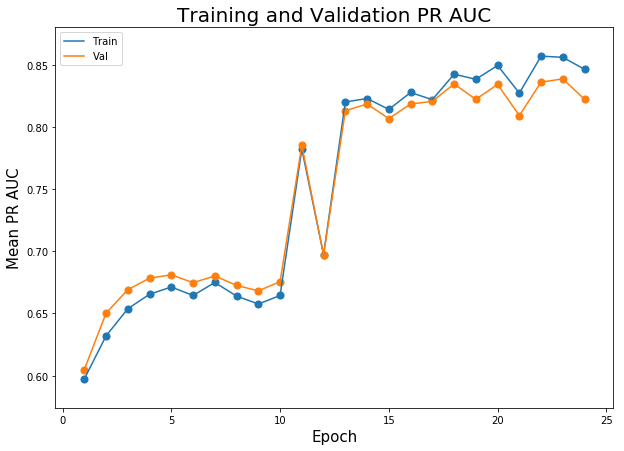

In [32]:
pr_auc_history_train = train_metric_callback.get_pr_auc_history()
pr_auc_history_val = val_callback.get_pr_auc_history()

plt.figure(figsize=(10, 7))
plot_with_dots(plt, pr_auc_history_train[-1])
plot_with_dots(plt, pr_auc_history_val[-1])

plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Mean PR AUC', fontsize=15)
plt.legend(['Train', 'Val'])
plt.title('Training and Validation PR AUC', fontsize=20)
plt.savefig('pr_auc_hist.png')

In [ ]:
plt.figure(figsize=(10, 7))
plot_with_dots(plt, history_0.history['loss']+history_1.history['loss'])
plot_with_dots(plt, history_0.history['val_loss']+history_1.history['val_loss'])

plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Binary Crossentropy', fontsize=15)
plt.legend(['Train', 'Val'])
plt.title('Training and Validation Loss', fontsize=20)
plt.savefig('loss_hist.png')

I left the model to train longer on my local GPU. I then upload the best model and plots from the model training.

In [ ]:
#model = load_model('../input/clouds-classifier-files/classifier_densenet169_epoch_21_val_pr_auc_0.8365921057512743.h5')

In [ ]:
Image("../input/clouds-classifier-files/loss_hist_densenet169.png")

In [ ]:
Image("../input/clouds-classifier-files/pr_auc_hist_densenet169.png")

# Selecting postprocessing thresholds

In [ ]:
class_names = ['Fish', 'Flower', 'Sugar', 'Gravel']
def get_threshold_for_recall(y_true, y_pred, class_i, recall_threshold=0.94, precision_threshold=0.90, plot=False):
    precision, recall, thresholds = precision_recall_curve(y_true[:, class_i], y_pred[:, class_i])
    i = len(thresholds) - 1
    best_recall_threshold = None
    while best_recall_threshold is None:
        next_threshold = thresholds[i]
        next_recall = recall[i]
        if next_recall >= recall_threshold:
            best_recall_threshold = next_threshold
        i -= 1
        
    # consice, even though unnecessary passing through all the values
    best_precision_threshold = [thres for prec, thres in zip(precision, thresholds) if prec >= precision_threshold][0]
    
    if plot:
        plt.figure(figsize=(10, 7))
        plt.step(recall, precision, color='r', alpha=0.3, where='post')
        plt.fill_between(recall, precision, alpha=0.3, color='r')
        plt.axhline(y=precision[i + 1])
        recall_for_prec_thres = [rec for rec, thres in zip(recall, thresholds) 
                                 if thres == best_precision_threshold][0]
        plt.axvline(x=recall_for_prec_thres, color='g')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.legend(['PR curve', 
                    f'Precision {precision[i + 1]: .2f} corresponding to selected recall threshold',
                    f'Recall {recall_for_prec_thres: .2f} corresponding to selected precision threshold'])
        plt.title(f'Precision-Recall curve for Class {class_names[class_i]}')
    return best_recall_threshold, best_precision_threshold

y_pred = model.predict_generator(data_generator_val, workers=num_cores)
y_true = data_generator_val.get_labels()
recall_thresholds = dict()
precision_thresholds = dict()
for i, class_name in tqdm(enumerate(class_names)):
    recall_thresholds[class_name], precision_thresholds[class_name] = get_threshold_for_recall(y_true, y_pred, i, plot=True)

# Post-processing segmentation submission

Predicting cloud classes for test.

In [ ]:
data_generator_test = DataGenenerator(folder_imgs=test_imgs_folder, shuffle=False)
y_pred_test = model.predict_generator(data_generator_test, workers=num_cores)

Estimating set of images without masks.

In [ ]:
image_labels_empty = set()
for i, (img, predictions) in enumerate(zip(os.listdir(test_imgs_folder), y_pred_test)):
    for class_i, class_name in enumerate(class_names):
        if predictions[class_i] < recall_thresholds[class_name]:
            image_labels_empty.add(f'{img}_{class_name}')

Segmentation results:

In [ ]:
submission = pd.read_csv('../input/densenet201cloudy/densenet201.csv')
submission.head()

In [ ]:
predictions_nonempty = set(submission.loc[~submission['EncodedPixels'].isnull(), 'Image_Label'].values)

In [ ]:
print(f'{len(image_labels_empty.intersection(predictions_nonempty))} masks would be removed')

In [ ]:
#removing masks
submission.loc[submission['Image_Label'].isin(image_labels_empty), 'EncodedPixels'] = np.nan
submission.to_csv('submission_segmentation_and_classifier.csv', index=None)

# Future work
1. estimate distribution of classes in test set using the classifier. Then, if necessary and doable, modify val set accordingly,
2. use the classifier with explainability technique [Gradient-weighted Class Activation Mapping](http://gradcam.cloudcv.org/) to generate a baseline, (please see [GradCAM: extracting masks from classifier](https://www.kaggle.com/samusram/gradcam-extracting-masks-from-classifier)),
3. improve the classifier,
4. use the classifier as backbone for UNet-like solution.